In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "QPM_species"
model_name = "flow_vcr_mse"
ood = "0"

In [3]:
# Parameters
ood = 0


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 263794 images
Dataset type val label type: species


Loaded 33867 images
Dataset type test label type: species


Loaded 34090 images
Dataset type train label type: species


Loaded 111649 images
Dataset type val label type: species


Loaded 14695 images
Dataset type test label type: species


Loaded 14700 images


In [6]:
# model ids
model_ids = {"0": 'p965yk91', "1": "", "2": "", "3": "", "4": "", "": ""}
ood_str = ":".join(map(str, config.ood))
model_id = model_ids[ood_str]
print(ood_str, model_id)

0 p965yk91


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from models.common import edl_probs
from tqdm import tqdm

trn_targets = []
val_targets = []
ind_targets = []
if ood_str:
    ood_targets = []

trn_u_norms = []
val_u_norms = []
ind_u_norms = []
if ood_str:
    ood_u_norms = []
rnd_u_norms = []

trn_v_norms = []
val_v_norms = []
ind_v_norms = []
if ood_str:
    ood_v_norms = []
rnd_v_norms = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    trn_u_norms.extend(u_norm.detach().cpu().numpy())
    trn_v_norms.extend(v_norm.detach().cpu().numpy())
    trn_targets.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    val_u_norms.extend(u_norm.detach().cpu().numpy())
    val_v_norms.extend(v_norm.detach().cpu().numpy())
    val_targets.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        v, z, x_m, u_norm, v_norm, logits = model(x)
        ood_u_norms.extend(u_norm.detach().cpu().numpy())
        ood_v_norms.extend(v_norm.detach().cpu().numpy())
        ood_targets.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

trn_targets = np.array(trn_targets).squeeze()
val_targets = np.array(val_targets).squeeze()
ind_targets = np.array(ind_targets).squeeze()
if ood_str:
    ood_targets = np.array(ood_targets).squeeze()

trn_u_norms = np.array(trn_u_norms).squeeze()
val_u_norms = np.array(val_u_norms).squeeze()
ind_u_norms = np.array(ind_u_norms).squeeze()
if ood_str:
    ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

trn_v_norms = np.array(trn_v_norms).squeeze()
val_v_norms = np.array(val_v_norms).squeeze()
ind_v_norms = np.array(ind_v_norms).squeeze()
if ood_str:
    ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(trn_u_norms.shape, trn_v_norms.shape)
print(val_u_norms.shape, val_v_norms.shape)
print(ind_u_norms.shape, ind_v_norms.shape)
if ood_str:
    print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

  0%|                                                                                                                | 0/4122 [00:00<?, ?it/s]

  0%|                                                                                                      | 1/4122 [00:00<1:04:07,  1.07it/s]

  0%|                                                                                                        | 3/4122 [00:01<19:47,  3.47it/s]

  0%|▏                                                                                                       | 5/4122 [00:01<11:34,  5.93it/s]

  0%|▏                                                                                                       | 7/4122 [00:01<08:16,  8.29it/s]

  0%|▏                                                                                                       | 9/4122 [00:01<06:34, 10.42it/s]

  0%|▎                                                                                                      | 11/4122 [00:01<05:35, 12.25it/s]

  0%|▎                                                                                                      | 13/4122 [00:01<04:58, 13.76it/s]

  0%|▎                                                                                                      | 15/4122 [00:01<04:35, 14.93it/s]

  0%|▍                                                                                                      | 17/4122 [00:01<04:19, 15.84it/s]

  0%|▍                                                                                                      | 19/4122 [00:01<04:08, 16.50it/s]

  1%|▌                                                                                                      | 21/4122 [00:02<04:01, 17.01it/s]

  1%|▌                                                                                                      | 23/4122 [00:02<03:56, 17.35it/s]

  1%|▌                                                                                                      | 25/4122 [00:02<03:53, 17.58it/s]

  1%|▋                                                                                                      | 27/4122 [00:02<03:50, 17.76it/s]

  1%|▋                                                                                                      | 29/4122 [00:02<03:48, 17.88it/s]

  1%|▊                                                                                                      | 31/4122 [00:02<03:47, 17.99it/s]

  1%|▊                                                                                                      | 33/4122 [00:02<03:46, 18.05it/s]

  1%|▊                                                                                                      | 35/4122 [00:02<03:46, 18.08it/s]

  1%|▉                                                                                                      | 37/4122 [00:02<03:45, 18.14it/s]

  1%|▉                                                                                                      | 39/4122 [00:03<03:44, 18.18it/s]

  1%|█                                                                                                      | 41/4122 [00:03<03:44, 18.18it/s]

  1%|█                                                                                                      | 43/4122 [00:03<03:45, 18.11it/s]

  1%|█                                                                                                      | 45/4122 [00:03<03:45, 18.08it/s]

  1%|█▏                                                                                                     | 47/4122 [00:03<03:45, 18.04it/s]

  1%|█▏                                                                                                     | 49/4122 [00:03<03:45, 18.04it/s]

  1%|█▎                                                                                                     | 51/4122 [00:03<03:45, 18.04it/s]

  1%|█▎                                                                                                     | 53/4122 [00:03<03:45, 18.02it/s]

  1%|█▎                                                                                                     | 55/4122 [00:03<03:46, 17.95it/s]

  1%|█▍                                                                                                     | 57/4122 [00:04<03:47, 17.91it/s]

  1%|█▍                                                                                                     | 59/4122 [00:04<03:46, 17.98it/s]

  1%|█▌                                                                                                     | 61/4122 [00:04<03:44, 18.06it/s]

  2%|█▌                                                                                                     | 63/4122 [00:04<03:44, 18.12it/s]

  2%|█▌                                                                                                     | 65/4122 [00:04<03:43, 18.17it/s]

  2%|█▋                                                                                                     | 67/4122 [00:04<03:43, 18.18it/s]

  2%|█▋                                                                                                     | 69/4122 [00:04<03:42, 18.20it/s]

  2%|█▊                                                                                                     | 71/4122 [00:04<03:42, 18.21it/s]

  2%|█▊                                                                                                     | 73/4122 [00:04<03:42, 18.19it/s]

  2%|█▊                                                                                                     | 75/4122 [00:05<03:42, 18.19it/s]

  2%|█▉                                                                                                     | 77/4122 [00:05<03:42, 18.18it/s]

  2%|█▉                                                                                                     | 79/4122 [00:05<03:42, 18.18it/s]

  2%|██                                                                                                     | 81/4122 [00:05<03:42, 18.19it/s]

  2%|██                                                                                                     | 83/4122 [00:05<03:42, 18.18it/s]

  2%|██                                                                                                     | 85/4122 [00:05<03:41, 18.23it/s]

  2%|██▏                                                                                                    | 87/4122 [00:05<03:41, 18.21it/s]

  2%|██▏                                                                                                    | 89/4122 [00:05<03:41, 18.21it/s]

  2%|██▎                                                                                                    | 91/4122 [00:05<03:41, 18.20it/s]

  2%|██▎                                                                                                    | 93/4122 [00:06<03:41, 18.19it/s]

  2%|██▎                                                                                                    | 95/4122 [00:06<03:41, 18.18it/s]

  2%|██▍                                                                                                    | 97/4122 [00:06<03:41, 18.17it/s]

  2%|██▍                                                                                                    | 99/4122 [00:06<03:41, 18.18it/s]

  2%|██▍                                                                                                   | 101/4122 [00:06<03:41, 18.17it/s]

  2%|██▌                                                                                                   | 103/4122 [00:06<03:41, 18.15it/s]

  3%|██▌                                                                                                   | 105/4122 [00:06<03:41, 18.14it/s]

  3%|██▋                                                                                                   | 107/4122 [00:06<03:40, 18.20it/s]

  3%|██▋                                                                                                   | 109/4122 [00:06<03:40, 18.22it/s]

  3%|██▋                                                                                                   | 111/4122 [00:07<03:40, 18.19it/s]

  3%|██▊                                                                                                   | 113/4122 [00:07<03:40, 18.16it/s]

  3%|██▊                                                                                                   | 115/4122 [00:07<03:40, 18.16it/s]

  3%|██▉                                                                                                   | 117/4122 [00:07<03:40, 18.15it/s]

  3%|██▉                                                                                                   | 119/4122 [00:07<03:40, 18.17it/s]

  3%|██▉                                                                                                   | 121/4122 [00:07<03:40, 18.19it/s]

  3%|███                                                                                                   | 123/4122 [00:07<03:40, 18.17it/s]

  3%|███                                                                                                   | 125/4122 [00:07<03:39, 18.18it/s]

  3%|███▏                                                                                                  | 127/4122 [00:07<03:39, 18.21it/s]

  3%|███▏                                                                                                  | 129/4122 [00:07<03:39, 18.22it/s]

  3%|███▏                                                                                                  | 131/4122 [00:08<03:39, 18.21it/s]

  3%|███▎                                                                                                  | 133/4122 [00:08<03:39, 18.17it/s]

  3%|███▎                                                                                                  | 135/4122 [00:08<03:39, 18.14it/s]

  3%|███▍                                                                                                  | 137/4122 [00:08<03:39, 18.13it/s]

  3%|███▍                                                                                                  | 139/4122 [00:08<03:39, 18.13it/s]

  3%|███▍                                                                                                  | 141/4122 [00:08<03:39, 18.13it/s]

  3%|███▌                                                                                                  | 143/4122 [00:08<03:39, 18.15it/s]

  4%|███▌                                                                                                  | 145/4122 [00:08<03:38, 18.17it/s]

  4%|███▋                                                                                                  | 147/4122 [00:08<03:38, 18.17it/s]

  4%|███▋                                                                                                  | 149/4122 [00:09<03:38, 18.20it/s]

  4%|███▋                                                                                                  | 151/4122 [00:09<03:37, 18.25it/s]

  4%|███▊                                                                                                  | 153/4122 [00:09<03:37, 18.22it/s]

  4%|███▊                                                                                                  | 155/4122 [00:09<03:38, 18.17it/s]

  4%|███▉                                                                                                  | 157/4122 [00:09<03:38, 18.16it/s]

  4%|███▉                                                                                                  | 159/4122 [00:09<03:38, 18.14it/s]

  4%|███▉                                                                                                  | 161/4122 [00:09<03:38, 18.14it/s]

  4%|████                                                                                                  | 163/4122 [00:09<03:38, 18.14it/s]

  4%|████                                                                                                  | 165/4122 [00:09<03:38, 18.12it/s]

  4%|████▏                                                                                                 | 167/4122 [00:10<03:37, 18.15it/s]

  4%|████▏                                                                                                 | 169/4122 [00:10<03:37, 18.19it/s]

  4%|████▏                                                                                                 | 171/4122 [00:10<03:37, 18.19it/s]

  4%|████▎                                                                                                 | 173/4122 [00:10<03:36, 18.22it/s]

  4%|████▎                                                                                                 | 175/4122 [00:10<03:36, 18.21it/s]

  4%|████▍                                                                                                 | 177/4122 [00:10<03:36, 18.21it/s]

  4%|████▍                                                                                                 | 179/4122 [00:10<03:36, 18.18it/s]

  4%|████▍                                                                                                 | 181/4122 [00:10<03:37, 18.16it/s]

  4%|████▌                                                                                                 | 183/4122 [00:10<03:37, 18.15it/s]

  4%|████▌                                                                                                 | 185/4122 [00:11<03:36, 18.15it/s]

  5%|████▋                                                                                                 | 187/4122 [00:11<03:36, 18.17it/s]

  5%|████▋                                                                                                 | 189/4122 [00:11<03:36, 18.20it/s]

  5%|████▋                                                                                                 | 191/4122 [00:11<03:35, 18.21it/s]

  5%|████▊                                                                                                 | 193/4122 [00:11<03:35, 18.24it/s]

  5%|████▊                                                                                                 | 195/4122 [00:11<03:35, 18.26it/s]

  5%|████▊                                                                                                 | 197/4122 [00:11<03:35, 18.24it/s]

  5%|████▉                                                                                                 | 199/4122 [00:11<03:35, 18.22it/s]

  5%|████▉                                                                                                 | 201/4122 [00:11<03:35, 18.20it/s]

  5%|█████                                                                                                 | 203/4122 [00:12<03:35, 18.17it/s]

  5%|█████                                                                                                 | 205/4122 [00:12<03:35, 18.19it/s]

  5%|█████                                                                                                 | 207/4122 [00:12<03:35, 18.19it/s]

  5%|█████▏                                                                                                | 209/4122 [00:12<03:34, 18.22it/s]

  5%|█████▏                                                                                                | 211/4122 [00:12<03:34, 18.26it/s]

  5%|█████▎                                                                                                | 213/4122 [00:12<03:34, 18.25it/s]

  5%|█████▎                                                                                                | 215/4122 [00:12<03:34, 18.20it/s]

  5%|█████▎                                                                                                | 217/4122 [00:12<03:34, 18.20it/s]

  5%|█████▍                                                                                                | 219/4122 [00:12<03:34, 18.20it/s]

  5%|█████▍                                                                                                | 221/4122 [00:13<03:34, 18.21it/s]

  5%|█████▌                                                                                                | 223/4122 [00:13<03:34, 18.22it/s]

  5%|█████▌                                                                                                | 225/4122 [00:13<03:33, 18.23it/s]

  6%|█████▌                                                                                                | 227/4122 [00:13<03:33, 18.22it/s]

  6%|█████▋                                                                                                | 229/4122 [00:13<03:33, 18.27it/s]

  6%|█████▋                                                                                                | 231/4122 [00:13<03:34, 18.16it/s]

  6%|█████▊                                                                                                | 233/4122 [00:13<03:33, 18.19it/s]

  6%|█████▊                                                                                                | 235/4122 [00:13<03:33, 18.21it/s]

  6%|█████▊                                                                                                | 237/4122 [00:13<03:33, 18.22it/s]

  6%|█████▉                                                                                                | 239/4122 [00:14<03:33, 18.22it/s]

  6%|█████▉                                                                                                | 241/4122 [00:14<03:32, 18.24it/s]

  6%|██████                                                                                                | 243/4122 [00:14<03:32, 18.23it/s]

  6%|██████                                                                                                | 245/4122 [00:14<03:32, 18.24it/s]

  6%|██████                                                                                                | 247/4122 [00:14<03:32, 18.25it/s]

  6%|██████▏                                                                                               | 249/4122 [00:14<03:32, 18.23it/s]

  6%|██████▏                                                                                               | 251/4122 [00:14<03:32, 18.21it/s]

  6%|██████▎                                                                                               | 253/4122 [00:14<03:32, 18.21it/s]

  6%|██████▎                                                                                               | 255/4122 [00:14<03:32, 18.21it/s]

  6%|██████▎                                                                                               | 257/4122 [00:15<03:31, 18.25it/s]

  6%|██████▍                                                                                               | 259/4122 [00:15<03:31, 18.24it/s]

  6%|██████▍                                                                                               | 261/4122 [00:15<03:31, 18.27it/s]

  6%|██████▌                                                                                               | 263/4122 [00:15<03:30, 18.30it/s]

  6%|██████▌                                                                                               | 265/4122 [00:15<03:30, 18.28it/s]

  6%|██████▌                                                                                               | 267/4122 [00:15<03:31, 18.26it/s]

  7%|██████▋                                                                                               | 269/4122 [00:15<03:31, 18.25it/s]

  7%|██████▋                                                                                               | 271/4122 [00:15<03:31, 18.24it/s]

  7%|██████▊                                                                                               | 273/4122 [00:15<03:30, 18.29it/s]

  7%|██████▊                                                                                               | 275/4122 [00:16<03:30, 18.28it/s]

  7%|██████▊                                                                                               | 277/4122 [00:16<03:30, 18.28it/s]

  7%|██████▉                                                                                               | 279/4122 [00:16<03:30, 18.29it/s]

  7%|██████▉                                                                                               | 281/4122 [00:16<03:29, 18.29it/s]

  7%|███████                                                                                               | 283/4122 [00:16<03:30, 18.28it/s]

  7%|███████                                                                                               | 285/4122 [00:16<03:29, 18.31it/s]

  7%|███████                                                                                               | 287/4122 [00:16<03:30, 18.26it/s]

  7%|███████▏                                                                                              | 289/4122 [00:16<03:29, 18.25it/s]

  7%|███████▏                                                                                              | 291/4122 [00:16<03:30, 18.24it/s]

  7%|███████▎                                                                                              | 293/4122 [00:17<03:30, 18.22it/s]

  7%|███████▎                                                                                              | 295/4122 [00:17<03:29, 18.25it/s]

  7%|███████▎                                                                                              | 297/4122 [00:17<03:29, 18.25it/s]

  7%|███████▍                                                                                              | 299/4122 [00:17<03:29, 18.23it/s]

  7%|███████▍                                                                                              | 301/4122 [00:17<03:29, 18.26it/s]

  7%|███████▍                                                                                              | 303/4122 [00:17<03:28, 18.28it/s]

  7%|███████▌                                                                                              | 305/4122 [00:17<03:29, 18.25it/s]

  7%|███████▌                                                                                              | 307/4122 [00:17<03:29, 18.23it/s]

  7%|███████▋                                                                                              | 309/4122 [00:17<03:29, 18.22it/s]

  8%|███████▋                                                                                              | 311/4122 [00:17<03:29, 18.21it/s]

  8%|███████▋                                                                                              | 313/4122 [00:18<03:29, 18.21it/s]

  8%|███████▊                                                                                              | 315/4122 [00:18<03:29, 18.18it/s]

  8%|███████▊                                                                                              | 317/4122 [00:18<03:29, 18.20it/s]

  8%|███████▉                                                                                              | 319/4122 [00:18<03:28, 18.22it/s]

  8%|███████▉                                                                                              | 321/4122 [00:18<03:28, 18.24it/s]

  8%|███████▉                                                                                              | 323/4122 [00:18<03:28, 18.22it/s]

  8%|████████                                                                                              | 325/4122 [00:18<03:28, 18.20it/s]

  8%|████████                                                                                              | 327/4122 [00:18<03:28, 18.19it/s]

  8%|████████▏                                                                                             | 329/4122 [00:18<03:28, 18.17it/s]

  8%|████████▏                                                                                             | 331/4122 [00:19<03:28, 18.18it/s]

  8%|████████▏                                                                                             | 333/4122 [00:19<03:28, 18.20it/s]

  8%|████████▎                                                                                             | 335/4122 [00:19<03:28, 18.19it/s]

  8%|████████▎                                                                                             | 337/4122 [00:19<03:27, 18.24it/s]

  8%|████████▍                                                                                             | 339/4122 [00:19<03:27, 18.25it/s]

  8%|████████▍                                                                                             | 341/4122 [00:19<03:27, 18.25it/s]

  8%|████████▍                                                                                             | 343/4122 [00:19<03:27, 18.24it/s]

  8%|████████▌                                                                                             | 345/4122 [00:19<03:27, 18.19it/s]

  8%|████████▌                                                                                             | 347/4122 [00:19<03:27, 18.15it/s]

  8%|████████▋                                                                                             | 349/4122 [00:20<03:27, 18.18it/s]

  9%|████████▋                                                                                             | 351/4122 [00:20<03:26, 18.22it/s]

  9%|████████▋                                                                                             | 353/4122 [00:20<03:26, 18.24it/s]

  9%|████████▊                                                                                             | 355/4122 [00:20<03:26, 18.24it/s]

  9%|████████▊                                                                                             | 357/4122 [00:20<03:26, 18.23it/s]

  9%|████████▉                                                                                             | 359/4122 [00:20<03:26, 18.24it/s]

  9%|████████▉                                                                                             | 361/4122 [00:20<03:26, 18.21it/s]

  9%|████████▉                                                                                             | 363/4122 [00:20<03:26, 18.23it/s]

  9%|█████████                                                                                             | 365/4122 [00:20<03:25, 18.26it/s]

  9%|█████████                                                                                             | 367/4122 [00:21<03:25, 18.25it/s]

  9%|█████████▏                                                                                            | 369/4122 [00:21<03:25, 18.28it/s]

  9%|█████████▏                                                                                            | 371/4122 [00:21<03:25, 18.27it/s]

  9%|█████████▏                                                                                            | 373/4122 [00:21<03:25, 18.25it/s]

  9%|█████████▎                                                                                            | 375/4122 [00:21<03:25, 18.25it/s]

  9%|█████████▎                                                                                            | 377/4122 [00:21<03:25, 18.26it/s]

  9%|█████████▍                                                                                            | 379/4122 [00:21<03:24, 18.27it/s]

  9%|█████████▍                                                                                            | 381/4122 [00:21<03:24, 18.30it/s]

  9%|█████████▍                                                                                            | 383/4122 [00:21<03:24, 18.29it/s]

  9%|█████████▌                                                                                            | 385/4122 [00:22<03:25, 18.22it/s]

  9%|█████████▌                                                                                            | 387/4122 [00:22<03:24, 18.24it/s]

  9%|█████████▋                                                                                            | 389/4122 [00:22<03:24, 18.26it/s]

  9%|█████████▋                                                                                            | 391/4122 [00:22<03:24, 18.27it/s]

 10%|█████████▋                                                                                            | 393/4122 [00:22<03:23, 18.31it/s]

 10%|█████████▊                                                                                            | 395/4122 [00:22<03:23, 18.28it/s]

 10%|█████████▊                                                                                            | 397/4122 [00:22<03:23, 18.28it/s]

 10%|█████████▊                                                                                            | 399/4122 [00:22<03:23, 18.26it/s]

 10%|█████████▉                                                                                            | 401/4122 [00:22<03:23, 18.25it/s]

 10%|█████████▉                                                                                            | 403/4122 [00:23<03:24, 18.21it/s]

 10%|██████████                                                                                            | 405/4122 [00:23<03:23, 18.23it/s]

 10%|██████████                                                                                            | 407/4122 [00:23<03:23, 18.23it/s]

 10%|██████████                                                                                            | 409/4122 [00:23<03:23, 18.26it/s]

 10%|██████████▏                                                                                           | 411/4122 [00:23<03:23, 18.24it/s]

 10%|██████████▏                                                                                           | 413/4122 [00:23<03:23, 18.18it/s]

 10%|██████████▎                                                                                           | 415/4122 [00:23<03:23, 18.18it/s]

 10%|██████████▎                                                                                           | 417/4122 [00:23<03:24, 18.15it/s]

 10%|██████████▎                                                                                           | 419/4122 [00:23<03:23, 18.15it/s]

 10%|██████████▍                                                                                           | 421/4122 [00:24<03:23, 18.21it/s]

 10%|██████████▍                                                                                           | 423/4122 [00:24<03:22, 18.22it/s]

 10%|██████████▌                                                                                           | 425/4122 [00:24<03:22, 18.22it/s]

 10%|██████████▌                                                                                           | 427/4122 [00:24<03:22, 18.24it/s]

 10%|██████████▌                                                                                           | 429/4122 [00:24<03:22, 18.25it/s]

 10%|██████████▋                                                                                           | 431/4122 [00:24<03:22, 18.24it/s]

 11%|██████████▋                                                                                           | 433/4122 [00:24<03:21, 18.27it/s]

 11%|██████████▊                                                                                           | 435/4122 [00:24<03:21, 18.27it/s]

 11%|██████████▊                                                                                           | 437/4122 [00:24<03:21, 18.28it/s]

 11%|██████████▊                                                                                           | 439/4122 [00:25<03:21, 18.30it/s]

 11%|██████████▉                                                                                           | 441/4122 [00:25<03:21, 18.28it/s]

 11%|██████████▉                                                                                           | 443/4122 [00:25<03:21, 18.27it/s]

 11%|███████████                                                                                           | 445/4122 [00:25<03:22, 18.17it/s]

 11%|███████████                                                                                           | 447/4122 [00:25<03:22, 18.17it/s]

 11%|███████████                                                                                           | 449/4122 [00:25<03:21, 18.21it/s]

 11%|███████████▏                                                                                          | 451/4122 [00:25<03:21, 18.21it/s]

 11%|███████████▏                                                                                          | 453/4122 [00:25<03:21, 18.21it/s]

 11%|███████████▎                                                                                          | 455/4122 [00:25<03:21, 18.21it/s]

 11%|███████████▎                                                                                          | 457/4122 [00:25<03:21, 18.21it/s]

 11%|███████████▎                                                                                          | 459/4122 [00:26<03:21, 18.21it/s]

 11%|███████████▍                                                                                          | 461/4122 [00:26<03:20, 18.22it/s]

 11%|███████████▍                                                                                          | 463/4122 [00:26<03:20, 18.24it/s]

 11%|███████████▌                                                                                          | 465/4122 [00:26<03:20, 18.26it/s]

 11%|███████████▌                                                                                          | 467/4122 [00:26<03:20, 18.25it/s]

 11%|███████████▌                                                                                          | 469/4122 [00:26<03:19, 18.28it/s]

 11%|███████████▋                                                                                          | 471/4122 [00:26<03:19, 18.26it/s]

 11%|███████████▋                                                                                          | 473/4122 [00:26<03:19, 18.28it/s]

 12%|███████████▊                                                                                          | 475/4122 [00:26<03:19, 18.27it/s]

 12%|███████████▊                                                                                          | 477/4122 [00:27<03:19, 18.28it/s]

 12%|███████████▊                                                                                          | 479/4122 [00:27<03:19, 18.24it/s]

 12%|███████████▉                                                                                          | 481/4122 [00:27<03:19, 18.28it/s]

 12%|███████████▉                                                                                          | 483/4122 [00:27<03:19, 18.27it/s]

 12%|████████████                                                                                          | 485/4122 [00:27<03:19, 18.26it/s]

 12%|████████████                                                                                          | 487/4122 [00:27<03:19, 18.23it/s]

 12%|████████████                                                                                          | 489/4122 [00:27<03:19, 18.24it/s]

 12%|████████████▏                                                                                         | 491/4122 [00:27<03:19, 18.24it/s]

 12%|████████████▏                                                                                         | 493/4122 [00:27<03:18, 18.28it/s]

 12%|████████████▏                                                                                         | 495/4122 [00:28<03:18, 18.28it/s]

 12%|████████████▎                                                                                         | 497/4122 [00:28<03:18, 18.25it/s]

 12%|████████████▎                                                                                         | 499/4122 [00:28<03:18, 18.23it/s]

 12%|████████████▍                                                                                         | 501/4122 [00:28<03:19, 18.18it/s]

 12%|████████████▍                                                                                         | 503/4122 [00:28<03:18, 18.19it/s]

 12%|████████████▍                                                                                         | 505/4122 [00:28<03:18, 18.23it/s]

 12%|████████████▌                                                                                         | 507/4122 [00:28<03:18, 18.25it/s]

 12%|████████████▌                                                                                         | 509/4122 [00:28<03:17, 18.28it/s]

 12%|████████████▋                                                                                         | 511/4122 [00:28<03:17, 18.25it/s]

 12%|████████████▋                                                                                         | 513/4122 [00:29<03:17, 18.24it/s]

 12%|████████████▋                                                                                         | 515/4122 [00:29<03:17, 18.24it/s]

 13%|████████████▊                                                                                         | 517/4122 [00:29<03:17, 18.22it/s]

 13%|████████████▊                                                                                         | 519/4122 [00:29<03:17, 18.22it/s]

 13%|████████████▉                                                                                         | 521/4122 [00:29<03:17, 18.24it/s]

 13%|████████████▉                                                                                         | 523/4122 [00:29<03:17, 18.26it/s]

 13%|████████████▉                                                                                         | 525/4122 [00:29<03:16, 18.30it/s]

 13%|█████████████                                                                                         | 527/4122 [00:29<03:16, 18.31it/s]

 13%|█████████████                                                                                         | 529/4122 [00:29<03:16, 18.27it/s]

 13%|█████████████▏                                                                                        | 531/4122 [00:30<03:16, 18.26it/s]

 13%|█████████████▏                                                                                        | 533/4122 [00:30<03:16, 18.25it/s]

 13%|█████████████▏                                                                                        | 535/4122 [00:30<03:16, 18.23it/s]

 13%|█████████████▎                                                                                        | 537/4122 [00:30<03:16, 18.26it/s]

 13%|█████████████▎                                                                                        | 539/4122 [00:30<03:16, 18.23it/s]

 13%|█████████████▍                                                                                        | 541/4122 [00:30<03:16, 18.25it/s]

 13%|█████████████▍                                                                                        | 543/4122 [00:30<03:16, 18.23it/s]

 13%|█████████████▍                                                                                        | 545/4122 [00:30<03:16, 18.21it/s]

 13%|█████████████▌                                                                                        | 547/4122 [00:30<03:16, 18.23it/s]

 13%|█████████████▌                                                                                        | 549/4122 [00:31<03:15, 18.27it/s]

 13%|█████████████▋                                                                                        | 551/4122 [00:31<03:15, 18.28it/s]

 13%|█████████████▋                                                                                        | 553/4122 [00:31<03:15, 18.28it/s]

 13%|█████████████▋                                                                                        | 555/4122 [00:31<03:15, 18.29it/s]

 14%|█████████████▊                                                                                        | 557/4122 [00:31<03:15, 18.28it/s]

 14%|█████████████▊                                                                                        | 559/4122 [00:31<03:15, 18.25it/s]

 14%|█████████████▉                                                                                        | 561/4122 [00:31<03:14, 18.29it/s]

 14%|█████████████▉                                                                                        | 563/4122 [00:31<03:14, 18.27it/s]

 14%|█████████████▉                                                                                        | 565/4122 [00:31<03:14, 18.28it/s]

 14%|██████████████                                                                                        | 567/4122 [00:32<03:14, 18.30it/s]

 14%|██████████████                                                                                        | 569/4122 [00:32<03:14, 18.27it/s]

 14%|██████████████▏                                                                                       | 571/4122 [00:32<03:14, 18.26it/s]

 14%|██████████████▏                                                                                       | 573/4122 [00:32<03:14, 18.28it/s]

 14%|██████████████▏                                                                                       | 575/4122 [00:32<03:14, 18.24it/s]

 14%|██████████████▎                                                                                       | 577/4122 [00:32<03:14, 18.25it/s]

 14%|██████████████▎                                                                                       | 579/4122 [00:32<03:13, 18.27it/s]

 14%|██████████████▍                                                                                       | 581/4122 [00:32<03:14, 18.23it/s]

 14%|██████████████▍                                                                                       | 583/4122 [00:32<03:14, 18.24it/s]

 14%|██████████████▍                                                                                       | 585/4122 [00:33<03:13, 18.25it/s]

 14%|██████████████▌                                                                                       | 587/4122 [00:33<03:13, 18.27it/s]

 14%|██████████████▌                                                                                       | 589/4122 [00:33<03:13, 18.30it/s]

 14%|██████████████▌                                                                                       | 591/4122 [00:33<03:12, 18.31it/s]

 14%|██████████████▋                                                                                       | 593/4122 [00:33<03:12, 18.29it/s]

 14%|██████████████▋                                                                                       | 595/4122 [00:33<03:13, 18.27it/s]

 14%|██████████████▊                                                                                       | 597/4122 [00:33<03:12, 18.27it/s]

 15%|██████████████▊                                                                                       | 599/4122 [00:33<03:12, 18.26it/s]

 15%|██████████████▊                                                                                       | 601/4122 [00:33<03:12, 18.28it/s]

 15%|██████████████▉                                                                                       | 603/4122 [00:33<03:13, 18.22it/s]

 15%|██████████████▉                                                                                       | 605/4122 [00:34<03:13, 18.20it/s]

 15%|███████████████                                                                                       | 607/4122 [00:34<03:12, 18.22it/s]

 15%|███████████████                                                                                       | 609/4122 [00:34<03:12, 18.21it/s]

 15%|███████████████                                                                                       | 611/4122 [00:34<03:12, 18.22it/s]

 15%|███████████████▏                                                                                      | 613/4122 [00:34<03:12, 18.25it/s]

 15%|███████████████▏                                                                                      | 615/4122 [00:34<03:11, 18.27it/s]

 15%|███████████████▎                                                                                      | 617/4122 [00:34<03:11, 18.30it/s]

 15%|███████████████▎                                                                                      | 619/4122 [00:34<03:11, 18.30it/s]

 15%|███████████████▎                                                                                      | 621/4122 [00:34<03:11, 18.28it/s]

 15%|███████████████▍                                                                                      | 623/4122 [00:35<03:11, 18.25it/s]

 15%|███████████████▍                                                                                      | 625/4122 [00:35<03:11, 18.25it/s]

 15%|███████████████▌                                                                                      | 627/4122 [00:35<03:11, 18.25it/s]

 15%|███████████████▌                                                                                      | 629/4122 [00:35<03:11, 18.29it/s]

 15%|███████████████▌                                                                                      | 631/4122 [00:35<03:10, 18.31it/s]

 15%|███████████████▋                                                                                      | 633/4122 [00:35<03:10, 18.28it/s]

 15%|███████████████▋                                                                                      | 635/4122 [00:35<03:11, 18.25it/s]

 15%|███████████████▊                                                                                      | 637/4122 [00:35<03:10, 18.26it/s]

 16%|███████████████▊                                                                                      | 639/4122 [00:35<03:10, 18.27it/s]

 16%|███████████████▊                                                                                      | 641/4122 [00:36<03:09, 18.32it/s]

 16%|███████████████▉                                                                                      | 643/4122 [00:36<03:10, 18.30it/s]

 16%|███████████████▉                                                                                      | 645/4122 [00:36<03:10, 18.28it/s]

 16%|████████████████                                                                                      | 647/4122 [00:36<03:10, 18.23it/s]

 16%|████████████████                                                                                      | 649/4122 [00:36<03:10, 18.22it/s]

 16%|████████████████                                                                                      | 651/4122 [00:36<03:10, 18.22it/s]

 16%|████████████████▏                                                                                     | 653/4122 [00:36<03:10, 18.25it/s]

 16%|████████████████▏                                                                                     | 655/4122 [00:36<03:10, 18.25it/s]

 16%|████████████████▎                                                                                     | 657/4122 [00:36<03:09, 18.28it/s]

 16%|████████████████▎                                                                                     | 659/4122 [00:37<03:09, 18.28it/s]

 16%|████████████████▎                                                                                     | 661/4122 [00:37<03:09, 18.26it/s]

 16%|████████████████▍                                                                                     | 663/4122 [00:37<03:09, 18.25it/s]

 16%|████████████████▍                                                                                     | 665/4122 [00:37<03:09, 18.22it/s]

 16%|████████████████▌                                                                                     | 667/4122 [00:37<03:09, 18.19it/s]

 16%|████████████████▌                                                                                     | 669/4122 [00:37<03:09, 18.23it/s]

 16%|████████████████▌                                                                                     | 671/4122 [00:37<03:09, 18.24it/s]

 16%|████████████████▋                                                                                     | 673/4122 [00:37<03:09, 18.24it/s]

 16%|████████████████▋                                                                                     | 675/4122 [00:37<03:09, 18.19it/s]

 16%|████████████████▊                                                                                     | 677/4122 [00:38<03:09, 18.20it/s]

 16%|████████████████▊                                                                                     | 679/4122 [00:38<03:09, 18.21it/s]

 17%|████████████████▊                                                                                     | 681/4122 [00:38<03:08, 18.25it/s]

 17%|████████████████▉                                                                                     | 683/4122 [00:38<03:08, 18.27it/s]

 17%|████████████████▉                                                                                     | 685/4122 [00:38<03:08, 18.28it/s]

 17%|█████████████████                                                                                     | 687/4122 [00:38<03:08, 18.26it/s]

 17%|█████████████████                                                                                     | 689/4122 [00:38<03:08, 18.24it/s]

 17%|█████████████████                                                                                     | 691/4122 [00:38<03:08, 18.23it/s]

 17%|█████████████████▏                                                                                    | 693/4122 [00:38<03:07, 18.25it/s]

 17%|█████████████████▏                                                                                    | 695/4122 [00:39<03:07, 18.25it/s]

 17%|█████████████████▏                                                                                    | 697/4122 [00:39<03:07, 18.28it/s]

 17%|█████████████████▎                                                                                    | 699/4122 [00:39<03:07, 18.30it/s]

 17%|█████████████████▎                                                                                    | 701/4122 [00:39<03:07, 18.27it/s]

 17%|█████████████████▍                                                                                    | 703/4122 [00:39<03:07, 18.26it/s]

 17%|█████████████████▍                                                                                    | 705/4122 [00:39<03:07, 18.27it/s]

 17%|█████████████████▍                                                                                    | 707/4122 [00:39<03:07, 18.23it/s]

 17%|█████████████████▌                                                                                    | 709/4122 [00:39<03:07, 18.23it/s]

 17%|█████████████████▌                                                                                    | 711/4122 [00:39<03:06, 18.25it/s]

 17%|█████████████████▋                                                                                    | 713/4122 [00:40<03:06, 18.24it/s]

 17%|█████████████████▋                                                                                    | 715/4122 [00:40<03:06, 18.23it/s]

 17%|█████████████████▋                                                                                    | 717/4122 [00:40<03:07, 18.20it/s]

 17%|█████████████████▊                                                                                    | 719/4122 [00:40<03:06, 18.20it/s]

 17%|█████████████████▊                                                                                    | 721/4122 [00:40<03:06, 18.24it/s]

 18%|█████████████████▉                                                                                    | 723/4122 [00:40<03:06, 18.23it/s]

 18%|█████████████████▉                                                                                    | 725/4122 [00:40<03:06, 18.26it/s]

 18%|█████████████████▉                                                                                    | 727/4122 [00:40<03:06, 18.22it/s]

 18%|██████████████████                                                                                    | 729/4122 [00:40<03:06, 18.23it/s]

 18%|██████████████████                                                                                    | 731/4122 [00:41<03:06, 18.20it/s]

 18%|██████████████████▏                                                                                   | 733/4122 [00:41<03:06, 18.18it/s]

 18%|██████████████████▏                                                                                   | 735/4122 [00:41<03:06, 18.18it/s]

 18%|██████████████████▏                                                                                   | 737/4122 [00:41<03:05, 18.21it/s]

 18%|██████████████████▎                                                                                   | 739/4122 [00:41<03:05, 18.20it/s]

 18%|██████████████████▎                                                                                   | 741/4122 [00:41<03:05, 18.23it/s]

 18%|██████████████████▍                                                                                   | 743/4122 [00:41<03:04, 18.27it/s]

 18%|██████████████████▍                                                                                   | 745/4122 [00:41<03:04, 18.26it/s]

 18%|██████████████████▍                                                                                   | 747/4122 [00:41<03:05, 18.23it/s]

 18%|██████████████████▌                                                                                   | 749/4122 [00:41<03:05, 18.20it/s]

 18%|██████████████████▌                                                                                   | 751/4122 [00:42<03:05, 18.21it/s]

 18%|██████████████████▋                                                                                   | 753/4122 [00:42<03:04, 18.23it/s]

 18%|██████████████████▋                                                                                   | 755/4122 [00:42<03:04, 18.22it/s]

 18%|██████████████████▋                                                                                   | 757/4122 [00:42<03:04, 18.27it/s]

 18%|██████████████████▊                                                                                   | 759/4122 [00:42<03:04, 18.26it/s]

 18%|██████████████████▊                                                                                   | 761/4122 [00:42<03:04, 18.24it/s]

 19%|██████████████████▉                                                                                   | 763/4122 [00:42<03:04, 18.23it/s]

 19%|██████████████████▉                                                                                   | 765/4122 [00:42<03:04, 18.23it/s]

 19%|██████████████████▉                                                                                   | 767/4122 [00:42<03:03, 18.23it/s]

 19%|███████████████████                                                                                   | 769/4122 [00:43<03:03, 18.25it/s]

 19%|███████████████████                                                                                   | 771/4122 [00:43<03:03, 18.25it/s]

 19%|███████████████████▏                                                                                  | 773/4122 [00:43<03:03, 18.27it/s]

 19%|███████████████████▏                                                                                  | 775/4122 [00:43<03:03, 18.28it/s]

 19%|███████████████████▏                                                                                  | 777/4122 [00:43<03:03, 18.26it/s]

 19%|███████████████████▎                                                                                  | 779/4122 [00:43<03:03, 18.23it/s]

 19%|███████████████████▎                                                                                  | 781/4122 [00:43<03:03, 18.24it/s]

 19%|███████████████████▍                                                                                  | 783/4122 [00:43<03:03, 18.25it/s]

 19%|███████████████████▍                                                                                  | 785/4122 [00:43<03:02, 18.26it/s]

 19%|███████████████████▍                                                                                  | 787/4122 [00:44<03:02, 18.28it/s]

 19%|███████████████████▌                                                                                  | 789/4122 [00:44<03:02, 18.28it/s]

 19%|███████████████████▌                                                                                  | 791/4122 [00:44<03:02, 18.21it/s]

 19%|███████████████████▌                                                                                  | 793/4122 [00:44<03:02, 18.20it/s]

 19%|███████████████████▋                                                                                  | 795/4122 [00:44<03:02, 18.20it/s]

 19%|███████████████████▋                                                                                  | 797/4122 [00:44<03:02, 18.20it/s]

 19%|███████████████████▊                                                                                  | 799/4122 [00:44<03:02, 18.21it/s]

 19%|███████████████████▊                                                                                  | 801/4122 [00:44<03:02, 18.23it/s]

 19%|███████████████████▊                                                                                  | 803/4122 [00:44<03:01, 18.27it/s]

 20%|███████████████████▉                                                                                  | 805/4122 [00:45<03:01, 18.25it/s]

 20%|███████████████████▉                                                                                  | 807/4122 [00:45<03:01, 18.22it/s]

 20%|████████████████████                                                                                  | 809/4122 [00:45<03:01, 18.21it/s]

 20%|████████████████████                                                                                  | 811/4122 [00:45<03:01, 18.21it/s]

 20%|████████████████████                                                                                  | 813/4122 [00:45<03:01, 18.23it/s]

 20%|████████████████████▏                                                                                 | 815/4122 [00:45<03:01, 18.22it/s]

 20%|████████████████████▏                                                                                 | 817/4122 [00:45<03:00, 18.26it/s]

 20%|████████████████████▎                                                                                 | 819/4122 [00:45<03:01, 18.22it/s]

 20%|████████████████████▎                                                                                 | 821/4122 [00:45<03:01, 18.22it/s]

 20%|████████████████████▎                                                                                 | 823/4122 [00:46<03:01, 18.18it/s]

 20%|████████████████████▍                                                                                 | 825/4122 [00:46<03:01, 18.15it/s]

 20%|████████████████████▍                                                                                 | 827/4122 [00:46<03:01, 18.16it/s]

 20%|████████████████████▌                                                                                 | 829/4122 [00:46<03:01, 18.17it/s]

 20%|████████████████████▌                                                                                 | 831/4122 [00:46<03:00, 18.20it/s]

 20%|████████████████████▌                                                                                 | 833/4122 [00:46<03:00, 18.21it/s]

 20%|████████████████████▋                                                                                 | 835/4122 [00:46<03:00, 18.17it/s]

 20%|████████████████████▋                                                                                 | 837/4122 [00:46<03:00, 18.19it/s]

 20%|████████████████████▊                                                                                 | 839/4122 [00:46<03:00, 18.20it/s]

 20%|████████████████████▊                                                                                 | 841/4122 [00:47<03:00, 18.23it/s]

 20%|████████████████████▊                                                                                 | 843/4122 [00:47<02:59, 18.27it/s]

 20%|████████████████████▉                                                                                 | 845/4122 [00:47<02:59, 18.28it/s]

 21%|████████████████████▉                                                                                 | 847/4122 [00:47<02:59, 18.26it/s]

 21%|█████████████████████                                                                                 | 849/4122 [00:47<02:58, 18.29it/s]

 21%|█████████████████████                                                                                 | 851/4122 [00:47<02:59, 18.27it/s]

 21%|█████████████████████                                                                                 | 853/4122 [00:47<02:59, 18.26it/s]

 21%|█████████████████████▏                                                                                | 855/4122 [00:47<02:59, 18.25it/s]

 21%|█████████████████████▏                                                                                | 857/4122 [00:47<02:59, 18.22it/s]

 21%|█████████████████████▎                                                                                | 859/4122 [00:48<02:59, 18.22it/s]

 21%|█████████████████████▎                                                                                | 861/4122 [00:48<02:59, 18.19it/s]

 21%|█████████████████████▎                                                                                | 863/4122 [00:48<02:59, 18.20it/s]

 21%|█████████████████████▍                                                                                | 865/4122 [00:48<02:58, 18.23it/s]

 21%|█████████████████████▍                                                                                | 867/4122 [00:48<02:58, 18.24it/s]

 21%|█████████████████████▌                                                                                | 869/4122 [00:48<02:58, 18.24it/s]

 21%|█████████████████████▌                                                                                | 871/4122 [00:48<02:58, 18.22it/s]

 21%|█████████████████████▌                                                                                | 873/4122 [00:48<02:58, 18.25it/s]

 21%|█████████████████████▋                                                                                | 875/4122 [00:48<02:58, 18.23it/s]

 21%|█████████████████████▋                                                                                | 877/4122 [00:49<02:57, 18.26it/s]

 21%|█████████████████████▊                                                                                | 879/4122 [00:49<02:57, 18.30it/s]

 21%|█████████████████████▊                                                                                | 881/4122 [00:49<02:57, 18.29it/s]

 21%|█████████████████████▊                                                                                | 883/4122 [00:49<02:57, 18.28it/s]

 21%|█████████████████████▉                                                                                | 885/4122 [00:49<02:56, 18.29it/s]

 22%|█████████████████████▉                                                                                | 887/4122 [00:49<02:56, 18.28it/s]

 22%|█████████████████████▉                                                                                | 889/4122 [00:49<02:57, 18.25it/s]

 22%|██████████████████████                                                                                | 891/4122 [00:49<02:56, 18.28it/s]

 22%|██████████████████████                                                                                | 893/4122 [00:49<02:56, 18.26it/s]

 22%|██████████████████████▏                                                                               | 895/4122 [00:50<02:56, 18.24it/s]

 22%|██████████████████████▏                                                                               | 897/4122 [00:50<02:56, 18.23it/s]

 22%|██████████████████████▏                                                                               | 899/4122 [00:50<02:56, 18.21it/s]

 22%|██████████████████████▎                                                                               | 901/4122 [00:50<02:56, 18.20it/s]

 22%|██████████████████████▎                                                                               | 903/4122 [00:50<02:56, 18.21it/s]

 22%|██████████████████████▍                                                                               | 905/4122 [00:50<02:56, 18.20it/s]

 22%|██████████████████████▍                                                                               | 907/4122 [00:50<02:56, 18.21it/s]

 22%|██████████████████████▍                                                                               | 909/4122 [00:50<02:56, 18.23it/s]

 22%|██████████████████████▌                                                                               | 911/4122 [00:50<02:55, 18.25it/s]

 22%|██████████████████████▌                                                                               | 913/4122 [00:50<02:55, 18.23it/s]

 22%|██████████████████████▋                                                                               | 915/4122 [00:51<02:55, 18.23it/s]

 22%|██████████████████████▋                                                                               | 917/4122 [00:51<02:56, 18.21it/s]

 22%|██████████████████████▋                                                                               | 919/4122 [00:51<02:55, 18.20it/s]

 22%|██████████████████████▊                                                                               | 921/4122 [00:51<02:56, 18.17it/s]

 22%|██████████████████████▊                                                                               | 923/4122 [00:51<02:55, 18.21it/s]

 22%|██████████████████████▉                                                                               | 925/4122 [00:51<02:55, 18.20it/s]

 22%|██████████████████████▉                                                                               | 927/4122 [00:51<02:55, 18.17it/s]

 23%|██████████████████████▉                                                                               | 929/4122 [00:51<02:55, 18.17it/s]

 23%|███████████████████████                                                                               | 931/4122 [00:51<02:55, 18.17it/s]

 23%|███████████████████████                                                                               | 933/4122 [00:52<02:55, 18.17it/s]

 23%|███████████████████████▏                                                                              | 935/4122 [00:52<02:55, 18.19it/s]

 23%|███████████████████████▏                                                                              | 937/4122 [00:52<02:54, 18.20it/s]

 23%|███████████████████████▏                                                                              | 939/4122 [00:52<02:54, 18.21it/s]

 23%|███████████████████████▎                                                                              | 941/4122 [00:52<02:54, 18.19it/s]

 23%|███████████████████████▎                                                                              | 943/4122 [00:52<02:54, 18.21it/s]

 23%|███████████████████████▍                                                                              | 945/4122 [00:52<02:54, 18.21it/s]

 23%|███████████████████████▍                                                                              | 947/4122 [00:52<02:54, 18.18it/s]

 23%|███████████████████████▍                                                                              | 949/4122 [00:52<02:54, 18.18it/s]

 23%|███████████████████████▌                                                                              | 951/4122 [00:53<02:54, 18.18it/s]

 23%|███████████████████████▌                                                                              | 953/4122 [00:53<02:54, 18.19it/s]

 23%|███████████████████████▋                                                                              | 955/4122 [00:53<02:54, 18.19it/s]

 23%|███████████████████████▋                                                                              | 957/4122 [00:53<02:54, 18.18it/s]

 23%|███████████████████████▋                                                                              | 959/4122 [00:53<02:54, 18.14it/s]

 23%|███████████████████████▊                                                                              | 961/4122 [00:53<02:54, 18.17it/s]

 23%|███████████████████████▊                                                                              | 963/4122 [00:53<02:53, 18.19it/s]

 23%|███████████████████████▉                                                                              | 965/4122 [00:53<02:53, 18.18it/s]

 23%|███████████████████████▉                                                                              | 967/4122 [00:53<02:53, 18.18it/s]

 24%|███████████████████████▉                                                                              | 969/4122 [00:54<02:53, 18.16it/s]

 24%|████████████████████████                                                                              | 971/4122 [00:54<02:53, 18.21it/s]

 24%|████████████████████████                                                                              | 973/4122 [00:54<02:52, 18.22it/s]

 24%|████████████████████████▏                                                                             | 975/4122 [00:54<02:52, 18.20it/s]

 24%|████████████████████████▏                                                                             | 977/4122 [00:54<02:53, 18.18it/s]

 24%|████████████████████████▏                                                                             | 979/4122 [00:54<02:52, 18.18it/s]

 24%|████████████████████████▎                                                                             | 981/4122 [00:54<02:52, 18.23it/s]

 24%|████████████████████████▎                                                                             | 983/4122 [00:54<02:52, 18.22it/s]

 24%|████████████████████████▎                                                                             | 985/4122 [00:54<02:52, 18.19it/s]

 24%|████████████████████████▍                                                                             | 987/4122 [00:55<02:52, 18.17it/s]

 24%|████████████████████████▍                                                                             | 989/4122 [00:55<02:52, 18.21it/s]

 24%|████████████████████████▌                                                                             | 991/4122 [00:55<02:51, 18.23it/s]

 24%|████████████████████████▌                                                                             | 993/4122 [00:55<02:51, 18.26it/s]

 24%|████████████████████████▌                                                                             | 995/4122 [00:55<02:51, 18.23it/s]

 24%|████████████████████████▋                                                                             | 997/4122 [00:55<02:51, 18.26it/s]

 24%|████████████████████████▋                                                                             | 999/4122 [00:55<02:50, 18.26it/s]

 24%|████████████████████████▌                                                                            | 1001/4122 [00:55<02:51, 18.20it/s]

 24%|████████████████████████▌                                                                            | 1003/4122 [00:55<02:51, 18.21it/s]

 24%|████████████████████████▋                                                                            | 1005/4122 [00:56<02:51, 18.17it/s]

 24%|████████████████████████▋                                                                            | 1007/4122 [00:56<02:51, 18.14it/s]

 24%|████████████████████████▋                                                                            | 1009/4122 [00:56<02:51, 18.15it/s]

 25%|████████████████████████▊                                                                            | 1011/4122 [00:56<02:51, 18.17it/s]

 25%|████████████████████████▊                                                                            | 1013/4122 [00:56<02:54, 17.86it/s]

 25%|████████████████████████▊                                                                            | 1015/4122 [00:56<02:52, 17.98it/s]

 25%|████████████████████████▉                                                                            | 1017/4122 [00:56<02:51, 18.06it/s]

 25%|████████████████████████▉                                                                            | 1019/4122 [00:56<02:51, 18.12it/s]

 25%|█████████████████████████                                                                            | 1021/4122 [00:56<02:50, 18.17it/s]

 25%|█████████████████████████                                                                            | 1023/4122 [00:57<02:50, 18.18it/s]

 25%|█████████████████████████                                                                            | 1025/4122 [00:57<02:50, 18.19it/s]

 25%|█████████████████████████▏                                                                           | 1027/4122 [00:57<02:50, 18.18it/s]

 25%|█████████████████████████▏                                                                           | 1029/4122 [00:57<02:50, 18.17it/s]

 25%|█████████████████████████▎                                                                           | 1031/4122 [00:57<02:50, 18.16it/s]

 25%|█████████████████████████▎                                                                           | 1033/4122 [00:57<02:50, 18.15it/s]

 25%|█████████████████████████▎                                                                           | 1035/4122 [00:57<02:49, 18.17it/s]

 25%|█████████████████████████▍                                                                           | 1037/4122 [00:57<02:49, 18.16it/s]

 25%|█████████████████████████▍                                                                           | 1039/4122 [00:57<02:49, 18.17it/s]

 25%|█████████████████████████▌                                                                           | 1041/4122 [00:58<02:49, 18.18it/s]

 25%|█████████████████████████▌                                                                           | 1043/4122 [00:58<02:49, 18.15it/s]

 25%|█████████████████████████▌                                                                           | 1045/4122 [00:58<02:49, 18.14it/s]

 25%|█████████████████████████▋                                                                           | 1047/4122 [00:58<02:49, 18.11it/s]

 25%|█████████████████████████▋                                                                           | 1049/4122 [00:58<02:49, 18.14it/s]

 25%|█████████████████████████▊                                                                           | 1051/4122 [00:58<02:49, 18.15it/s]

 26%|█████████████████████████▊                                                                           | 1053/4122 [00:58<02:49, 18.15it/s]

 26%|█████████████████████████▊                                                                           | 1055/4122 [00:58<02:49, 18.14it/s]

 26%|█████████████████████████▉                                                                           | 1057/4122 [00:58<02:49, 18.13it/s]

 26%|█████████████████████████▉                                                                           | 1059/4122 [00:59<02:48, 18.13it/s]

 26%|█████████████████████████▉                                                                           | 1061/4122 [00:59<02:48, 18.14it/s]

 26%|██████████████████████████                                                                           | 1063/4122 [00:59<02:48, 18.14it/s]

 26%|██████████████████████████                                                                           | 1065/4122 [00:59<02:48, 18.17it/s]

 26%|██████████████████████████▏                                                                          | 1067/4122 [00:59<02:48, 18.16it/s]

 26%|██████████████████████████▏                                                                          | 1069/4122 [00:59<02:48, 18.15it/s]

 26%|██████████████████████████▏                                                                          | 1071/4122 [00:59<02:48, 18.16it/s]

 26%|██████████████████████████▎                                                                          | 1073/4122 [00:59<02:47, 18.20it/s]

 26%|██████████████████████████▎                                                                          | 1075/4122 [00:59<02:47, 18.19it/s]

 26%|██████████████████████████▍                                                                          | 1077/4122 [01:00<02:47, 18.18it/s]

 26%|██████████████████████████▍                                                                          | 1079/4122 [01:00<02:47, 18.16it/s]

 26%|██████████████████████████▍                                                                          | 1081/4122 [01:00<02:47, 18.13it/s]

 26%|██████████████████████████▌                                                                          | 1083/4122 [01:00<02:47, 18.13it/s]

 26%|██████████████████████████▌                                                                          | 1085/4122 [01:00<02:47, 18.11it/s]

 26%|██████████████████████████▋                                                                          | 1087/4122 [01:00<02:47, 18.11it/s]

 26%|██████████████████████████▋                                                                          | 1089/4122 [01:00<02:47, 18.11it/s]

 26%|██████████████████████████▋                                                                          | 1091/4122 [01:00<02:47, 18.13it/s]

 27%|██████████████████████████▊                                                                          | 1093/4122 [01:00<02:46, 18.16it/s]

 27%|██████████████████████████▊                                                                          | 1095/4122 [01:01<02:46, 18.20it/s]

 27%|██████████████████████████▉                                                                          | 1097/4122 [01:01<02:46, 18.22it/s]

 27%|██████████████████████████▉                                                                          | 1099/4122 [01:01<02:45, 18.22it/s]

 27%|██████████████████████████▉                                                                          | 1101/4122 [01:01<02:46, 18.20it/s]

 27%|███████████████████████████                                                                          | 1103/4122 [01:01<02:46, 18.18it/s]

 27%|███████████████████████████                                                                          | 1105/4122 [01:01<02:46, 18.17it/s]

 27%|███████████████████████████                                                                          | 1107/4122 [01:01<02:46, 18.15it/s]

 27%|███████████████████████████▏                                                                         | 1109/4122 [01:01<02:45, 18.15it/s]

 27%|███████████████████████████▏                                                                         | 1111/4122 [01:01<02:46, 18.13it/s]

 27%|███████████████████████████▎                                                                         | 1113/4122 [01:02<02:45, 18.13it/s]

 27%|███████████████████████████▎                                                                         | 1115/4122 [01:02<02:45, 18.12it/s]

 27%|███████████████████████████▎                                                                         | 1117/4122 [01:02<02:45, 18.12it/s]

 27%|███████████████████████████▍                                                                         | 1119/4122 [01:02<02:45, 18.13it/s]

 27%|███████████████████████████▍                                                                         | 1121/4122 [01:02<02:45, 18.15it/s]

 27%|███████████████████████████▌                                                                         | 1123/4122 [01:02<02:45, 18.17it/s]

 27%|███████████████████████████▌                                                                         | 1125/4122 [01:02<02:45, 18.16it/s]

 27%|███████████████████████████▌                                                                         | 1127/4122 [01:02<02:44, 18.15it/s]

 27%|███████████████████████████▋                                                                         | 1129/4122 [01:02<02:44, 18.16it/s]

 27%|███████████████████████████▋                                                                         | 1131/4122 [01:02<02:44, 18.15it/s]

 27%|███████████████████████████▊                                                                         | 1133/4122 [01:03<02:44, 18.16it/s]

 28%|███████████████████████████▊                                                                         | 1135/4122 [01:03<02:44, 18.20it/s]

 28%|███████████████████████████▊                                                                         | 1137/4122 [01:03<02:43, 18.22it/s]

 28%|███████████████████████████▉                                                                         | 1139/4122 [01:03<02:43, 18.22it/s]

 28%|███████████████████████████▉                                                                         | 1141/4122 [01:03<02:43, 18.22it/s]

 28%|████████████████████████████                                                                         | 1143/4122 [01:03<02:43, 18.19it/s]

 28%|████████████████████████████                                                                         | 1145/4122 [01:03<02:43, 18.17it/s]

 28%|████████████████████████████                                                                         | 1147/4122 [01:03<02:43, 18.15it/s]

 28%|████████████████████████████▏                                                                        | 1149/4122 [01:03<02:43, 18.14it/s]

 28%|████████████████████████████▏                                                                        | 1151/4122 [01:04<02:43, 18.13it/s]

 28%|████████████████████████████▎                                                                        | 1153/4122 [01:04<02:43, 18.12it/s]

 28%|████████████████████████████▎                                                                        | 1155/4122 [01:04<02:43, 18.12it/s]

 28%|████████████████████████████▎                                                                        | 1157/4122 [01:04<02:43, 18.13it/s]

 28%|████████████████████████████▍                                                                        | 1159/4122 [01:04<02:43, 18.13it/s]

 28%|████████████████████████████▍                                                                        | 1161/4122 [01:04<02:43, 18.08it/s]

 28%|████████████████████████████▍                                                                        | 1163/4122 [01:04<02:44, 18.00it/s]

 28%|████████████████████████████▌                                                                        | 1165/4122 [01:04<02:44, 17.99it/s]

 28%|████████████████████████████▌                                                                        | 1167/4122 [01:04<02:45, 17.87it/s]

 28%|████████████████████████████▋                                                                        | 1169/4122 [01:05<02:44, 17.90it/s]

 28%|████████████████████████████▋                                                                        | 1171/4122 [01:05<02:44, 17.95it/s]

 28%|████████████████████████████▋                                                                        | 1173/4122 [01:05<02:43, 18.01it/s]

 29%|████████████████████████████▊                                                                        | 1175/4122 [01:05<02:43, 18.05it/s]

 29%|████████████████████████████▊                                                                        | 1177/4122 [01:05<02:42, 18.08it/s]

 29%|████████████████████████████▉                                                                        | 1179/4122 [01:05<02:42, 18.12it/s]

 29%|████████████████████████████▉                                                                        | 1181/4122 [01:05<02:41, 18.16it/s]

 29%|████████████████████████████▉                                                                        | 1183/4122 [01:05<02:41, 18.17it/s]

 29%|█████████████████████████████                                                                        | 1185/4122 [01:05<02:40, 18.24it/s]

 29%|█████████████████████████████                                                                        | 1187/4122 [01:06<02:41, 18.22it/s]

 29%|█████████████████████████████▏                                                                       | 1189/4122 [01:06<02:41, 18.16it/s]

 29%|█████████████████████████████▏                                                                       | 1191/4122 [01:06<02:42, 18.05it/s]

 29%|█████████████████████████████▏                                                                       | 1193/4122 [01:06<02:42, 18.01it/s]

 29%|█████████████████████████████▎                                                                       | 1195/4122 [01:06<02:42, 17.96it/s]

 29%|█████████████████████████████▎                                                                       | 1197/4122 [01:06<02:42, 17.95it/s]

 29%|█████████████████████████████▍                                                                       | 1199/4122 [01:06<02:43, 17.90it/s]

 29%|█████████████████████████████▍                                                                       | 1201/4122 [01:06<02:43, 17.85it/s]

 29%|█████████████████████████████▍                                                                       | 1203/4122 [01:06<02:44, 17.79it/s]

 29%|█████████████████████████████▌                                                                       | 1205/4122 [01:07<02:44, 17.74it/s]

 29%|█████████████████████████████▌                                                                       | 1207/4122 [01:07<02:43, 17.86it/s]

 29%|█████████████████████████████▌                                                                       | 1209/4122 [01:07<02:42, 17.96it/s]

 29%|█████████████████████████████▋                                                                       | 1211/4122 [01:07<02:41, 18.02it/s]

 29%|█████████████████████████████▋                                                                       | 1213/4122 [01:07<02:40, 18.07it/s]

 29%|█████████████████████████████▊                                                                       | 1215/4122 [01:07<02:40, 18.12it/s]

 30%|█████████████████████████████▊                                                                       | 1217/4122 [01:07<02:39, 18.18it/s]

 30%|█████████████████████████████▊                                                                       | 1219/4122 [01:07<02:39, 18.20it/s]

 30%|█████████████████████████████▉                                                                       | 1221/4122 [01:07<02:38, 18.25it/s]

 30%|█████████████████████████████▉                                                                       | 1223/4122 [01:08<02:38, 18.24it/s]

 30%|██████████████████████████████                                                                       | 1225/4122 [01:08<02:40, 18.08it/s]

 30%|██████████████████████████████                                                                       | 1227/4122 [01:08<02:39, 18.10it/s]

 30%|██████████████████████████████                                                                       | 1229/4122 [01:08<02:39, 18.15it/s]

 30%|██████████████████████████████▏                                                                      | 1231/4122 [01:08<02:39, 18.18it/s]

 30%|██████████████████████████████▏                                                                      | 1233/4122 [01:08<02:38, 18.18it/s]

 30%|██████████████████████████████▎                                                                      | 1235/4122 [01:08<02:38, 18.21it/s]

 30%|██████████████████████████████▎                                                                      | 1237/4122 [01:08<02:37, 18.27it/s]

 30%|██████████████████████████████▎                                                                      | 1239/4122 [01:08<02:37, 18.27it/s]

 30%|██████████████████████████████▍                                                                      | 1241/4122 [01:09<02:37, 18.26it/s]

 30%|██████████████████████████████▍                                                                      | 1243/4122 [01:09<02:37, 18.24it/s]

 30%|██████████████████████████████▌                                                                      | 1245/4122 [01:09<02:38, 18.21it/s]

 30%|██████████████████████████████▌                                                                      | 1247/4122 [01:09<02:37, 18.21it/s]

 30%|██████████████████████████████▌                                                                      | 1249/4122 [01:09<02:37, 18.21it/s]

 30%|██████████████████████████████▋                                                                      | 1251/4122 [01:09<02:37, 18.24it/s]

 30%|██████████████████████████████▋                                                                      | 1253/4122 [01:09<02:37, 18.22it/s]

 30%|██████████████████████████████▊                                                                      | 1255/4122 [01:09<02:37, 18.22it/s]

 30%|██████████████████████████████▊                                                                      | 1257/4122 [01:09<02:37, 18.21it/s]

 31%|██████████████████████████████▊                                                                      | 1259/4122 [01:10<02:37, 18.21it/s]

 31%|██████████████████████████████▉                                                                      | 1261/4122 [01:10<02:37, 18.19it/s]

 31%|██████████████████████████████▉                                                                      | 1263/4122 [01:10<02:37, 18.18it/s]

 31%|██████████████████████████████▉                                                                      | 1265/4122 [01:10<02:37, 18.17it/s]

 31%|███████████████████████████████                                                                      | 1267/4122 [01:10<02:36, 18.19it/s]

 31%|███████████████████████████████                                                                      | 1269/4122 [01:10<02:36, 18.21it/s]

 31%|███████████████████████████████▏                                                                     | 1271/4122 [01:10<02:36, 18.20it/s]

 31%|███████████████████████████████▏                                                                     | 1273/4122 [01:10<02:36, 18.19it/s]

 31%|███████████████████████████████▏                                                                     | 1275/4122 [01:10<02:36, 18.19it/s]

 31%|███████████████████████████████▎                                                                     | 1277/4122 [01:11<02:36, 18.19it/s]

 31%|███████████████████████████████▎                                                                     | 1279/4122 [01:11<02:36, 18.22it/s]

 31%|███████████████████████████████▍                                                                     | 1281/4122 [01:11<02:36, 18.20it/s]

 31%|███████████████████████████████▍                                                                     | 1283/4122 [01:11<02:35, 18.21it/s]

 31%|███████████████████████████████▍                                                                     | 1285/4122 [01:11<02:36, 18.16it/s]

 31%|███████████████████████████████▌                                                                     | 1287/4122 [01:11<02:36, 18.13it/s]

 31%|███████████████████████████████▌                                                                     | 1289/4122 [01:11<02:36, 18.13it/s]

 31%|███████████████████████████████▋                                                                     | 1291/4122 [01:11<02:35, 18.17it/s]

 31%|███████████████████████████████▋                                                                     | 1293/4122 [01:11<02:35, 18.18it/s]

 31%|███████████████████████████████▋                                                                     | 1295/4122 [01:12<02:35, 18.15it/s]

 31%|███████████████████████████████▊                                                                     | 1297/4122 [01:12<02:35, 18.16it/s]

 32%|███████████████████████████████▊                                                                     | 1299/4122 [01:12<02:35, 18.17it/s]

 32%|███████████████████████████████▉                                                                     | 1301/4122 [01:12<02:35, 18.18it/s]

 32%|███████████████████████████████▉                                                                     | 1303/4122 [01:12<02:35, 18.18it/s]

 32%|███████████████████████████████▉                                                                     | 1305/4122 [01:12<02:35, 18.13it/s]

 32%|████████████████████████████████                                                                     | 1307/4122 [01:12<02:35, 18.15it/s]

 32%|████████████████████████████████                                                                     | 1309/4122 [01:12<02:34, 18.15it/s]

 32%|████████████████████████████████                                                                     | 1311/4122 [01:12<02:34, 18.18it/s]

 32%|████████████████████████████████▏                                                                    | 1313/4122 [01:13<02:35, 18.07it/s]

 32%|████████████████████████████████▏                                                                    | 1315/4122 [01:13<02:34, 18.13it/s]

 32%|████████████████████████████████▎                                                                    | 1317/4122 [01:13<02:34, 18.17it/s]

 32%|████████████████████████████████▎                                                                    | 1319/4122 [01:13<02:34, 18.18it/s]

 32%|████████████████████████████████▎                                                                    | 1321/4122 [01:13<02:34, 18.17it/s]

 32%|████████████████████████████████▍                                                                    | 1323/4122 [01:13<02:33, 18.20it/s]

 32%|████████████████████████████████▍                                                                    | 1325/4122 [01:13<02:33, 18.20it/s]

 32%|████████████████████████████████▌                                                                    | 1327/4122 [01:13<02:33, 18.20it/s]

 32%|████████████████████████████████▌                                                                    | 1329/4122 [01:13<02:33, 18.21it/s]

 32%|████████████████████████████████▌                                                                    | 1331/4122 [01:14<02:33, 18.21it/s]

 32%|████████████████████████████████▋                                                                    | 1333/4122 [01:14<02:33, 18.21it/s]

 32%|████████████████████████████████▋                                                                    | 1335/4122 [01:14<02:32, 18.24it/s]

 32%|████████████████████████████████▊                                                                    | 1337/4122 [01:14<02:33, 18.17it/s]

 32%|████████████████████████████████▊                                                                    | 1339/4122 [01:14<02:33, 18.14it/s]

 33%|████████████████████████████████▊                                                                    | 1341/4122 [01:14<02:33, 18.13it/s]

 33%|████████████████████████████████▉                                                                    | 1343/4122 [01:14<02:33, 18.15it/s]

 33%|████████████████████████████████▉                                                                    | 1345/4122 [01:14<02:33, 18.10it/s]

 33%|█████████████████████████████████                                                                    | 1347/4122 [01:14<02:34, 18.01it/s]

 33%|█████████████████████████████████                                                                    | 1349/4122 [01:15<02:34, 17.94it/s]

 33%|█████████████████████████████████                                                                    | 1351/4122 [01:15<02:33, 18.02it/s]

 33%|█████████████████████████████████▏                                                                   | 1353/4122 [01:15<02:33, 18.06it/s]

 33%|█████████████████████████████████▏                                                                   | 1355/4122 [01:15<02:32, 18.14it/s]

 33%|█████████████████████████████████▎                                                                   | 1357/4122 [01:15<02:31, 18.20it/s]

 33%|█████████████████████████████████▎                                                                   | 1359/4122 [01:15<02:31, 18.18it/s]

 33%|█████████████████████████████████▎                                                                   | 1361/4122 [01:15<02:31, 18.17it/s]

 33%|█████████████████████████████████▍                                                                   | 1363/4122 [01:15<02:31, 18.17it/s]

 33%|█████████████████████████████████▍                                                                   | 1365/4122 [01:15<02:31, 18.15it/s]

 33%|█████████████████████████████████▍                                                                   | 1367/4122 [01:16<02:31, 18.14it/s]

 33%|█████████████████████████████████▌                                                                   | 1369/4122 [01:16<02:31, 18.19it/s]

 33%|█████████████████████████████████▌                                                                   | 1371/4122 [01:16<02:30, 18.22it/s]

 33%|█████████████████████████████████▋                                                                   | 1373/4122 [01:16<02:30, 18.25it/s]

 33%|█████████████████████████████████▋                                                                   | 1375/4122 [01:16<02:30, 18.24it/s]

 33%|█████████████████████████████████▋                                                                   | 1377/4122 [01:16<02:30, 18.23it/s]

 33%|█████████████████████████████████▊                                                                   | 1379/4122 [01:16<02:30, 18.19it/s]

 34%|█████████████████████████████████▊                                                                   | 1381/4122 [01:16<02:30, 18.20it/s]

 34%|█████████████████████████████████▉                                                                   | 1383/4122 [01:16<02:30, 18.19it/s]

 34%|█████████████████████████████████▉                                                                   | 1385/4122 [01:16<02:30, 18.22it/s]

 34%|█████████████████████████████████▉                                                                   | 1387/4122 [01:17<02:29, 18.24it/s]

 34%|██████████████████████████████████                                                                   | 1389/4122 [01:17<02:29, 18.24it/s]

 34%|██████████████████████████████████                                                                   | 1391/4122 [01:17<02:29, 18.25it/s]

 34%|██████████████████████████████████▏                                                                  | 1393/4122 [01:17<02:29, 18.24it/s]

 34%|██████████████████████████████████▏                                                                  | 1395/4122 [01:17<02:29, 18.23it/s]

 34%|██████████████████████████████████▏                                                                  | 1397/4122 [01:17<02:29, 18.24it/s]

 34%|██████████████████████████████████▎                                                                  | 1399/4122 [01:17<02:29, 18.24it/s]

 34%|██████████████████████████████████▎                                                                  | 1401/4122 [01:17<02:29, 18.25it/s]

 34%|██████████████████████████████████▍                                                                  | 1403/4122 [01:17<02:29, 18.24it/s]

 34%|██████████████████████████████████▍                                                                  | 1405/4122 [01:18<02:30, 18.06it/s]

 34%|██████████████████████████████████▍                                                                  | 1407/4122 [01:18<02:30, 18.04it/s]

 34%|██████████████████████████████████▌                                                                  | 1409/4122 [01:18<02:29, 18.09it/s]

 34%|██████████████████████████████████▌                                                                  | 1411/4122 [01:18<02:29, 18.16it/s]

 34%|██████████████████████████████████▌                                                                  | 1413/4122 [01:18<02:29, 18.18it/s]

 34%|██████████████████████████████████▋                                                                  | 1415/4122 [01:18<02:28, 18.22it/s]

 34%|██████████████████████████████████▋                                                                  | 1417/4122 [01:18<02:28, 18.23it/s]

 34%|██████████████████████████████████▊                                                                  | 1419/4122 [01:18<02:28, 18.21it/s]

 34%|██████████████████████████████████▊                                                                  | 1421/4122 [01:18<02:28, 18.19it/s]

 35%|██████████████████████████████████▊                                                                  | 1423/4122 [01:19<02:28, 18.20it/s]

 35%|██████████████████████████████████▉                                                                  | 1425/4122 [01:19<02:28, 18.19it/s]

 35%|██████████████████████████████████▉                                                                  | 1427/4122 [01:19<02:28, 18.20it/s]

 35%|███████████████████████████████████                                                                  | 1429/4122 [01:19<02:27, 18.22it/s]

 35%|███████████████████████████████████                                                                  | 1431/4122 [01:19<02:27, 18.24it/s]

 35%|███████████████████████████████████                                                                  | 1433/4122 [01:19<02:27, 18.25it/s]

 35%|███████████████████████████████████▏                                                                 | 1435/4122 [01:19<02:27, 18.24it/s]

 35%|███████████████████████████████████▏                                                                 | 1437/4122 [01:19<02:27, 18.25it/s]

 35%|███████████████████████████████████▎                                                                 | 1439/4122 [01:19<02:26, 18.25it/s]

 35%|███████████████████████████████████▎                                                                 | 1441/4122 [01:20<02:26, 18.27it/s]

 35%|███████████████████████████████████▎                                                                 | 1443/4122 [01:20<02:26, 18.26it/s]

 35%|███████████████████████████████████▍                                                                 | 1445/4122 [01:20<02:26, 18.23it/s]

 35%|███████████████████████████████████▍                                                                 | 1447/4122 [01:20<02:26, 18.25it/s]

 35%|███████████████████████████████████▌                                                                 | 1449/4122 [01:20<02:26, 18.24it/s]

 35%|███████████████████████████████████▌                                                                 | 1451/4122 [01:20<02:26, 18.24it/s]

 35%|███████████████████████████████████▌                                                                 | 1453/4122 [01:20<02:26, 18.23it/s]

 35%|███████████████████████████████████▋                                                                 | 1455/4122 [01:20<02:26, 18.26it/s]

 35%|███████████████████████████████████▋                                                                 | 1457/4122 [01:20<02:25, 18.27it/s]

 35%|███████████████████████████████████▋                                                                 | 1459/4122 [01:21<02:25, 18.25it/s]

 35%|███████████████████████████████████▊                                                                 | 1461/4122 [01:21<02:25, 18.25it/s]

 35%|███████████████████████████████████▊                                                                 | 1463/4122 [01:21<02:25, 18.22it/s]

 36%|███████████████████████████████████▉                                                                 | 1465/4122 [01:21<02:26, 18.17it/s]

 36%|███████████████████████████████████▉                                                                 | 1467/4122 [01:21<02:26, 18.15it/s]

 36%|███████████████████████████████████▉                                                                 | 1469/4122 [01:21<02:26, 18.17it/s]

 36%|████████████████████████████████████                                                                 | 1471/4122 [01:21<02:25, 18.21it/s]

 36%|████████████████████████████████████                                                                 | 1473/4122 [01:21<02:25, 18.21it/s]

 36%|████████████████████████████████████▏                                                                | 1475/4122 [01:21<02:25, 18.22it/s]

 36%|████████████████████████████████████▏                                                                | 1477/4122 [01:22<02:25, 18.22it/s]

 36%|████████████████████████████████████▏                                                                | 1479/4122 [01:22<02:26, 18.10it/s]

 36%|████████████████████████████████████▎                                                                | 1481/4122 [01:22<02:25, 18.16it/s]

 36%|████████████████████████████████████▎                                                                | 1483/4122 [01:22<02:25, 18.17it/s]

 36%|████████████████████████████████████▍                                                                | 1485/4122 [01:22<02:24, 18.19it/s]

 36%|████████████████████████████████████▍                                                                | 1487/4122 [01:22<02:24, 18.22it/s]

 36%|████████████████████████████████████▍                                                                | 1489/4122 [01:22<02:24, 18.22it/s]

 36%|████████████████████████████████████▌                                                                | 1491/4122 [01:22<02:24, 18.24it/s]

 36%|████████████████████████████████████▌                                                                | 1493/4122 [01:22<02:24, 18.24it/s]

 36%|████████████████████████████████████▋                                                                | 1495/4122 [01:23<02:23, 18.26it/s]

 36%|████████████████████████████████████▋                                                                | 1497/4122 [01:23<02:23, 18.28it/s]

 36%|████████████████████████████████████▋                                                                | 1499/4122 [01:23<02:23, 18.27it/s]

 36%|████████████████████████████████████▊                                                                | 1501/4122 [01:23<02:23, 18.28it/s]

 36%|████████████████████████████████████▊                                                                | 1503/4122 [01:23<02:23, 18.26it/s]

 37%|████████████████████████████████████▉                                                                | 1505/4122 [01:23<02:23, 18.22it/s]

 37%|████████████████████████████████████▉                                                                | 1507/4122 [01:23<02:23, 18.19it/s]

 37%|████████████████████████████████████▉                                                                | 1509/4122 [01:23<02:23, 18.19it/s]

 37%|█████████████████████████████████████                                                                | 1511/4122 [01:23<02:23, 18.22it/s]

 37%|█████████████████████████████████████                                                                | 1513/4122 [01:24<02:23, 18.23it/s]

 37%|█████████████████████████████████████                                                                | 1515/4122 [01:24<02:22, 18.25it/s]

 37%|█████████████████████████████████████▏                                                               | 1517/4122 [01:24<02:22, 18.28it/s]

 37%|█████████████████████████████████████▏                                                               | 1519/4122 [01:24<02:22, 18.27it/s]

 37%|█████████████████████████████████████▎                                                               | 1521/4122 [01:24<02:22, 18.27it/s]

 37%|█████████████████████████████████████▎                                                               | 1523/4122 [01:24<02:22, 18.29it/s]

 37%|█████████████████████████████████████▎                                                               | 1525/4122 [01:24<02:22, 18.27it/s]

 37%|█████████████████████████████████████▍                                                               | 1527/4122 [01:24<02:22, 18.16it/s]

 37%|█████████████████████████████████████▍                                                               | 1529/4122 [01:24<02:23, 18.13it/s]

 37%|█████████████████████████████████████▌                                                               | 1531/4122 [01:25<02:22, 18.18it/s]

 37%|█████████████████████████████████████▌                                                               | 1533/4122 [01:25<02:22, 18.21it/s]

 37%|█████████████████████████████████████▌                                                               | 1535/4122 [01:25<02:22, 18.14it/s]

 37%|█████████████████████████████████████▋                                                               | 1537/4122 [01:25<02:22, 18.14it/s]

 37%|█████████████████████████████████████▋                                                               | 1539/4122 [01:25<02:22, 18.17it/s]

 37%|█████████████████████████████████████▊                                                               | 1541/4122 [01:25<02:21, 18.18it/s]

 37%|█████████████████████████████████████▊                                                               | 1543/4122 [01:25<02:21, 18.19it/s]

 37%|█████████████████████████████████████▊                                                               | 1545/4122 [01:25<02:21, 18.22it/s]

 38%|█████████████████████████████████████▉                                                               | 1547/4122 [01:25<02:21, 18.19it/s]

 38%|█████████████████████████████████████▉                                                               | 1549/4122 [01:25<02:21, 18.22it/s]

 38%|██████████████████████████████████████                                                               | 1551/4122 [01:26<02:20, 18.26it/s]

 38%|██████████████████████████████████████                                                               | 1553/4122 [01:26<02:20, 18.25it/s]

 38%|██████████████████████████████████████                                                               | 1555/4122 [01:26<02:20, 18.24it/s]

 38%|██████████████████████████████████████▏                                                              | 1557/4122 [01:26<02:20, 18.23it/s]

 38%|██████████████████████████████████████▏                                                              | 1559/4122 [01:26<02:20, 18.26it/s]

 38%|██████████████████████████████████████▏                                                              | 1561/4122 [01:26<02:20, 18.28it/s]

 38%|██████████████████████████████████████▎                                                              | 1563/4122 [01:26<02:19, 18.28it/s]

 38%|██████████████████████████████████████▎                                                              | 1565/4122 [01:26<02:19, 18.29it/s]

 38%|██████████████████████████████████████▍                                                              | 1567/4122 [01:26<02:19, 18.27it/s]

 38%|██████████████████████████████████████▍                                                              | 1569/4122 [01:27<02:19, 18.25it/s]

 38%|██████████████████████████████████████▍                                                              | 1571/4122 [01:27<02:19, 18.22it/s]

 38%|██████████████████████████████████████▌                                                              | 1573/4122 [01:27<02:20, 18.19it/s]

 38%|██████████████████████████████████████▌                                                              | 1575/4122 [01:27<02:19, 18.20it/s]

 38%|██████████████████████████████████████▋                                                              | 1577/4122 [01:27<02:19, 18.23it/s]

 38%|██████████████████████████████████████▋                                                              | 1579/4122 [01:27<02:19, 18.24it/s]

 38%|██████████████████████████████████████▋                                                              | 1581/4122 [01:27<02:19, 18.25it/s]

 38%|██████████████████████████████████████▊                                                              | 1583/4122 [01:27<02:19, 18.26it/s]

 38%|██████████████████████████████████████▊                                                              | 1585/4122 [01:27<02:19, 18.25it/s]

 39%|██████████████████████████████████████▉                                                              | 1587/4122 [01:28<02:20, 18.06it/s]

 39%|██████████████████████████████████████▉                                                              | 1589/4122 [01:28<02:20, 18.09it/s]

 39%|██████████████████████████████████████▉                                                              | 1591/4122 [01:28<02:19, 18.13it/s]

 39%|███████████████████████████████████████                                                              | 1593/4122 [01:28<02:19, 18.14it/s]

 39%|███████████████████████████████████████                                                              | 1595/4122 [01:28<02:19, 18.16it/s]

 39%|███████████████████████████████████████▏                                                             | 1597/4122 [01:28<02:18, 18.18it/s]

 39%|███████████████████████████████████████▏                                                             | 1599/4122 [01:28<02:18, 18.21it/s]

 39%|███████████████████████████████████████▏                                                             | 1601/4122 [01:28<02:18, 18.22it/s]

 39%|███████████████████████████████████████▎                                                             | 1603/4122 [01:28<02:18, 18.24it/s]

 39%|███████████████████████████████████████▎                                                             | 1605/4122 [01:29<02:17, 18.26it/s]

 39%|███████████████████████████████████████▍                                                             | 1607/4122 [01:29<02:17, 18.25it/s]

 39%|███████████████████████████████████████▍                                                             | 1609/4122 [01:29<02:17, 18.24it/s]

 39%|███████████████████████████████████████▍                                                             | 1611/4122 [01:29<02:17, 18.23it/s]

 39%|███████████████████████████████████████▌                                                             | 1613/4122 [01:29<02:17, 18.23it/s]

 39%|███████████████████████████████████████▌                                                             | 1615/4122 [01:29<02:17, 18.24it/s]

 39%|███████████████████████████████████████▌                                                             | 1617/4122 [01:29<02:17, 18.26it/s]

 39%|███████████████████████████████████████▋                                                             | 1619/4122 [01:29<02:17, 18.25it/s]

 39%|███████████████████████████████████████▋                                                             | 1621/4122 [01:29<02:17, 18.25it/s]

 39%|███████████████████████████████████████▊                                                             | 1623/4122 [01:30<02:16, 18.28it/s]

 39%|███████████████████████████████████████▊                                                             | 1625/4122 [01:30<02:16, 18.26it/s]

 39%|███████████████████████████████████████▊                                                             | 1627/4122 [01:30<02:16, 18.26it/s]

 40%|███████████████████████████████████████▉                                                             | 1629/4122 [01:30<02:16, 18.21it/s]

 40%|███████████████████████████████████████▉                                                             | 1631/4122 [01:30<02:16, 18.19it/s]

 40%|████████████████████████████████████████                                                             | 1633/4122 [01:30<02:16, 18.21it/s]

 40%|████████████████████████████████████████                                                             | 1635/4122 [01:30<02:16, 18.21it/s]

 40%|████████████████████████████████████████                                                             | 1637/4122 [01:30<02:16, 18.24it/s]

 40%|████████████████████████████████████████▏                                                            | 1639/4122 [01:30<02:15, 18.28it/s]

 40%|████████████████████████████████████████▏                                                            | 1641/4122 [01:31<02:15, 18.28it/s]

 40%|████████████████████████████████████████▎                                                            | 1643/4122 [01:31<02:15, 18.29it/s]

 40%|████████████████████████████████████████▎                                                            | 1645/4122 [01:31<02:15, 18.28it/s]

 40%|████████████████████████████████████████▎                                                            | 1647/4122 [01:31<02:15, 18.25it/s]

 40%|████████████████████████████████████████▍                                                            | 1649/4122 [01:31<02:15, 18.26it/s]

 40%|████████████████████████████████████████▍                                                            | 1651/4122 [01:31<02:15, 18.27it/s]

 40%|████████████████████████████████████████▌                                                            | 1653/4122 [01:31<02:15, 18.25it/s]

 40%|████████████████████████████████████████▌                                                            | 1655/4122 [01:31<02:15, 18.26it/s]

 40%|████████████████████████████████████████▌                                                            | 1657/4122 [01:31<02:14, 18.27it/s]

 40%|████████████████████████████████████████▋                                                            | 1659/4122 [01:32<02:14, 18.29it/s]

 40%|████████████████████████████████████████▋                                                            | 1661/4122 [01:32<02:14, 18.30it/s]

 40%|████████████████████████████████████████▋                                                            | 1663/4122 [01:32<02:15, 18.17it/s]

 40%|████████████████████████████████████████▊                                                            | 1665/4122 [01:32<02:15, 18.19it/s]

 40%|████████████████████████████████████████▊                                                            | 1667/4122 [01:32<02:14, 18.19it/s]

 40%|████████████████████████████████████████▉                                                            | 1669/4122 [01:32<02:14, 18.19it/s]

 41%|████████████████████████████████████████▉                                                            | 1671/4122 [01:32<02:14, 18.20it/s]

 41%|████████████████████████████████████████▉                                                            | 1673/4122 [01:32<02:14, 18.19it/s]

 41%|█████████████████████████████████████████                                                            | 1675/4122 [01:32<02:14, 18.22it/s]

 41%|█████████████████████████████████████████                                                            | 1677/4122 [01:33<02:14, 18.23it/s]

 41%|█████████████████████████████████████████▏                                                           | 1679/4122 [01:33<02:13, 18.25it/s]

 41%|█████████████████████████████████████████▏                                                           | 1681/4122 [01:33<02:13, 18.25it/s]

 41%|█████████████████████████████████████████▏                                                           | 1683/4122 [01:33<02:13, 18.25it/s]

 41%|█████████████████████████████████████████▎                                                           | 1685/4122 [01:33<02:13, 18.26it/s]

 41%|█████████████████████████████████████████▎                                                           | 1687/4122 [01:33<02:13, 18.28it/s]

 41%|█████████████████████████████████████████▍                                                           | 1689/4122 [01:33<02:13, 18.29it/s]

 41%|█████████████████████████████████████████▍                                                           | 1691/4122 [01:33<02:12, 18.31it/s]

 41%|█████████████████████████████████████████▍                                                           | 1693/4122 [01:33<02:12, 18.29it/s]

 41%|█████████████████████████████████████████▌                                                           | 1695/4122 [01:34<02:12, 18.30it/s]

 41%|█████████████████████████████████████████▌                                                           | 1697/4122 [01:34<02:12, 18.29it/s]

 41%|█████████████████████████████████████████▋                                                           | 1699/4122 [01:34<02:12, 18.30it/s]

 41%|█████████████████████████████████████████▋                                                           | 1701/4122 [01:34<02:12, 18.30it/s]

 41%|█████████████████████████████████████████▋                                                           | 1703/4122 [01:34<02:12, 18.30it/s]

 41%|█████████████████████████████████████████▊                                                           | 1705/4122 [01:34<02:12, 18.30it/s]

 41%|█████████████████████████████████████████▊                                                           | 1707/4122 [01:34<02:13, 18.14it/s]

 41%|█████████████████████████████████████████▉                                                           | 1709/4122 [01:34<02:13, 18.12it/s]

 42%|█████████████████████████████████████████▉                                                           | 1711/4122 [01:34<02:12, 18.16it/s]

 42%|█████████████████████████████████████████▉                                                           | 1713/4122 [01:34<02:12, 18.16it/s]

 42%|██████████████████████████████████████████                                                           | 1715/4122 [01:35<02:12, 18.17it/s]

 42%|██████████████████████████████████████████                                                           | 1717/4122 [01:35<02:12, 18.18it/s]

 42%|██████████████████████████████████████████                                                           | 1719/4122 [01:35<02:12, 18.20it/s]

 42%|██████████████████████████████████████████▏                                                          | 1721/4122 [01:35<02:11, 18.22it/s]

 42%|██████████████████████████████████████████▏                                                          | 1723/4122 [01:35<02:11, 18.23it/s]

 42%|██████████████████████████████████████████▎                                                          | 1725/4122 [01:35<02:11, 18.26it/s]

 42%|██████████████████████████████████████████▎                                                          | 1727/4122 [01:35<02:11, 18.24it/s]

 42%|██████████████████████████████████████████▎                                                          | 1729/4122 [01:35<02:11, 18.24it/s]

 42%|██████████████████████████████████████████▍                                                          | 1731/4122 [01:35<02:11, 18.24it/s]

 42%|██████████████████████████████████████████▍                                                          | 1733/4122 [01:36<02:10, 18.27it/s]

 42%|██████████████████████████████████████████▌                                                          | 1735/4122 [01:36<02:10, 18.30it/s]

 42%|██████████████████████████████████████████▌                                                          | 1737/4122 [01:36<02:10, 18.30it/s]

 42%|██████████████████████████████████████████▌                                                          | 1739/4122 [01:36<02:10, 18.30it/s]

 42%|██████████████████████████████████████████▋                                                          | 1741/4122 [01:36<02:10, 18.29it/s]

 42%|██████████████████████████████████████████▋                                                          | 1743/4122 [01:36<02:10, 18.28it/s]

 42%|██████████████████████████████████████████▊                                                          | 1745/4122 [01:36<02:10, 18.28it/s]

 42%|██████████████████████████████████████████▊                                                          | 1747/4122 [01:36<02:10, 18.26it/s]

 42%|██████████████████████████████████████████▊                                                          | 1749/4122 [01:36<02:10, 18.25it/s]

 42%|██████████████████████████████████████████▉                                                          | 1751/4122 [01:37<02:09, 18.27it/s]

 43%|██████████████████████████████████████████▉                                                          | 1753/4122 [01:37<02:09, 18.28it/s]

 43%|███████████████████████████████████████████                                                          | 1755/4122 [01:37<02:09, 18.27it/s]

 43%|███████████████████████████████████████████                                                          | 1757/4122 [01:37<02:09, 18.23it/s]

 43%|███████████████████████████████████████████                                                          | 1759/4122 [01:37<02:09, 18.25it/s]

 43%|███████████████████████████████████████████▏                                                         | 1761/4122 [01:37<02:09, 18.25it/s]

 43%|███████████████████████████████████████████▏                                                         | 1763/4122 [01:37<02:09, 18.25it/s]

 43%|███████████████████████████████████████████▏                                                         | 1765/4122 [01:37<02:09, 18.27it/s]

 43%|███████████████████████████████████████████▎                                                         | 1767/4122 [01:37<02:09, 18.13it/s]

 43%|███████████████████████████████████████████▎                                                         | 1769/4122 [01:38<02:09, 18.14it/s]

 43%|███████████████████████████████████████████▍                                                         | 1771/4122 [01:38<02:09, 18.20it/s]

 43%|███████████████████████████████████████████▍                                                         | 1773/4122 [01:38<02:09, 18.18it/s]

 43%|███████████████████████████████████████████▍                                                         | 1775/4122 [01:38<02:08, 18.21it/s]

 43%|███████████████████████████████████████████▌                                                         | 1777/4122 [01:38<02:08, 18.21it/s]

 43%|███████████████████████████████████████████▌                                                         | 1779/4122 [01:38<02:08, 18.23it/s]

 43%|███████████████████████████████████████████▋                                                         | 1781/4122 [01:38<02:08, 18.23it/s]

 43%|███████████████████████████████████████████▋                                                         | 1783/4122 [01:38<02:08, 18.23it/s]

 43%|███████████████████████████████████████████▋                                                         | 1785/4122 [01:38<02:08, 18.25it/s]

 43%|███████████████████████████████████████████▊                                                         | 1787/4122 [01:39<02:07, 18.25it/s]

 43%|███████████████████████████████████████████▊                                                         | 1789/4122 [01:39<02:07, 18.23it/s]

 43%|███████████████████████████████████████████▉                                                         | 1791/4122 [01:39<02:07, 18.23it/s]

 43%|███████████████████████████████████████████▉                                                         | 1793/4122 [01:39<02:07, 18.22it/s]

 44%|███████████████████████████████████████████▉                                                         | 1795/4122 [01:39<02:07, 18.21it/s]

 44%|████████████████████████████████████████████                                                         | 1797/4122 [01:39<02:07, 18.21it/s]

 44%|████████████████████████████████████████████                                                         | 1799/4122 [01:39<02:07, 18.20it/s]

 44%|████████████████████████████████████████████▏                                                        | 1801/4122 [01:39<02:07, 18.19it/s]

 44%|████████████████████████████████████████████▏                                                        | 1803/4122 [01:39<02:07, 18.20it/s]

 44%|████████████████████████████████████████████▏                                                        | 1805/4122 [01:40<02:07, 18.21it/s]

 44%|████████████████████████████████████████████▎                                                        | 1807/4122 [01:40<02:07, 18.23it/s]

 44%|████████████████████████████████████████████▎                                                        | 1809/4122 [01:40<02:06, 18.21it/s]

 44%|████████████████████████████████████████████▎                                                        | 1811/4122 [01:40<02:06, 18.25it/s]

 44%|████████████████████████████████████████████▍                                                        | 1813/4122 [01:40<02:06, 18.24it/s]

 44%|████████████████████████████████████████████▍                                                        | 1815/4122 [01:40<02:06, 18.26it/s]

 44%|████████████████████████████████████████████▌                                                        | 1817/4122 [01:40<02:06, 18.27it/s]

 44%|████████████████████████████████████████████▌                                                        | 1819/4122 [01:40<02:05, 18.28it/s]

 44%|████████████████████████████████████████████▌                                                        | 1821/4122 [01:40<02:06, 18.26it/s]

 44%|████████████████████████████████████████████▋                                                        | 1823/4122 [01:41<02:06, 18.23it/s]

 44%|████████████████████████████████████████████▋                                                        | 1825/4122 [01:41<02:06, 18.22it/s]

 44%|████████████████████████████████████████████▊                                                        | 1827/4122 [01:41<02:06, 18.20it/s]

 44%|████████████████████████████████████████████▊                                                        | 1829/4122 [01:41<02:06, 18.15it/s]

 44%|████████████████████████████████████████████▊                                                        | 1831/4122 [01:41<02:05, 18.19it/s]

 44%|████████████████████████████████████████████▉                                                        | 1833/4122 [01:41<02:05, 18.18it/s]

 45%|████████████████████████████████████████████▉                                                        | 1835/4122 [01:41<02:05, 18.20it/s]

 45%|█████████████████████████████████████████████                                                        | 1837/4122 [01:41<02:05, 18.20it/s]

 45%|█████████████████████████████████████████████                                                        | 1839/4122 [01:41<02:05, 18.23it/s]

 45%|█████████████████████████████████████████████                                                        | 1841/4122 [01:42<02:05, 18.16it/s]

 45%|█████████████████████████████████████████████▏                                                       | 1843/4122 [01:42<02:05, 18.16it/s]

 45%|█████████████████████████████████████████████▏                                                       | 1845/4122 [01:42<02:05, 18.16it/s]

 45%|█████████████████████████████████████████████▎                                                       | 1847/4122 [01:42<02:05, 18.18it/s]

 45%|█████████████████████████████████████████████▎                                                       | 1849/4122 [01:42<02:04, 18.19it/s]

 45%|█████████████████████████████████████████████▎                                                       | 1851/4122 [01:42<02:04, 18.22it/s]

 45%|█████████████████████████████████████████████▍                                                       | 1853/4122 [01:42<02:04, 18.22it/s]

 45%|█████████████████████████████████████████████▍                                                       | 1855/4122 [01:42<02:04, 18.23it/s]

 45%|█████████████████████████████████████████████▌                                                       | 1857/4122 [01:42<02:04, 18.24it/s]

 45%|█████████████████████████████████████████████▌                                                       | 1859/4122 [01:43<02:04, 18.24it/s]

 45%|█████████████████████████████████████████████▌                                                       | 1861/4122 [01:43<02:04, 18.22it/s]

 45%|█████████████████████████████████████████████▋                                                       | 1863/4122 [01:43<02:03, 18.23it/s]

 45%|█████████████████████████████████████████████▋                                                       | 1865/4122 [01:43<02:03, 18.25it/s]

 45%|█████████████████████████████████████████████▋                                                       | 1867/4122 [01:43<02:03, 18.24it/s]

 45%|█████████████████████████████████████████████▊                                                       | 1869/4122 [01:43<02:03, 18.25it/s]

 45%|█████████████████████████████████████████████▊                                                       | 1871/4122 [01:43<02:04, 18.09it/s]

 45%|█████████████████████████████████████████████▉                                                       | 1873/4122 [01:43<02:04, 18.13it/s]

 45%|█████████████████████████████████████████████▉                                                       | 1875/4122 [01:43<02:03, 18.19it/s]

 46%|█████████████████████████████████████████████▉                                                       | 1877/4122 [01:43<02:03, 18.20it/s]

 46%|██████████████████████████████████████████████                                                       | 1879/4122 [01:44<02:03, 18.18it/s]

 46%|██████████████████████████████████████████████                                                       | 1881/4122 [01:44<02:03, 18.18it/s]

 46%|██████████████████████████████████████████████▏                                                      | 1883/4122 [01:44<02:03, 18.14it/s]

 46%|██████████████████████████████████████████████▏                                                      | 1885/4122 [01:44<02:03, 18.15it/s]

 46%|██████████████████████████████████████████████▏                                                      | 1887/4122 [01:44<02:03, 18.11it/s]

 46%|██████████████████████████████████████████████▎                                                      | 1889/4122 [01:44<02:03, 18.02it/s]

 46%|██████████████████████████████████████████████▎                                                      | 1891/4122 [01:44<02:03, 18.06it/s]

 46%|██████████████████████████████████████████████▍                                                      | 1893/4122 [01:44<02:03, 18.10it/s]

 46%|██████████████████████████████████████████████▍                                                      | 1895/4122 [01:44<02:02, 18.14it/s]

 46%|██████████████████████████████████████████████▍                                                      | 1897/4122 [01:45<02:02, 18.16it/s]

 46%|██████████████████████████████████████████████▌                                                      | 1899/4122 [01:45<02:02, 18.21it/s]

 46%|██████████████████████████████████████████████▌                                                      | 1901/4122 [01:45<02:01, 18.21it/s]

 46%|██████████████████████████████████████████████▋                                                      | 1903/4122 [01:45<02:01, 18.22it/s]

 46%|██████████████████████████████████████████████▋                                                      | 1905/4122 [01:45<02:01, 18.22it/s]

 46%|██████████████████████████████████████████████▋                                                      | 1907/4122 [01:45<02:01, 18.21it/s]

 46%|██████████████████████████████████████████████▊                                                      | 1909/4122 [01:45<02:01, 18.19it/s]

 46%|██████████████████████████████████████████████▊                                                      | 1911/4122 [01:45<02:01, 18.20it/s]

 46%|██████████████████████████████████████████████▊                                                      | 1913/4122 [01:45<02:01, 18.23it/s]

 46%|██████████████████████████████████████████████▉                                                      | 1915/4122 [01:46<02:01, 18.23it/s]

 47%|██████████████████████████████████████████████▉                                                      | 1917/4122 [01:46<02:00, 18.23it/s]

 47%|███████████████████████████████████████████████                                                      | 1919/4122 [01:46<02:00, 18.23it/s]

 47%|███████████████████████████████████████████████                                                      | 1921/4122 [01:46<02:00, 18.22it/s]

 47%|███████████████████████████████████████████████                                                      | 1923/4122 [01:46<02:00, 18.22it/s]

 47%|███████████████████████████████████████████████▏                                                     | 1925/4122 [01:46<02:00, 18.18it/s]

 47%|███████████████████████████████████████████████▏                                                     | 1927/4122 [01:46<02:00, 18.20it/s]

 47%|███████████████████████████████████████████████▎                                                     | 1929/4122 [01:46<02:00, 18.19it/s]

 47%|███████████████████████████████████████████████▎                                                     | 1931/4122 [01:46<02:00, 18.21it/s]

 47%|███████████████████████████████████████████████▎                                                     | 1933/4122 [01:47<02:00, 18.24it/s]

 47%|███████████████████████████████████████████████▍                                                     | 1935/4122 [01:47<01:59, 18.25it/s]

 47%|███████████████████████████████████████████████▍                                                     | 1937/4122 [01:47<01:59, 18.23it/s]

 47%|███████████████████████████████████████████████▌                                                     | 1939/4122 [01:47<01:59, 18.23it/s]

 47%|███████████████████████████████████████████████▌                                                     | 1941/4122 [01:47<01:59, 18.23it/s]

 47%|███████████████████████████████████████████████▌                                                     | 1943/4122 [01:47<01:59, 18.25it/s]

 47%|███████████████████████████████████████████████▋                                                     | 1945/4122 [01:47<01:59, 18.25it/s]

 47%|███████████████████████████████████████████████▋                                                     | 1947/4122 [01:47<01:59, 18.25it/s]

 47%|███████████████████████████████████████████████▊                                                     | 1949/4122 [01:47<02:00, 18.04it/s]

 47%|███████████████████████████████████████████████▊                                                     | 1951/4122 [01:48<01:59, 18.11it/s]

 47%|███████████████████████████████████████████████▊                                                     | 1953/4122 [01:48<01:59, 18.15it/s]

 47%|███████████████████████████████████████████████▉                                                     | 1955/4122 [01:48<01:59, 18.18it/s]

 47%|███████████████████████████████████████████████▉                                                     | 1957/4122 [01:48<01:58, 18.20it/s]

 48%|████████████████████████████████████████████████                                                     | 1959/4122 [01:48<01:58, 18.21it/s]

 48%|████████████████████████████████████████████████                                                     | 1961/4122 [01:48<01:58, 18.20it/s]

 48%|████████████████████████████████████████████████                                                     | 1963/4122 [01:48<01:58, 18.21it/s]

 48%|████████████████████████████████████████████████▏                                                    | 1965/4122 [01:48<01:58, 18.20it/s]

 48%|████████████████████████████████████████████████▏                                                    | 1967/4122 [01:48<01:58, 18.19it/s]

 48%|████████████████████████████████████████████████▏                                                    | 1969/4122 [01:49<01:58, 18.19it/s]

 48%|████████████████████████████████████████████████▎                                                    | 1971/4122 [01:49<01:58, 18.20it/s]

 48%|████████████████████████████████████████████████▎                                                    | 1973/4122 [01:49<01:58, 18.19it/s]

 48%|████████████████████████████████████████████████▍                                                    | 1975/4122 [01:49<01:57, 18.22it/s]

 48%|████████████████████████████████████████████████▍                                                    | 1977/4122 [01:49<01:57, 18.23it/s]

 48%|████████████████████████████████████████████████▍                                                    | 1979/4122 [01:49<01:57, 18.23it/s]

 48%|████████████████████████████████████████████████▌                                                    | 1981/4122 [01:49<01:57, 18.22it/s]

 48%|████████████████████████████████████████████████▌                                                    | 1983/4122 [01:49<01:57, 18.24it/s]

 48%|████████████████████████████████████████████████▋                                                    | 1985/4122 [01:49<01:57, 18.25it/s]

 48%|████████████████████████████████████████████████▋                                                    | 1987/4122 [01:50<01:57, 18.22it/s]

 48%|████████████████████████████████████████████████▋                                                    | 1989/4122 [01:50<01:56, 18.23it/s]

 48%|████████████████████████████████████████████████▊                                                    | 1991/4122 [01:50<01:56, 18.22it/s]

 48%|████████████████████████████████████████████████▊                                                    | 1993/4122 [01:50<01:56, 18.24it/s]

 48%|████████████████████████████████████████████████▉                                                    | 1995/4122 [01:50<01:56, 18.23it/s]

 48%|████████████████████████████████████████████████▉                                                    | 1997/4122 [01:50<01:56, 18.20it/s]

 48%|████████████████████████████████████████████████▉                                                    | 1999/4122 [01:50<01:56, 18.20it/s]

 49%|█████████████████████████████████████████████████                                                    | 2001/4122 [01:50<01:56, 18.24it/s]

 49%|█████████████████████████████████████████████████                                                    | 2003/4122 [01:50<01:56, 18.25it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 2005/4122 [01:51<01:56, 18.24it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 2007/4122 [01:51<01:55, 18.24it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 2009/4122 [01:51<01:56, 18.13it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 2011/4122 [01:51<01:56, 18.14it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 2013/4122 [01:51<01:55, 18.18it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 2015/4122 [01:51<01:55, 18.21it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 2017/4122 [01:51<01:55, 18.23it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 2019/4122 [01:51<01:55, 18.24it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 2021/4122 [01:51<01:55, 18.26it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 2023/4122 [01:52<01:55, 18.24it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 2025/4122 [01:52<01:54, 18.24it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 2027/4122 [01:52<01:54, 18.22it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 2029/4122 [01:52<01:54, 18.21it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 2031/4122 [01:52<01:54, 18.21it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 2033/4122 [01:52<01:54, 18.18it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 2035/4122 [01:52<01:54, 18.22it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 2037/4122 [01:52<01:54, 18.27it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 2039/4122 [01:52<01:54, 18.25it/s]

 50%|██████████████████████████████████████████████████                                                   | 2041/4122 [01:53<01:53, 18.26it/s]

 50%|██████████████████████████████████████████████████                                                   | 2043/4122 [01:53<01:53, 18.27it/s]

 50%|██████████████████████████████████████████████████                                                   | 2045/4122 [01:53<01:53, 18.23it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 2047/4122 [01:53<01:53, 18.23it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 2049/4122 [01:53<01:53, 18.23it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 2051/4122 [01:53<01:53, 18.23it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 2053/4122 [01:53<01:53, 18.24it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 2055/4122 [01:53<01:53, 18.25it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 2057/4122 [01:53<01:53, 18.26it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 2059/4122 [01:53<01:52, 18.27it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 2061/4122 [01:54<01:52, 18.28it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 2063/4122 [01:54<01:52, 18.26it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 2065/4122 [01:54<01:52, 18.28it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 2067/4122 [01:54<01:52, 18.27it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 2069/4122 [01:54<01:53, 18.10it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 2071/4122 [01:54<01:53, 18.08it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 2073/4122 [01:54<01:53, 18.12it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 2075/4122 [01:54<01:52, 18.15it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 2077/4122 [01:54<01:52, 18.18it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 2079/4122 [01:55<01:52, 18.20it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 2081/4122 [01:55<01:52, 18.20it/s]

 51%|███████████████████████████████████████████████████                                                  | 2083/4122 [01:55<01:52, 18.20it/s]

 51%|███████████████████████████████████████████████████                                                  | 2085/4122 [01:55<01:51, 18.20it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 2087/4122 [01:55<01:51, 18.21it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 2089/4122 [01:55<01:51, 18.21it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 2091/4122 [01:55<01:51, 18.24it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 2093/4122 [01:55<01:51, 18.22it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 2095/4122 [01:55<01:51, 18.20it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 2097/4122 [01:56<01:51, 18.23it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 2099/4122 [01:56<01:51, 18.22it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 2101/4122 [01:56<01:50, 18.22it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 2103/4122 [01:56<01:50, 18.24it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 2105/4122 [01:56<01:51, 18.13it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 2107/4122 [01:56<01:50, 18.18it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 2109/4122 [01:56<01:50, 18.19it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 2111/4122 [01:56<01:50, 18.20it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 2113/4122 [01:56<01:50, 18.20it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 2115/4122 [01:57<01:50, 18.22it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 2117/4122 [01:57<01:50, 18.20it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 2119/4122 [01:57<01:49, 18.21it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 2121/4122 [01:57<01:49, 18.23it/s]

 52%|████████████████████████████████████████████████████                                                 | 2123/4122 [01:57<01:49, 18.23it/s]

 52%|████████████████████████████████████████████████████                                                 | 2125/4122 [01:57<01:49, 18.22it/s]

 52%|████████████████████████████████████████████████████                                                 | 2127/4122 [01:57<01:49, 18.21it/s]

 52%|████████████████████████████████████████████████████▏                                                | 2129/4122 [01:57<01:50, 17.96it/s]

 52%|████████████████████████████████████████████████████▏                                                | 2131/4122 [01:57<01:50, 18.03it/s]

 52%|████████████████████████████████████████████████████▎                                                | 2133/4122 [01:58<01:49, 18.11it/s]

 52%|████████████████████████████████████████████████████▎                                                | 2135/4122 [01:58<01:49, 18.16it/s]

 52%|████████████████████████████████████████████████████▎                                                | 2137/4122 [01:58<01:48, 18.21it/s]

 52%|████████████████████████████████████████████████████▍                                                | 2139/4122 [01:58<01:48, 18.23it/s]

 52%|████████████████████████████████████████████████████▍                                                | 2141/4122 [01:58<01:48, 18.22it/s]

 52%|████████████████████████████████████████████████████▌                                                | 2143/4122 [01:58<01:48, 18.22it/s]

 52%|████████████████████████████████████████████████████▌                                                | 2145/4122 [01:58<01:48, 18.21it/s]

 52%|████████████████████████████████████████████████████▌                                                | 2147/4122 [01:58<01:48, 18.23it/s]

 52%|████████████████████████████████████████████████████▋                                                | 2149/4122 [01:58<01:48, 18.25it/s]

 52%|████████████████████████████████████████████████████▋                                                | 2151/4122 [01:59<01:48, 18.25it/s]

 52%|████████████████████████████████████████████████████▊                                                | 2153/4122 [01:59<01:47, 18.28it/s]

 52%|████████████████████████████████████████████████████▊                                                | 2155/4122 [01:59<01:47, 18.25it/s]

 52%|████████████████████████████████████████████████████▊                                                | 2157/4122 [01:59<01:47, 18.25it/s]

 52%|████████████████████████████████████████████████████▉                                                | 2159/4122 [01:59<01:47, 18.25it/s]

 52%|████████████████████████████████████████████████████▉                                                | 2161/4122 [01:59<01:47, 18.25it/s]

 52%|████████████████████████████████████████████████████▉                                                | 2163/4122 [01:59<01:47, 18.23it/s]

 53%|█████████████████████████████████████████████████████                                                | 2165/4122 [01:59<01:47, 18.25it/s]

 53%|█████████████████████████████████████████████████████                                                | 2167/4122 [01:59<01:46, 18.31it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 2169/4122 [02:00<01:46, 18.26it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 2171/4122 [02:00<01:46, 18.24it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 2173/4122 [02:00<01:46, 18.24it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 2175/4122 [02:00<01:46, 18.27it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 2177/4122 [02:00<01:46, 18.21it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 2179/4122 [02:00<01:46, 18.17it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 2181/4122 [02:00<01:46, 18.17it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 2183/4122 [02:00<01:46, 18.19it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 2185/4122 [02:00<01:46, 18.20it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 2187/4122 [02:01<01:46, 18.21it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 2189/4122 [02:01<01:46, 18.18it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 2191/4122 [02:01<01:46, 18.16it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 2193/4122 [02:01<01:45, 18.21it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 2195/4122 [02:01<01:45, 18.23it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 2197/4122 [02:01<01:45, 18.24it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 2199/4122 [02:01<01:45, 18.27it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 2201/4122 [02:01<01:45, 18.28it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 2203/4122 [02:01<01:44, 18.29it/s]

 53%|██████████████████████████████████████████████████████                                               | 2205/4122 [02:02<01:44, 18.28it/s]

 54%|██████████████████████████████████████████████████████                                               | 2207/4122 [02:02<01:44, 18.26it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 2209/4122 [02:02<01:44, 18.26it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 2211/4122 [02:02<01:44, 18.27it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 2213/4122 [02:02<01:44, 18.29it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 2215/4122 [02:02<01:44, 18.30it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 2217/4122 [02:02<01:44, 18.28it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 2219/4122 [02:02<01:44, 18.25it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 2221/4122 [02:02<01:43, 18.30it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 2223/4122 [02:02<01:43, 18.30it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 2225/4122 [02:03<01:43, 18.29it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 2227/4122 [02:03<01:43, 18.25it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 2229/4122 [02:03<01:43, 18.24it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 2231/4122 [02:03<01:43, 18.23it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 2233/4122 [02:03<01:43, 18.29it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 2235/4122 [02:03<01:43, 18.28it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 2237/4122 [02:03<01:43, 18.30it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 2239/4122 [02:03<01:43, 18.27it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 2241/4122 [02:03<01:43, 18.25it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 2243/4122 [02:04<01:43, 18.24it/s]

 54%|███████████████████████████████████████████████████████                                              | 2245/4122 [02:04<01:42, 18.25it/s]

 55%|███████████████████████████████████████████████████████                                              | 2247/4122 [02:04<01:42, 18.26it/s]

 55%|███████████████████████████████████████████████████████                                              | 2249/4122 [02:04<01:42, 18.20it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 2251/4122 [02:04<01:43, 18.15it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 2253/4122 [02:04<01:42, 18.17it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 2255/4122 [02:04<01:42, 18.20it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 2257/4122 [02:04<01:42, 18.21it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 2259/4122 [02:04<01:42, 18.20it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 2261/4122 [02:05<01:42, 18.18it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 2263/4122 [02:05<01:42, 18.18it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 2265/4122 [02:05<01:42, 18.18it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 2267/4122 [02:05<01:42, 18.19it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 2269/4122 [02:05<01:41, 18.19it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 2271/4122 [02:05<01:41, 18.18it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 2273/4122 [02:05<01:41, 18.16it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 2275/4122 [02:05<01:41, 18.20it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 2277/4122 [02:05<01:41, 18.23it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 2279/4122 [02:06<01:41, 18.23it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 2281/4122 [02:06<01:41, 18.21it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 2283/4122 [02:06<01:41, 18.20it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 2285/4122 [02:06<01:40, 18.20it/s]

 55%|████████████████████████████████████████████████████████                                             | 2287/4122 [02:06<01:40, 18.22it/s]

 56%|████████████████████████████████████████████████████████                                             | 2289/4122 [02:06<01:40, 18.22it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 2291/4122 [02:06<01:40, 18.25it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 2293/4122 [02:06<01:40, 18.23it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 2295/4122 [02:06<01:40, 18.22it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 2297/4122 [02:07<01:40, 18.25it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 2299/4122 [02:07<01:39, 18.24it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 2301/4122 [02:07<01:39, 18.26it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 2303/4122 [02:07<01:39, 18.24it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 2305/4122 [02:07<01:39, 18.24it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 2307/4122 [02:07<01:39, 18.24it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 2309/4122 [02:07<01:39, 18.22it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 2311/4122 [02:07<01:39, 18.24it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 2313/4122 [02:07<01:39, 18.26it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 2315/4122 [02:08<01:39, 18.07it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 2317/4122 [02:08<01:39, 18.05it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 2319/4122 [02:08<01:39, 18.09it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 2321/4122 [02:08<01:39, 18.18it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 2323/4122 [02:08<01:38, 18.23it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 2325/4122 [02:08<01:38, 18.24it/s]

 56%|█████████████████████████████████████████████████████████                                            | 2327/4122 [02:08<01:38, 18.24it/s]

 57%|█████████████████████████████████████████████████████████                                            | 2329/4122 [02:08<01:38, 18.24it/s]

 57%|█████████████████████████████████████████████████████████                                            | 2331/4122 [02:08<01:38, 18.24it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 2333/4122 [02:09<01:38, 18.25it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 2335/4122 [02:09<01:37, 18.24it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 2337/4122 [02:09<01:38, 18.12it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 2339/4122 [02:09<01:38, 18.04it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 2341/4122 [02:09<01:39, 17.97it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 2343/4122 [02:09<01:39, 17.94it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 2345/4122 [02:09<01:39, 17.88it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 2347/4122 [02:09<01:39, 17.84it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 2349/4122 [02:09<01:39, 17.75it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 2351/4122 [02:10<01:39, 17.79it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 2353/4122 [02:10<01:38, 17.91it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 2355/4122 [02:10<01:38, 18.02it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 2357/4122 [02:10<01:37, 18.12it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 2359/4122 [02:10<01:37, 18.16it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 2361/4122 [02:10<01:36, 18.20it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 2363/4122 [02:10<01:36, 18.19it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 2365/4122 [02:10<01:36, 18.20it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 2367/4122 [02:10<01:36, 18.23it/s]

 57%|██████████████████████████████████████████████████████████                                           | 2369/4122 [02:11<01:36, 18.11it/s]

 58%|██████████████████████████████████████████████████████████                                           | 2371/4122 [02:11<01:36, 18.19it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 2373/4122 [02:11<01:36, 18.21it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 2375/4122 [02:11<01:35, 18.23it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 2377/4122 [02:11<01:35, 18.26it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 2379/4122 [02:11<01:35, 18.26it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 2381/4122 [02:11<01:35, 18.20it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 2383/4122 [02:11<01:35, 18.19it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 2385/4122 [02:11<01:35, 18.20it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 2387/4122 [02:12<01:35, 18.18it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 2389/4122 [02:12<01:35, 18.20it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 2391/4122 [02:12<01:34, 18.24it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 2393/4122 [02:12<01:34, 18.25it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 2395/4122 [02:12<01:34, 18.24it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 2397/4122 [02:12<01:34, 18.22it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 2399/4122 [02:12<01:34, 18.25it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 2401/4122 [02:12<01:34, 18.25it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 2403/4122 [02:12<01:34, 18.26it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 2405/4122 [02:12<01:33, 18.27it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 2407/4122 [02:13<01:33, 18.27it/s]

 58%|███████████████████████████████████████████████████████████                                          | 2409/4122 [02:13<01:33, 18.28it/s]

 58%|███████████████████████████████████████████████████████████                                          | 2411/4122 [02:13<01:33, 18.25it/s]

 59%|███████████████████████████████████████████████████████████                                          | 2413/4122 [02:13<01:33, 18.27it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 2415/4122 [02:13<01:33, 18.26it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 2417/4122 [02:13<01:33, 18.25it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 2419/4122 [02:13<01:33, 18.26it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 2421/4122 [02:13<01:33, 18.27it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 2423/4122 [02:13<01:33, 18.25it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 2425/4122 [02:14<01:32, 18.27it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 2427/4122 [02:14<01:32, 18.25it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 2429/4122 [02:14<01:32, 18.21it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 2431/4122 [02:14<01:32, 18.24it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 2433/4122 [02:14<01:32, 18.24it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 2435/4122 [02:14<01:32, 18.24it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 2437/4122 [02:14<01:32, 18.21it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 2439/4122 [02:14<01:32, 18.20it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 2441/4122 [02:14<01:32, 18.22it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 2443/4122 [02:15<01:32, 18.23it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 2445/4122 [02:15<01:31, 18.24it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 2447/4122 [02:15<01:31, 18.23it/s]

 59%|████████████████████████████████████████████████████████████                                         | 2449/4122 [02:15<01:32, 18.14it/s]

 59%|████████████████████████████████████████████████████████████                                         | 2451/4122 [02:15<01:31, 18.17it/s]

 60%|████████████████████████████████████████████████████████████                                         | 2453/4122 [02:15<01:31, 18.19it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 2455/4122 [02:15<01:31, 18.20it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 2457/4122 [02:15<01:31, 18.22it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 2459/4122 [02:15<01:31, 18.23it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 2461/4122 [02:16<01:31, 18.24it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 2463/4122 [02:16<01:30, 18.25it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 2465/4122 [02:16<01:30, 18.24it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 2467/4122 [02:16<01:30, 18.23it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 2469/4122 [02:16<01:30, 18.20it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 2471/4122 [02:16<01:30, 18.18it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 2473/4122 [02:16<01:30, 18.23it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 2475/4122 [02:16<01:30, 18.25it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 2477/4122 [02:16<01:30, 18.27it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 2479/4122 [02:17<01:29, 18.29it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 2481/4122 [02:17<01:29, 18.29it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 2483/4122 [02:17<01:29, 18.25it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 2485/4122 [02:17<01:29, 18.27it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 2487/4122 [02:17<01:29, 18.26it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 2489/4122 [02:17<01:29, 18.25it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 2491/4122 [02:17<01:29, 18.24it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 2493/4122 [02:17<01:29, 18.23it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 2495/4122 [02:17<01:29, 18.22it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 2497/4122 [02:18<01:29, 18.24it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 2499/4122 [02:18<01:29, 18.23it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 2501/4122 [02:18<01:28, 18.23it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 2503/4122 [02:18<01:28, 18.22it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 2505/4122 [02:18<01:28, 18.22it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 2507/4122 [02:18<01:28, 18.25it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 2509/4122 [02:18<01:28, 18.21it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 2511/4122 [02:18<01:28, 18.24it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 2513/4122 [02:18<01:28, 18.23it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 2515/4122 [02:19<01:28, 18.20it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 2517/4122 [02:19<01:28, 18.20it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 2519/4122 [02:19<01:27, 18.22it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 2521/4122 [02:19<01:27, 18.33it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 2523/4122 [02:19<01:27, 18.33it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 2525/4122 [02:19<01:27, 18.29it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 2527/4122 [02:19<01:27, 18.28it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 2529/4122 [02:19<01:28, 18.03it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 2531/4122 [02:19<01:27, 18.10it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 2533/4122 [02:20<01:27, 18.13it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 2535/4122 [02:20<01:27, 18.19it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 2537/4122 [02:20<01:27, 18.21it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 2539/4122 [02:20<01:26, 18.24it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 2541/4122 [02:20<01:26, 18.24it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 2543/4122 [02:20<01:26, 18.26it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 2545/4122 [02:20<01:26, 18.24it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 2547/4122 [02:20<01:26, 18.25it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 2549/4122 [02:20<01:26, 18.24it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 2551/4122 [02:21<01:26, 18.24it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 2553/4122 [02:21<01:26, 18.24it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 2555/4122 [02:21<01:25, 18.24it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 2557/4122 [02:21<01:25, 18.23it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 2559/4122 [02:21<01:25, 18.24it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 2561/4122 [02:21<01:25, 18.23it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 2563/4122 [02:21<01:25, 18.23it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 2565/4122 [02:21<01:25, 18.28it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 2567/4122 [02:21<01:25, 18.29it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 2569/4122 [02:21<01:25, 18.26it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 2571/4122 [02:22<01:24, 18.26it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 2573/4122 [02:22<01:24, 18.27it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 2575/4122 [02:22<01:24, 18.26it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 2577/4122 [02:22<01:24, 18.29it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 2579/4122 [02:22<01:24, 18.27it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 2581/4122 [02:22<01:24, 18.27it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 2583/4122 [02:22<01:24, 18.26it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 2585/4122 [02:22<01:24, 18.26it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 2587/4122 [02:22<01:24, 18.26it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 2589/4122 [02:23<01:24, 18.18it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 2591/4122 [02:23<01:24, 18.17it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 2593/4122 [02:23<01:23, 18.21it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 2595/4122 [02:23<01:23, 18.22it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 2597/4122 [02:23<01:23, 18.19it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 2599/4122 [02:23<01:23, 18.22it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 2601/4122 [02:23<01:23, 18.23it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 2603/4122 [02:23<01:23, 18.24it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 2605/4122 [02:23<01:23, 18.25it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 2607/4122 [02:24<01:23, 18.25it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 2609/4122 [02:24<01:22, 18.25it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 2611/4122 [02:24<01:22, 18.28it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 2613/4122 [02:24<01:22, 18.27it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 2615/4122 [02:24<01:22, 18.27it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 2617/4122 [02:24<01:22, 18.26it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 2619/4122 [02:24<01:22, 18.24it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 2621/4122 [02:24<01:22, 18.24it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 2623/4122 [02:24<01:22, 18.25it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 2625/4122 [02:25<01:21, 18.28it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 2627/4122 [02:25<01:21, 18.28it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 2629/4122 [02:25<01:21, 18.27it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 2631/4122 [02:25<01:21, 18.28it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 2633/4122 [02:25<01:21, 18.28it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 2635/4122 [02:25<01:21, 18.29it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 2637/4122 [02:25<01:21, 18.31it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 2639/4122 [02:25<01:21, 18.29it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 2641/4122 [02:25<01:21, 18.27it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 2643/4122 [02:26<01:21, 18.25it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 2645/4122 [02:26<01:20, 18.28it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 2647/4122 [02:26<01:20, 18.28it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 2649/4122 [02:26<01:21, 18.09it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 2651/4122 [02:26<01:21, 18.08it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 2653/4122 [02:26<01:20, 18.15it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 2655/4122 [02:26<01:20, 18.15it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 2657/4122 [02:26<01:20, 18.19it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 2659/4122 [02:26<01:20, 18.23it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 2661/4122 [02:27<01:20, 18.25it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 2663/4122 [02:27<01:20, 18.22it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 2665/4122 [02:27<01:19, 18.21it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 2667/4122 [02:27<01:20, 18.05it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 2669/4122 [02:27<01:20, 18.09it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 2671/4122 [02:27<01:20, 18.08it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 2673/4122 [02:27<01:19, 18.14it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 2675/4122 [02:27<01:19, 18.16it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 2677/4122 [02:27<01:19, 18.20it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 2679/4122 [02:28<01:19, 18.23it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 2681/4122 [02:28<01:19, 18.22it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 2683/4122 [02:28<01:18, 18.24it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 2685/4122 [02:28<01:18, 18.26it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 2687/4122 [02:28<01:18, 18.28it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 2689/4122 [02:28<01:18, 18.27it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 2691/4122 [02:28<01:18, 18.26it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 2693/4122 [02:28<01:18, 18.31it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 2695/4122 [02:28<01:17, 18.31it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 2697/4122 [02:29<01:17, 18.31it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                  | 2699/4122 [02:29<01:17, 18.30it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 2701/4122 [02:29<01:17, 18.31it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 2703/4122 [02:29<01:17, 18.28it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 2705/4122 [02:29<01:17, 18.28it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 2707/4122 [02:29<01:17, 18.27it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 2709/4122 [02:29<01:18, 18.03it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 2711/4122 [02:29<01:18, 18.08it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 2713/4122 [02:29<01:17, 18.13it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 2715/4122 [02:30<01:17, 18.14it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 2717/4122 [02:30<01:17, 18.19it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 2719/4122 [02:30<01:17, 18.21it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 2721/4122 [02:30<01:16, 18.23it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 2723/4122 [02:30<01:16, 18.21it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 2725/4122 [02:30<01:17, 18.09it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 2727/4122 [02:30<01:17, 18.03it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 2729/4122 [02:30<01:17, 18.05it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 2731/4122 [02:30<01:16, 18.11it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 2733/4122 [02:30<01:16, 18.15it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 2735/4122 [02:31<01:16, 18.17it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 2737/4122 [02:31<01:16, 18.20it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 2739/4122 [02:31<01:15, 18.20it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                 | 2741/4122 [02:31<01:15, 18.27it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 2743/4122 [02:31<01:15, 18.27it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 2745/4122 [02:31<01:15, 18.26it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 2747/4122 [02:31<01:15, 18.28it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 2749/4122 [02:31<01:15, 18.26it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 2751/4122 [02:31<01:15, 18.27it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 2753/4122 [02:32<01:14, 18.27it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 2755/4122 [02:32<01:14, 18.28it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 2757/4122 [02:32<01:14, 18.25it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 2759/4122 [02:32<01:14, 18.27it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 2761/4122 [02:32<01:14, 18.26it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 2763/4122 [02:32<01:14, 18.23it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 2765/4122 [02:32<01:14, 18.19it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 2767/4122 [02:32<01:14, 18.19it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 2769/4122 [02:32<01:14, 18.17it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 2771/4122 [02:33<01:14, 18.15it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 2773/4122 [02:33<01:14, 18.20it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 2775/4122 [02:33<01:13, 18.22it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 2777/4122 [02:33<01:13, 18.23it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 2779/4122 [02:33<01:13, 18.24it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                | 2781/4122 [02:33<01:13, 18.23it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 2783/4122 [02:33<01:13, 18.23it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 2785/4122 [02:33<01:13, 18.22it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 2787/4122 [02:33<01:13, 18.24it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 2789/4122 [02:34<01:13, 18.23it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 2791/4122 [02:34<01:12, 18.26it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 2793/4122 [02:34<01:12, 18.27it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 2795/4122 [02:34<01:12, 18.25it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 2797/4122 [02:34<01:12, 18.24it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 2799/4122 [02:34<01:12, 18.24it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 2801/4122 [02:34<01:12, 18.29it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 2803/4122 [02:34<01:12, 18.30it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 2805/4122 [02:34<01:12, 18.26it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 2807/4122 [02:35<01:12, 18.25it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 2809/4122 [02:35<01:11, 18.27it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 2811/4122 [02:35<01:11, 18.23it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 2813/4122 [02:35<01:11, 18.26it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 2815/4122 [02:35<01:11, 18.26it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 2817/4122 [02:35<01:11, 18.28it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 2819/4122 [02:35<01:11, 18.27it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 2821/4122 [02:35<01:11, 18.28it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                               | 2823/4122 [02:35<01:11, 18.27it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 2825/4122 [02:36<01:11, 18.25it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 2827/4122 [02:36<01:11, 18.23it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 2829/4122 [02:36<01:11, 18.09it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 2831/4122 [02:36<01:11, 18.02it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 2833/4122 [02:36<01:11, 18.08it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 2835/4122 [02:36<01:11, 18.12it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 2837/4122 [02:36<01:10, 18.17it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 2839/4122 [02:36<01:10, 18.19it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 2841/4122 [02:36<01:10, 18.19it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 2843/4122 [02:37<01:10, 18.20it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 2845/4122 [02:37<01:10, 18.23it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 2847/4122 [02:37<01:09, 18.23it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 2849/4122 [02:37<01:10, 18.14it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 2851/4122 [02:37<01:10, 18.13it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 2853/4122 [02:37<01:09, 18.16it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 2855/4122 [02:37<01:09, 18.16it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 2857/4122 [02:37<01:09, 18.20it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 2859/4122 [02:37<01:09, 18.23it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 2861/4122 [02:38<01:09, 18.26it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 2863/4122 [02:38<01:08, 18.25it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                              | 2865/4122 [02:38<01:08, 18.26it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                              | 2867/4122 [02:38<01:08, 18.27it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 2869/4122 [02:38<01:08, 18.24it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 2871/4122 [02:38<01:08, 18.23it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 2873/4122 [02:38<01:08, 18.24it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 2875/4122 [02:38<01:08, 18.24it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 2877/4122 [02:38<01:08, 18.22it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 2879/4122 [02:39<01:08, 18.21it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 2881/4122 [02:39<01:08, 18.21it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 2883/4122 [02:39<01:08, 18.21it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 2885/4122 [02:39<01:07, 18.19it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 2887/4122 [02:39<01:07, 18.20it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 2889/4122 [02:39<01:08, 17.96it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 2891/4122 [02:39<01:08, 17.96it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 2893/4122 [02:39<01:08, 18.04it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 2895/4122 [02:39<01:07, 18.08it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 2897/4122 [02:40<01:07, 18.13it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 2899/4122 [02:40<01:07, 18.16it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 2901/4122 [02:40<01:07, 18.22it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 2903/4122 [02:40<01:06, 18.20it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 2905/4122 [02:40<01:06, 18.20it/s]

 71%|███████████████████████████████████████████████████████████████████████▏                             | 2907/4122 [02:40<01:06, 18.22it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 2909/4122 [02:40<01:06, 18.23it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 2911/4122 [02:40<01:06, 18.21it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 2913/4122 [02:40<01:06, 18.24it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 2915/4122 [02:40<01:06, 18.22it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 2917/4122 [02:41<01:06, 18.22it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 2919/4122 [02:41<01:05, 18.23it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 2921/4122 [02:41<01:05, 18.25it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 2923/4122 [02:41<01:05, 18.26it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 2925/4122 [02:41<01:05, 18.26it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 2927/4122 [02:41<01:05, 18.25it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 2929/4122 [02:41<01:05, 18.27it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 2931/4122 [02:41<01:05, 18.26it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 2933/4122 [02:41<01:05, 18.23it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 2935/4122 [02:42<01:05, 18.23it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 2937/4122 [02:42<01:04, 18.24it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 2939/4122 [02:42<01:04, 18.23it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 2941/4122 [02:42<01:04, 18.27it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 2943/4122 [02:42<01:04, 18.25it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 2945/4122 [02:42<01:04, 18.23it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 2947/4122 [02:42<01:04, 18.24it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 2949/4122 [02:42<01:04, 18.19it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 2951/4122 [02:42<01:04, 18.16it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 2953/4122 [02:43<01:04, 18.17it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 2955/4122 [02:43<01:04, 18.21it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 2957/4122 [02:43<01:03, 18.22it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 2959/4122 [02:43<01:03, 18.21it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 2961/4122 [02:43<01:03, 18.24it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 2963/4122 [02:43<01:03, 18.26it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 2965/4122 [02:43<01:03, 18.27it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 2967/4122 [02:43<01:03, 18.28it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 2969/4122 [02:43<01:03, 18.24it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 2971/4122 [02:44<01:03, 18.25it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 2973/4122 [02:44<01:03, 18.24it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 2975/4122 [02:44<01:03, 18.16it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 2977/4122 [02:44<01:03, 18.14it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 2979/4122 [02:44<01:02, 18.15it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 2981/4122 [02:44<01:02, 18.18it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 2983/4122 [02:44<01:02, 18.19it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 2985/4122 [02:44<01:02, 18.21it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 2987/4122 [02:44<01:02, 18.25it/s]

 73%|█████████████████████████████████████████████████████████████████████████▏                           | 2989/4122 [02:45<01:01, 18.28it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 2991/4122 [02:45<01:01, 18.27it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 2993/4122 [02:45<01:01, 18.26it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 2995/4122 [02:45<01:01, 18.25it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 2997/4122 [02:45<01:01, 18.20it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 2999/4122 [02:45<01:01, 18.18it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 3001/4122 [02:45<01:02, 17.99it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 3003/4122 [02:45<01:02, 18.02it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 3005/4122 [02:45<01:01, 18.05it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 3007/4122 [02:46<01:01, 18.08it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 3009/4122 [02:46<01:01, 18.05it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 3011/4122 [02:46<01:01, 17.99it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 3013/4122 [02:46<01:01, 18.05it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 3015/4122 [02:46<01:01, 18.11it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 3017/4122 [02:46<01:01, 18.09it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 3019/4122 [02:46<01:00, 18.10it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 3021/4122 [02:46<01:00, 18.11it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 3023/4122 [02:46<01:00, 18.11it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 3025/4122 [02:47<01:00, 18.14it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 3027/4122 [02:47<01:00, 18.16it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 3029/4122 [02:47<01:00, 18.17it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 3031/4122 [02:47<01:00, 18.13it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 3033/4122 [02:47<00:59, 18.17it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 3035/4122 [02:47<00:59, 18.18it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 3037/4122 [02:47<00:59, 18.17it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 3039/4122 [02:47<00:59, 18.16it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 3041/4122 [02:47<00:59, 18.14it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 3043/4122 [02:48<00:59, 18.14it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 3045/4122 [02:48<00:59, 18.14it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 3047/4122 [02:48<00:59, 18.12it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 3049/4122 [02:48<00:59, 18.11it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 3051/4122 [02:48<00:59, 18.13it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 3053/4122 [02:48<00:58, 18.18it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 3055/4122 [02:48<00:58, 18.21it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 3057/4122 [02:48<00:58, 18.23it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 3059/4122 [02:48<00:58, 18.26it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 3061/4122 [02:49<00:58, 18.26it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 3063/4122 [02:49<00:58, 18.24it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 3065/4122 [02:49<00:57, 18.24it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 3067/4122 [02:49<00:58, 18.08it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 3069/4122 [02:49<00:58, 17.98it/s]

 75%|███████████████████████████████████████████████████████████████████████████▏                         | 3071/4122 [02:49<00:58, 17.91it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 3073/4122 [02:49<00:59, 17.66it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 3075/4122 [02:49<00:58, 17.79it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 3077/4122 [02:49<00:58, 17.89it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 3079/4122 [02:50<00:58, 17.95it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 3081/4122 [02:50<00:57, 17.99it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 3083/4122 [02:50<00:57, 18.05it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 3085/4122 [02:50<00:57, 18.13it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 3087/4122 [02:50<00:56, 18.18it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 3089/4122 [02:50<00:56, 18.21it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 3091/4122 [02:50<00:56, 18.23it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 3093/4122 [02:50<00:56, 18.22it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 3095/4122 [02:50<00:56, 18.21it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 3097/4122 [02:51<00:56, 18.22it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 3099/4122 [02:51<00:56, 18.22it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 3101/4122 [02:51<00:56, 18.15it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 3103/4122 [02:51<00:56, 18.15it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 3105/4122 [02:51<00:56, 18.15it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 3107/4122 [02:51<00:55, 18.18it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 3109/4122 [02:51<00:55, 18.21it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 3111/4122 [02:51<00:55, 18.22it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 3113/4122 [02:51<00:55, 18.22it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 3115/4122 [02:51<00:55, 18.25it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 3117/4122 [02:52<00:54, 18.28it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 3119/4122 [02:52<00:54, 18.30it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 3121/4122 [02:52<00:54, 18.30it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 3123/4122 [02:52<00:54, 18.28it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 3125/4122 [02:52<00:54, 18.28it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 3127/4122 [02:52<00:54, 18.28it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 3129/4122 [02:52<00:54, 18.27it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 3131/4122 [02:52<00:54, 18.29it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 3133/4122 [02:52<00:54, 18.29it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 3135/4122 [02:53<00:54, 18.26it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 3137/4122 [02:53<00:54, 18.22it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 3139/4122 [02:53<00:53, 18.22it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 3141/4122 [02:53<00:53, 18.25it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 3143/4122 [02:53<00:53, 18.24it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 3145/4122 [02:53<00:53, 18.26it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 3147/4122 [02:53<00:53, 18.29it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 3149/4122 [02:53<00:53, 18.27it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 3151/4122 [02:53<00:53, 18.25it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▎                       | 3153/4122 [02:54<00:53, 18.23it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 3155/4122 [02:54<00:53, 18.23it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 3157/4122 [02:54<00:52, 18.21it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 3159/4122 [02:54<00:52, 18.24it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 3161/4122 [02:54<00:52, 18.28it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 3163/4122 [02:54<00:52, 18.28it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 3165/4122 [02:54<00:52, 18.26it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 3167/4122 [02:54<00:52, 18.27it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 3169/4122 [02:54<00:52, 18.28it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 3171/4122 [02:55<00:52, 18.29it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 3173/4122 [02:55<00:51, 18.30it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 3175/4122 [02:55<00:51, 18.30it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 3177/4122 [02:55<00:51, 18.28it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 3179/4122 [02:55<00:51, 18.28it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 3181/4122 [02:55<00:51, 18.27it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 3183/4122 [02:55<00:51, 18.26it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 3185/4122 [02:55<00:51, 18.23it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 3187/4122 [02:55<00:51, 18.22it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 3189/4122 [02:56<00:51, 18.19it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 3191/4122 [02:56<00:51, 18.22it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 3193/4122 [02:56<00:50, 18.24it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 3195/4122 [02:56<00:50, 18.25it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 3197/4122 [02:56<00:50, 18.31it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 3199/4122 [02:56<00:50, 18.31it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 3201/4122 [02:56<00:50, 18.20it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 3203/4122 [02:56<00:50, 18.22it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 3205/4122 [02:56<00:50, 18.23it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 3207/4122 [02:57<00:50, 18.23it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 3209/4122 [02:57<00:50, 18.18it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 3211/4122 [02:57<00:50, 18.20it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 3213/4122 [02:57<00:49, 18.23it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 3215/4122 [02:57<00:49, 18.24it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 3217/4122 [02:57<00:49, 18.20it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 3219/4122 [02:57<00:49, 18.22it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 3221/4122 [02:57<00:49, 18.18it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 3223/4122 [02:57<00:49, 18.20it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 3225/4122 [02:58<00:49, 18.21it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 3227/4122 [02:58<00:49, 18.18it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 3229/4122 [02:58<00:49, 18.19it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 3231/4122 [02:58<00:48, 18.22it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 3233/4122 [02:58<00:48, 18.23it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▎                     | 3235/4122 [02:58<00:48, 18.22it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 3237/4122 [02:58<00:48, 18.23it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 3239/4122 [02:58<00:48, 18.23it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 3241/4122 [02:58<00:48, 18.19it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 3243/4122 [02:59<00:48, 18.21it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 3245/4122 [02:59<00:47, 18.27it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 3247/4122 [02:59<00:47, 18.28it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 3249/4122 [02:59<00:47, 18.29it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 3251/4122 [02:59<00:47, 18.28it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 3253/4122 [02:59<00:47, 18.26it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 3255/4122 [02:59<00:47, 18.26it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 3257/4122 [02:59<00:47, 18.27it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 3259/4122 [02:59<00:47, 18.26it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 3261/4122 [03:00<00:47, 17.99it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 3263/4122 [03:00<00:47, 18.02it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 3265/4122 [03:00<00:47, 18.11it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 3267/4122 [03:00<00:47, 18.14it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 3269/4122 [03:00<00:47, 18.14it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 3271/4122 [03:00<00:46, 18.16it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 3273/4122 [03:00<00:46, 18.18it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 3275/4122 [03:00<00:46, 18.15it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 3277/4122 [03:00<00:46, 18.13it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 3279/4122 [03:00<00:46, 18.16it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 3281/4122 [03:01<00:46, 18.19it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 3283/4122 [03:01<00:46, 18.19it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 3285/4122 [03:01<00:45, 18.25it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 3287/4122 [03:01<00:45, 18.25it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 3289/4122 [03:01<00:45, 18.22it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 3291/4122 [03:01<00:45, 18.25it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 3293/4122 [03:01<00:45, 18.24it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 3295/4122 [03:01<00:45, 18.21it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 3297/4122 [03:01<00:45, 18.22it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 3299/4122 [03:02<00:45, 18.24it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 3301/4122 [03:02<00:45, 18.23it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 3303/4122 [03:02<00:44, 18.24it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 3305/4122 [03:02<00:44, 18.26it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 3307/4122 [03:02<00:44, 18.26it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 3309/4122 [03:02<00:44, 18.26it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 3311/4122 [03:02<00:44, 18.23it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 3313/4122 [03:02<00:44, 18.28it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 3315/4122 [03:02<00:44, 18.26it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 3317/4122 [03:03<00:44, 18.22it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 3319/4122 [03:03<00:44, 18.19it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 3321/4122 [03:03<00:44, 18.14it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 3323/4122 [03:03<00:43, 18.17it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 3325/4122 [03:03<00:43, 18.21it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 3327/4122 [03:03<00:43, 18.21it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 3329/4122 [03:03<00:43, 18.20it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 3331/4122 [03:03<00:43, 18.22it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 3333/4122 [03:03<00:43, 18.23it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 3335/4122 [03:04<00:43, 18.22it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 3337/4122 [03:04<00:43, 18.25it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 3339/4122 [03:04<00:42, 18.26it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 3341/4122 [03:04<00:42, 18.23it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 3343/4122 [03:04<00:42, 18.21it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 3345/4122 [03:04<00:42, 18.26it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 3347/4122 [03:04<00:42, 18.23it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 3349/4122 [03:04<00:42, 18.22it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 3351/4122 [03:04<00:42, 18.22it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 3353/4122 [03:05<00:42, 18.21it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 3355/4122 [03:05<00:42, 18.19it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 3357/4122 [03:05<00:42, 18.20it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 3359/4122 [03:05<00:41, 18.20it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                  | 3361/4122 [03:05<00:41, 18.21it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 3363/4122 [03:05<00:41, 18.23it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 3365/4122 [03:05<00:41, 18.23it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 3367/4122 [03:05<00:41, 18.24it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 3369/4122 [03:05<00:41, 18.23it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 3371/4122 [03:06<00:41, 18.23it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 3373/4122 [03:06<00:41, 18.22it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 3375/4122 [03:06<00:41, 18.21it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 3377/4122 [03:06<00:41, 18.09it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 3379/4122 [03:06<00:41, 18.01it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 3381/4122 [03:06<00:41, 17.98it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 3383/4122 [03:06<00:40, 18.06it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 3385/4122 [03:06<00:40, 18.10it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 3387/4122 [03:06<00:40, 18.13it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 3389/4122 [03:07<00:40, 18.20it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 3391/4122 [03:07<00:40, 18.22it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 3393/4122 [03:07<00:39, 18.24it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 3395/4122 [03:07<00:39, 18.21it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 3397/4122 [03:07<00:39, 18.22it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 3399/4122 [03:07<00:39, 18.20it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▎                 | 3401/4122 [03:07<00:39, 18.17it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 3403/4122 [03:07<00:39, 18.18it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 3405/4122 [03:07<00:39, 18.19it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 3407/4122 [03:08<00:39, 18.20it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 3409/4122 [03:08<00:39, 18.21it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 3411/4122 [03:08<00:38, 18.24it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 3413/4122 [03:08<00:38, 18.24it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 3415/4122 [03:08<00:38, 18.24it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 3417/4122 [03:08<00:38, 18.24it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 3419/4122 [03:08<00:38, 18.25it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 3421/4122 [03:08<00:38, 18.26it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 3423/4122 [03:08<00:38, 18.26it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 3425/4122 [03:09<00:38, 18.26it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 3427/4122 [03:09<00:38, 18.25it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 3429/4122 [03:09<00:38, 18.23it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 3431/4122 [03:09<00:37, 18.23it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 3433/4122 [03:09<00:37, 18.26it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 3435/4122 [03:09<00:37, 18.25it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 3437/4122 [03:09<00:37, 18.24it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 3439/4122 [03:09<00:37, 18.24it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 3441/4122 [03:09<00:37, 18.23it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▎                | 3443/4122 [03:09<00:37, 18.21it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 3445/4122 [03:10<00:37, 18.21it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 3447/4122 [03:10<00:37, 18.20it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 3449/4122 [03:10<00:36, 18.22it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 3451/4122 [03:10<00:36, 18.21it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 3453/4122 [03:10<00:37, 17.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 3455/4122 [03:10<00:37, 17.93it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 3457/4122 [03:10<00:36, 18.04it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 3459/4122 [03:10<00:36, 18.10it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 3461/4122 [03:10<00:36, 18.15it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 3463/4122 [03:11<00:36, 18.19it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 3465/4122 [03:11<00:36, 18.21it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 3467/4122 [03:11<00:35, 18.21it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 3469/4122 [03:11<00:35, 18.22it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 3471/4122 [03:11<00:35, 18.21it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 3473/4122 [03:11<00:35, 18.23it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 3475/4122 [03:11<00:35, 18.24it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 3477/4122 [03:11<00:35, 18.20it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 3479/4122 [03:11<00:35, 18.18it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 3481/4122 [03:12<00:35, 18.15it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 3483/4122 [03:12<00:35, 18.04it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 3485/4122 [03:12<00:35, 17.98it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 3487/4122 [03:12<00:35, 17.94it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 3489/4122 [03:12<00:35, 17.92it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 3491/4122 [03:12<00:35, 17.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 3493/4122 [03:12<00:35, 17.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 3495/4122 [03:12<00:35, 17.81it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 3497/4122 [03:12<00:35, 17.82it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 3499/4122 [03:13<00:34, 17.93it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 3501/4122 [03:13<00:34, 18.01it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 3503/4122 [03:13<00:34, 18.05it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 3505/4122 [03:13<00:34, 18.10it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 3507/4122 [03:13<00:33, 18.11it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 3509/4122 [03:13<00:33, 18.15it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 3511/4122 [03:13<00:33, 18.19it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 3513/4122 [03:13<00:33, 18.22it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 3515/4122 [03:13<00:33, 18.23it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 3517/4122 [03:14<00:33, 18.25it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 3519/4122 [03:14<00:33, 18.21it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 3521/4122 [03:14<00:33, 18.17it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 3523/4122 [03:14<00:33, 18.14it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▎              | 3525/4122 [03:14<00:32, 18.11it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 3527/4122 [03:14<00:32, 18.15it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 3529/4122 [03:14<00:32, 18.14it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 3531/4122 [03:14<00:32, 18.16it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 3533/4122 [03:14<00:32, 18.17it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 3535/4122 [03:15<00:32, 18.23it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 3537/4122 [03:15<00:32, 18.23it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 3539/4122 [03:15<00:32, 18.22it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 3541/4122 [03:15<00:31, 18.24it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 3543/4122 [03:15<00:31, 18.26it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 3545/4122 [03:15<00:31, 18.24it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 3547/4122 [03:15<00:31, 18.26it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 3549/4122 [03:15<00:31, 18.23it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 3551/4122 [03:15<00:31, 18.24it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 3553/4122 [03:16<00:31, 18.24it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 3555/4122 [03:16<00:31, 18.25it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 3557/4122 [03:16<00:30, 18.25it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 3559/4122 [03:16<00:30, 18.25it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 3561/4122 [03:16<00:30, 18.21it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 3563/4122 [03:16<00:30, 18.20it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 3565/4122 [03:16<00:30, 18.23it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 3567/4122 [03:16<00:30, 18.25it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 3569/4122 [03:16<00:30, 18.25it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 3571/4122 [03:17<00:30, 18.26it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 3573/4122 [03:17<00:30, 18.25it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 3575/4122 [03:17<00:29, 18.27it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 3577/4122 [03:17<00:29, 18.27it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 3579/4122 [03:17<00:29, 18.29it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 3581/4122 [03:17<00:29, 18.28it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 3583/4122 [03:17<00:29, 18.30it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 3585/4122 [03:17<00:29, 18.29it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 3587/4122 [03:17<00:29, 18.24it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 3589/4122 [03:18<00:29, 18.22it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 3591/4122 [03:18<00:29, 18.22it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 3593/4122 [03:18<00:29, 18.19it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 3595/4122 [03:18<00:28, 18.19it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 3597/4122 [03:18<00:28, 18.11it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 3599/4122 [03:18<00:28, 18.09it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 3601/4122 [03:18<00:28, 18.14it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 3603/4122 [03:18<00:28, 18.17it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 3605/4122 [03:18<00:28, 18.19it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 3607/4122 [03:19<00:28, 18.21it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 3609/4122 [03:19<00:28, 18.22it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 3611/4122 [03:19<00:27, 18.26it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 3613/4122 [03:19<00:27, 18.25it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 3615/4122 [03:19<00:27, 18.22it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 3617/4122 [03:19<00:27, 18.24it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 3619/4122 [03:19<00:27, 18.23it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 3621/4122 [03:19<00:27, 18.25it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 3623/4122 [03:19<00:27, 18.17it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 3625/4122 [03:20<00:27, 18.19it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 3627/4122 [03:20<00:27, 18.23it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 3629/4122 [03:20<00:27, 18.20it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 3631/4122 [03:20<00:26, 18.19it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 3633/4122 [03:20<00:26, 18.18it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 3635/4122 [03:20<00:26, 18.19it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 3637/4122 [03:20<00:26, 18.21it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 3639/4122 [03:20<00:26, 18.22it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 3641/4122 [03:20<00:26, 18.22it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 3643/4122 [03:21<00:26, 18.25it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 3645/4122 [03:21<00:26, 18.24it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 3647/4122 [03:21<00:26, 18.21it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 3649/4122 [03:21<00:25, 18.21it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 3651/4122 [03:21<00:25, 18.20it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 3653/4122 [03:21<00:25, 18.22it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 3655/4122 [03:21<00:25, 18.21it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 3657/4122 [03:21<00:25, 18.23it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 3659/4122 [03:21<00:25, 18.27it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 3661/4122 [03:21<00:25, 18.27it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 3663/4122 [03:22<00:25, 18.24it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 3665/4122 [03:22<00:25, 18.24it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 3667/4122 [03:22<00:24, 18.24it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 3669/4122 [03:22<00:24, 18.22it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 3671/4122 [03:22<00:24, 18.18it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 3673/4122 [03:22<00:24, 18.19it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 3675/4122 [03:22<00:24, 17.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 3677/4122 [03:22<00:24, 17.95it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 3679/4122 [03:22<00:24, 18.01it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 3681/4122 [03:23<00:24, 18.07it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 3683/4122 [03:23<00:24, 18.10it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 3685/4122 [03:23<00:24, 18.12it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 3687/4122 [03:23<00:23, 18.20it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 3689/4122 [03:23<00:23, 18.17it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 3691/4122 [03:23<00:23, 18.16it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 3693/4122 [03:23<00:23, 18.16it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 3695/4122 [03:23<00:23, 18.14it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 3697/4122 [03:23<00:23, 18.16it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 3699/4122 [03:24<00:23, 18.17it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 3701/4122 [03:24<00:23, 18.17it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 3703/4122 [03:24<00:23, 18.19it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 3705/4122 [03:24<00:22, 18.20it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 3707/4122 [03:24<00:22, 18.19it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 3709/4122 [03:24<00:22, 18.22it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 3711/4122 [03:24<00:22, 18.21it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 3713/4122 [03:24<00:22, 18.20it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 3715/4122 [03:24<00:22, 18.20it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 3717/4122 [03:25<00:22, 18.19it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 3719/4122 [03:25<00:22, 18.20it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 3721/4122 [03:25<00:22, 18.22it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 3723/4122 [03:25<00:21, 18.23it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 3725/4122 [03:25<00:21, 18.23it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 3727/4122 [03:25<00:21, 18.24it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 3729/4122 [03:25<00:21, 18.23it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 3731/4122 [03:25<00:21, 18.19it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 3733/4122 [03:25<00:21, 18.20it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 3735/4122 [03:26<00:21, 18.19it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 3737/4122 [03:26<00:21, 18.22it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 3739/4122 [03:26<00:21, 18.23it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 3741/4122 [03:26<00:20, 18.25it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 3743/4122 [03:26<00:20, 18.25it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 3745/4122 [03:26<00:20, 18.25it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 3747/4122 [03:26<00:20, 18.23it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 3749/4122 [03:26<00:20, 18.24it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 3751/4122 [03:26<00:20, 18.20it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 3753/4122 [03:27<00:20, 18.15it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 3755/4122 [03:27<00:20, 18.15it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 3757/4122 [03:27<00:20, 18.16it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 3759/4122 [03:27<00:19, 18.16it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 3761/4122 [03:27<00:19, 18.20it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 3763/4122 [03:27<00:19, 18.24it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 3765/4122 [03:27<00:19, 18.22it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 3767/4122 [03:27<00:19, 18.14it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 3769/4122 [03:27<00:19, 18.14it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 3771/4122 [03:28<00:19, 18.13it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 3773/4122 [03:28<00:19, 18.12it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 3775/4122 [03:28<00:19, 18.17it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 3777/4122 [03:28<00:18, 18.17it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 3779/4122 [03:28<00:18, 18.20it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 3781/4122 [03:28<00:18, 18.21it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 3783/4122 [03:28<00:18, 18.22it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 3785/4122 [03:28<00:18, 18.20it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 3787/4122 [03:28<00:18, 18.18it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 3789/4122 [03:29<00:18, 18.18it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 3791/4122 [03:29<00:18, 18.19it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 3793/4122 [03:29<00:18, 18.19it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 3795/4122 [03:29<00:17, 18.17it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 3797/4122 [03:29<00:17, 18.17it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 3799/4122 [03:29<00:17, 17.97it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 3801/4122 [03:29<00:17, 18.05it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 3803/4122 [03:29<00:17, 18.08it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 3805/4122 [03:29<00:17, 18.11it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 3807/4122 [03:30<00:17, 18.15it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 3809/4122 [03:30<00:17, 18.20it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 3811/4122 [03:30<00:17, 18.23it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 3813/4122 [03:30<00:16, 18.23it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 3815/4122 [03:30<00:16, 18.20it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 3817/4122 [03:30<00:16, 18.21it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 3819/4122 [03:30<00:16, 18.20it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 3821/4122 [03:30<00:16, 18.20it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 3823/4122 [03:30<00:16, 18.21it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 3825/4122 [03:31<00:16, 18.16it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 3827/4122 [03:31<00:16, 18.17it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 3829/4122 [03:31<00:16, 18.09it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 3831/4122 [03:31<00:16, 18.09it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 3833/4122 [03:31<00:15, 18.13it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 3835/4122 [03:31<00:15, 18.14it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 3837/4122 [03:31<00:15, 18.18it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 3839/4122 [03:31<00:15, 18.18it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 3841/4122 [03:31<00:15, 18.19it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 3843/4122 [03:32<00:15, 18.18it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 3845/4122 [03:32<00:15, 18.20it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 3847/4122 [03:32<00:15, 18.23it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 3849/4122 [03:32<00:14, 18.22it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 3851/4122 [03:32<00:14, 18.19it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 3853/4122 [03:32<00:14, 18.19it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 3855/4122 [03:32<00:14, 18.21it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 3857/4122 [03:32<00:14, 18.20it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 3859/4122 [03:32<00:14, 18.19it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 3861/4122 [03:32<00:14, 18.17it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 3863/4122 [03:33<00:14, 18.19it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 3865/4122 [03:33<00:14, 18.22it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 3867/4122 [03:33<00:13, 18.25it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 3869/4122 [03:33<00:13, 18.22it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 3871/4122 [03:33<00:13, 18.21it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 3873/4122 [03:33<00:13, 18.21it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 3875/4122 [03:33<00:13, 18.23it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 3877/4122 [03:33<00:13, 18.25it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 3879/4122 [03:33<00:13, 18.26it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 3881/4122 [03:34<00:13, 18.25it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 3883/4122 [03:34<00:13, 18.25it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 3885/4122 [03:34<00:12, 18.26it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 3887/4122 [03:34<00:12, 18.26it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 3889/4122 [03:34<00:12, 18.24it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 3891/4122 [03:34<00:12, 18.24it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 3893/4122 [03:34<00:12, 18.24it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 3895/4122 [03:34<00:12, 18.24it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 3897/4122 [03:34<00:12, 18.23it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 3899/4122 [03:35<00:12, 18.19it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 3901/4122 [03:35<00:12, 18.18it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 3903/4122 [03:35<00:12, 18.19it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 3905/4122 [03:35<00:11, 18.20it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 3907/4122 [03:35<00:11, 18.21it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 3909/4122 [03:35<00:11, 18.22it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 3911/4122 [03:35<00:11, 18.26it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 3913/4122 [03:35<00:11, 18.23it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 3915/4122 [03:35<00:11, 18.24it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 3917/4122 [03:36<00:11, 18.24it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 3919/4122 [03:36<00:11, 18.22it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 3921/4122 [03:36<00:11, 18.21it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 3923/4122 [03:36<00:10, 18.19it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3925/4122 [03:36<00:10, 18.21it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3927/4122 [03:36<00:10, 18.20it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3929/4122 [03:36<00:10, 17.95it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3931/4122 [03:36<00:10, 17.96it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3933/4122 [03:36<00:10, 18.03it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3935/4122 [03:37<00:10, 18.08it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3937/4122 [03:37<00:10, 18.12it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3939/4122 [03:37<00:10, 18.14it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3941/4122 [03:37<00:09, 18.14it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3943/4122 [03:37<00:09, 18.15it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3945/4122 [03:37<00:09, 18.14it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3947/4122 [03:37<00:09, 18.15it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3949/4122 [03:37<00:09, 18.15it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3951/4122 [03:37<00:09, 18.18it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3953/4122 [03:38<00:09, 18.18it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3955/4122 [03:38<00:09, 18.20it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3957/4122 [03:38<00:09, 18.22it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 3959/4122 [03:38<00:08, 18.19it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 3961/4122 [03:38<00:08, 18.18it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 3963/4122 [03:38<00:08, 18.18it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3965/4122 [03:38<00:08, 18.17it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3967/4122 [03:38<00:08, 18.18it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3969/4122 [03:38<00:08, 18.21it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3971/4122 [03:39<00:08, 18.20it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3973/4122 [03:39<00:08, 18.21it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3975/4122 [03:39<00:08, 18.21it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3977/4122 [03:39<00:07, 18.22it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3979/4122 [03:39<00:07, 18.20it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3981/4122 [03:39<00:07, 18.23it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3983/4122 [03:39<00:07, 18.21it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3985/4122 [03:39<00:07, 18.21it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3987/4122 [03:39<00:07, 18.20it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3989/4122 [03:40<00:07, 18.15it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 3991/4122 [03:40<00:07, 18.15it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 3993/4122 [03:40<00:07, 18.17it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3995/4122 [03:40<00:06, 18.18it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3997/4122 [03:40<00:06, 18.19it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3999/4122 [03:40<00:06, 18.23it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 4001/4122 [03:40<00:06, 18.22it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 4003/4122 [03:40<00:06, 18.19it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 4005/4122 [03:40<00:06, 18.21it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 4007/4122 [03:41<00:06, 18.16it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 4009/4122 [03:41<00:06, 18.17it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 4011/4122 [03:41<00:06, 18.18it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 4013/4122 [03:41<00:05, 18.21it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 4015/4122 [03:41<00:05, 18.19it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 4017/4122 [03:41<00:05, 18.19it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 4019/4122 [03:41<00:05, 18.17it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 4021/4122 [03:41<00:05, 18.17it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 4023/4122 [03:41<00:05, 18.16it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 4025/4122 [03:42<00:05, 18.12it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 4027/4122 [03:42<00:05, 18.11it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 4029/4122 [03:42<00:05, 18.09it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4031/4122 [03:42<00:05, 18.09it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4033/4122 [03:42<00:04, 18.12it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4035/4122 [03:42<00:04, 18.15it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4037/4122 [03:42<00:04, 18.17it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4039/4122 [03:42<00:04, 18.19it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 4041/4122 [03:42<00:04, 18.18it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 4043/4122 [03:43<00:04, 18.17it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 4045/4122 [03:43<00:04, 18.19it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 4047/4122 [03:43<00:04, 18.20it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 4049/4122 [03:43<00:04, 18.11it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 4051/4122 [03:43<00:03, 18.05it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 4053/4122 [03:43<00:03, 18.08it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 4055/4122 [03:43<00:03, 18.11it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 4057/4122 [03:43<00:03, 18.14it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 4059/4122 [03:43<00:03, 18.15it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 4061/4122 [03:43<00:03, 18.17it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 4063/4122 [03:44<00:03, 18.17it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 4065/4122 [03:44<00:03, 18.18it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 4067/4122 [03:44<00:03, 18.15it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 4069/4122 [03:44<00:02, 18.16it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 4071/4122 [03:44<00:02, 17.88it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 4073/4122 [03:44<00:02, 17.98it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 4075/4122 [03:44<00:02, 18.02it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 4077/4122 [03:44<00:02, 18.08it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 4079/4122 [03:44<00:02, 18.11it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 4081/4122 [03:45<00:02, 18.14it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 4083/4122 [03:45<00:02, 18.14it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 4085/4122 [03:45<00:02, 18.17it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4087/4122 [03:45<00:01, 18.16it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4089/4122 [03:45<00:01, 18.14it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4091/4122 [03:45<00:01, 18.17it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 4093/4122 [03:45<00:01, 18.20it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 4095/4122 [03:45<00:01, 18.22it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 4097/4122 [03:45<00:01, 18.23it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 4099/4122 [03:46<00:01, 18.21it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 4101/4122 [03:46<00:01, 18.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 4103/4122 [03:46<00:01, 18.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 4105/4122 [03:46<00:00, 18.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 4107/4122 [03:46<00:00, 18.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 4109/4122 [03:46<00:00, 18.00it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 4111/4122 [03:46<00:00, 17.97it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 4113/4122 [03:46<00:00, 18.00it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 4115/4122 [03:46<00:00, 17.91it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 4117/4122 [03:47<00:00, 18.11it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 4119/4122 [03:47<00:00, 18.29it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 4121/4122 [03:47<00:00, 18.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4122/4122 [03:47<00:00, 18.13it/s]

train - OK


  0%|                                                                                                                 | 0/530 [00:00<?, ?it/s]

  0%|▏                                                                                                        | 1/530 [00:00<01:56,  4.53it/s]

  1%|▌                                                                                                        | 3/530 [00:00<00:52,  9.95it/s]

  1%|▉                                                                                                        | 5/530 [00:00<00:40, 12.89it/s]

  1%|█▍                                                                                                       | 7/530 [00:00<00:35, 14.62it/s]

  2%|█▊                                                                                                       | 9/530 [00:00<00:33, 15.74it/s]

  2%|██▏                                                                                                     | 11/530 [00:00<00:31, 16.49it/s]

  2%|██▌                                                                                                     | 13/530 [00:00<00:30, 16.98it/s]

  3%|██▉                                                                                                     | 15/530 [00:01<00:29, 17.34it/s]

  3%|███▎                                                                                                    | 17/530 [00:01<00:29, 17.55it/s]

  4%|███▋                                                                                                    | 19/530 [00:01<00:28, 17.66it/s]

  4%|████                                                                                                    | 21/530 [00:01<00:28, 17.82it/s]

  4%|████▌                                                                                                   | 23/530 [00:01<00:28, 17.89it/s]

  5%|████▉                                                                                                   | 25/530 [00:01<00:28, 17.91it/s]

  5%|█████▎                                                                                                  | 27/530 [00:01<00:28, 17.96it/s]

  5%|█████▋                                                                                                  | 29/530 [00:01<00:27, 17.94it/s]

  6%|██████                                                                                                  | 31/530 [00:01<00:27, 17.97it/s]

  6%|██████▍                                                                                                 | 33/530 [00:02<00:27, 17.95it/s]

  7%|██████▊                                                                                                 | 35/530 [00:02<00:27, 17.98it/s]

  7%|███████▎                                                                                                | 37/530 [00:02<00:27, 18.00it/s]

  7%|███████▋                                                                                                | 39/530 [00:02<00:27, 18.01it/s]

  8%|████████                                                                                                | 41/530 [00:02<00:27, 18.01it/s]

  8%|████████▍                                                                                               | 43/530 [00:02<00:27, 17.98it/s]

  8%|████████▊                                                                                               | 45/530 [00:02<00:27, 17.96it/s]

  9%|█████████▏                                                                                              | 47/530 [00:02<00:26, 17.98it/s]

  9%|█████████▌                                                                                              | 49/530 [00:02<00:26, 18.00it/s]

 10%|██████████                                                                                              | 51/530 [00:03<00:26, 18.02it/s]

 10%|██████████▍                                                                                             | 53/530 [00:03<00:26, 18.05it/s]

 10%|██████████▊                                                                                             | 55/530 [00:03<00:26, 18.06it/s]

 11%|███████████▏                                                                                            | 57/530 [00:03<00:26, 18.04it/s]

 11%|███████████▌                                                                                            | 59/530 [00:03<00:26, 18.06it/s]

 12%|███████████▉                                                                                            | 61/530 [00:03<00:25, 18.07it/s]

 12%|████████████▎                                                                                           | 63/530 [00:03<00:25, 18.07it/s]

 12%|████████████▊                                                                                           | 65/530 [00:03<00:25, 18.07it/s]

 13%|█████████████▏                                                                                          | 67/530 [00:03<00:25, 18.10it/s]

 13%|█████████████▌                                                                                          | 69/530 [00:03<00:25, 18.11it/s]

 13%|█████████████▉                                                                                          | 71/530 [00:04<00:25, 18.11it/s]

 14%|██████████████▎                                                                                         | 73/530 [00:04<00:25, 18.11it/s]

 14%|██████████████▋                                                                                         | 75/530 [00:04<00:25, 18.12it/s]

 15%|███████████████                                                                                         | 77/530 [00:04<00:24, 18.13it/s]

 15%|███████████████▌                                                                                        | 79/530 [00:04<00:24, 18.14it/s]

 15%|███████████████▉                                                                                        | 81/530 [00:04<00:24, 18.15it/s]

 16%|████████████████▎                                                                                       | 83/530 [00:04<00:24, 18.11it/s]

 16%|████████████████▋                                                                                       | 85/530 [00:04<00:24, 18.13it/s]

 16%|█████████████████                                                                                       | 87/530 [00:04<00:24, 18.13it/s]

 17%|█████████████████▍                                                                                      | 89/530 [00:05<00:24, 18.12it/s]

 17%|█████████████████▊                                                                                      | 91/530 [00:05<00:24, 18.12it/s]

 18%|██████████████████▏                                                                                     | 93/530 [00:05<00:24, 18.14it/s]

 18%|██████████████████▋                                                                                     | 95/530 [00:05<00:23, 18.14it/s]

 18%|███████████████████                                                                                     | 97/530 [00:05<00:23, 18.13it/s]

 19%|███████████████████▍                                                                                    | 99/530 [00:05<00:23, 18.14it/s]

 19%|███████████████████▋                                                                                   | 101/530 [00:05<00:23, 18.14it/s]

 19%|████████████████████                                                                                   | 103/530 [00:05<00:23, 18.14it/s]

 20%|████████████████████▍                                                                                  | 105/530 [00:05<00:23, 18.07it/s]

 20%|████████████████████▊                                                                                  | 107/530 [00:06<00:23, 18.04it/s]

 21%|█████████████████████▏                                                                                 | 109/530 [00:06<00:23, 18.02it/s]

 21%|█████████████████████▌                                                                                 | 111/530 [00:06<00:23, 18.09it/s]

 21%|█████████████████████▉                                                                                 | 113/530 [00:06<00:23, 18.09it/s]

 22%|██████████████████████▎                                                                                | 115/530 [00:06<00:22, 18.10it/s]

 22%|██████████████████████▋                                                                                | 117/530 [00:06<00:22, 18.10it/s]

 22%|███████████████████████▏                                                                               | 119/530 [00:06<00:22, 18.11it/s]

 23%|███████████████████████▌                                                                               | 121/530 [00:06<00:22, 18.07it/s]

 23%|███████████████████████▉                                                                               | 123/530 [00:06<00:22, 18.11it/s]

 24%|████████████████████████▎                                                                              | 125/530 [00:07<00:22, 18.04it/s]

 24%|████████████████████████▋                                                                              | 127/530 [00:07<00:22, 18.05it/s]

 24%|█████████████████████████                                                                              | 129/530 [00:07<00:22, 18.05it/s]

 25%|█████████████████████████▍                                                                             | 131/530 [00:07<00:22, 18.08it/s]

 25%|█████████████████████████▊                                                                             | 133/530 [00:07<00:21, 18.08it/s]

 25%|██████████████████████████▏                                                                            | 135/530 [00:07<00:21, 18.09it/s]

 26%|██████████████████████████▌                                                                            | 137/530 [00:07<00:21, 18.07it/s]

 26%|███████████████████████████                                                                            | 139/530 [00:07<00:21, 18.04it/s]

 27%|███████████████████████████▍                                                                           | 141/530 [00:07<00:21, 18.04it/s]

 27%|███████████████████████████▊                                                                           | 143/530 [00:08<00:21, 18.08it/s]

 27%|████████████████████████████▏                                                                          | 145/530 [00:08<00:21, 18.08it/s]

 28%|████████████████████████████▌                                                                          | 147/530 [00:08<00:21, 18.11it/s]

 28%|████████████████████████████▉                                                                          | 149/530 [00:08<00:21, 18.12it/s]

 28%|█████████████████████████████▎                                                                         | 151/530 [00:08<00:20, 18.14it/s]

 29%|█████████████████████████████▋                                                                         | 153/530 [00:08<00:20, 18.19it/s]

 29%|██████████████████████████████                                                                         | 155/530 [00:08<00:20, 18.15it/s]

 30%|██████████████████████████████▌                                                                        | 157/530 [00:08<00:20, 18.14it/s]

 30%|██████████████████████████████▉                                                                        | 159/530 [00:08<00:20, 18.15it/s]

 30%|███████████████████████████████▎                                                                       | 161/530 [00:09<00:20, 18.14it/s]

 31%|███████████████████████████████▋                                                                       | 163/530 [00:09<00:20, 18.13it/s]

 31%|████████████████████████████████                                                                       | 165/530 [00:09<00:20, 17.84it/s]

 32%|████████████████████████████████▍                                                                      | 167/530 [00:09<00:20, 17.86it/s]

 32%|████████████████████████████████▊                                                                      | 169/530 [00:09<00:20, 17.89it/s]

 32%|█████████████████████████████████▏                                                                     | 171/530 [00:09<00:20, 17.93it/s]

 33%|█████████████████████████████████▌                                                                     | 173/530 [00:09<00:19, 17.97it/s]

 33%|██████████████████████████████████                                                                     | 175/530 [00:09<00:19, 17.98it/s]

 33%|██████████████████████████████████▍                                                                    | 177/530 [00:09<00:19, 18.02it/s]

 34%|██████████████████████████████████▊                                                                    | 179/530 [00:10<00:19, 18.02it/s]

 34%|███████████████████████████████████▏                                                                   | 181/530 [00:10<00:19, 18.01it/s]

 35%|███████████████████████████████████▌                                                                   | 183/530 [00:10<00:19, 18.03it/s]

 35%|███████████████████████████████████▉                                                                   | 185/530 [00:10<00:19, 18.00it/s]

 35%|████████████████████████████████████▎                                                                  | 187/530 [00:10<00:19, 18.00it/s]

 36%|████████████████████████████████████▋                                                                  | 189/530 [00:10<00:18, 18.04it/s]

 36%|█████████████████████████████████████                                                                  | 191/530 [00:10<00:18, 18.09it/s]

 36%|█████████████████████████████████████▌                                                                 | 193/530 [00:10<00:18, 18.11it/s]

 37%|█████████████████████████████████████▉                                                                 | 195/530 [00:10<00:18, 18.18it/s]

 37%|██████████████████████████████████████▎                                                                | 197/530 [00:11<00:18, 18.10it/s]

 38%|██████████████████████████████████████▋                                                                | 199/530 [00:11<00:18, 18.10it/s]

 38%|███████████████████████████████████████                                                                | 201/530 [00:11<00:18, 18.09it/s]

 38%|███████████████████████████████████████▍                                                               | 203/530 [00:11<00:18, 18.11it/s]

 39%|███████████████████████████████████████▊                                                               | 205/530 [00:11<00:17, 18.09it/s]

 39%|████████████████████████████████████████▏                                                              | 207/530 [00:11<00:17, 18.11it/s]

 39%|████████████████████████████████████████▌                                                              | 209/530 [00:11<00:17, 18.10it/s]

 40%|█████████████████████████████████████████                                                              | 211/530 [00:11<00:17, 18.13it/s]

 40%|█████████████████████████████████████████▍                                                             | 213/530 [00:11<00:17, 18.14it/s]

 41%|█████████████████████████████████████████▊                                                             | 215/530 [00:12<00:17, 18.14it/s]

 41%|██████████████████████████████████████████▏                                                            | 217/530 [00:12<00:17, 18.12it/s]

 41%|██████████████████████████████████████████▌                                                            | 219/530 [00:12<00:17, 18.12it/s]

 42%|██████████████████████████████████████████▉                                                            | 221/530 [00:12<00:17, 18.08it/s]

 42%|███████████████████████████████████████████▎                                                           | 223/530 [00:12<00:16, 18.11it/s]

 42%|███████████████████████████████████████████▋                                                           | 225/530 [00:12<00:16, 18.06it/s]

 43%|████████████████████████████████████████████                                                           | 227/530 [00:12<00:16, 18.08it/s]

 43%|████████████████████████████████████████████▌                                                          | 229/530 [00:12<00:16, 18.13it/s]

 44%|████████████████████████████████████████████▉                                                          | 231/530 [00:12<00:16, 18.16it/s]

 44%|█████████████████████████████████████████████▎                                                         | 233/530 [00:13<00:16, 18.15it/s]

 44%|█████████████████████████████████████████████▋                                                         | 235/530 [00:13<00:16, 18.16it/s]

 45%|██████████████████████████████████████████████                                                         | 237/530 [00:13<00:16, 18.12it/s]

 45%|██████████████████████████████████████████████▍                                                        | 239/530 [00:13<00:16, 18.11it/s]

 45%|██████████████████████████████████████████████▊                                                        | 241/530 [00:13<00:15, 18.14it/s]

 46%|███████████████████████████████████████████████▏                                                       | 243/530 [00:13<00:15, 18.08it/s]

 46%|███████████████████████████████████████████████▌                                                       | 245/530 [00:13<00:15, 18.04it/s]

 47%|████████████████████████████████████████████████                                                       | 247/530 [00:13<00:15, 18.05it/s]

 47%|████████████████████████████████████████████████▍                                                      | 249/530 [00:13<00:15, 18.02it/s]

 47%|████████████████████████████████████████████████▊                                                      | 251/530 [00:14<00:15, 18.05it/s]

 48%|█████████████████████████████████████████████████▏                                                     | 253/530 [00:14<00:15, 18.06it/s]

 48%|█████████████████████████████████████████████████▌                                                     | 255/530 [00:14<00:15, 18.08it/s]

 48%|█████████████████████████████████████████████████▉                                                     | 257/530 [00:14<00:15, 18.12it/s]

 49%|██████████████████████████████████████████████████▎                                                    | 259/530 [00:14<00:14, 18.13it/s]

 49%|██████████████████████████████████████████████████▋                                                    | 261/530 [00:14<00:14, 18.13it/s]

 50%|███████████████████████████████████████████████████                                                    | 263/530 [00:14<00:14, 18.11it/s]

 50%|███████████████████████████████████████████████████▌                                                   | 265/530 [00:14<00:14, 18.14it/s]

 50%|███████████████████████████████████████████████████▉                                                   | 267/530 [00:14<00:14, 18.18it/s]

 51%|████████████████████████████████████████████████████▎                                                  | 269/530 [00:15<00:14, 18.17it/s]

 51%|████████████████████████████████████████████████████▋                                                  | 271/530 [00:15<00:14, 18.15it/s]

 52%|█████████████████████████████████████████████████████                                                  | 273/530 [00:15<00:14, 18.13it/s]

 52%|█████████████████████████████████████████████████████▍                                                 | 275/530 [00:15<00:14, 18.12it/s]

 52%|█████████████████████████████████████████████████████▊                                                 | 277/530 [00:15<00:13, 18.14it/s]

 53%|██████████████████████████████████████████████████████▏                                                | 279/530 [00:15<00:13, 18.15it/s]

 53%|██████████████████████████████████████████████████████▌                                                | 281/530 [00:15<00:13, 18.10it/s]

 53%|██████████████████████████████████████████████████████▉                                                | 283/530 [00:15<00:13, 18.03it/s]

 54%|███████████████████████████████████████████████████████▍                                               | 285/530 [00:15<00:13, 17.94it/s]

 54%|███████████████████████████████████████████████████████▊                                               | 287/530 [00:16<00:13, 18.01it/s]

 55%|████████████████████████████████████████████████████████▏                                              | 289/530 [00:16<00:13, 18.05it/s]

 55%|████████████████████████████████████████████████████████▌                                              | 291/530 [00:16<00:13, 18.07it/s]

 55%|████████████████████████████████████████████████████████▉                                              | 293/530 [00:16<00:13, 18.10it/s]

 56%|█████████████████████████████████████████████████████████▎                                             | 295/530 [00:16<00:12, 18.12it/s]

 56%|█████████████████████████████████████████████████████████▋                                             | 297/530 [00:16<00:12, 18.11it/s]

 56%|██████████████████████████████████████████████████████████                                             | 299/530 [00:16<00:12, 18.09it/s]

 57%|██████████████████████████████████████████████████████████▍                                            | 301/530 [00:16<00:12, 18.11it/s]

 57%|██████████████████████████████████████████████████████████▉                                            | 303/530 [00:16<00:12, 18.12it/s]

 58%|███████████████████████████████████████████████████████████▎                                           | 305/530 [00:17<00:12, 18.03it/s]

 58%|███████████████████████████████████████████████████████████▋                                           | 307/530 [00:17<00:12, 18.01it/s]

 58%|████████████████████████████████████████████████████████████                                           | 309/530 [00:17<00:12, 18.03it/s]

 59%|████████████████████████████████████████████████████████████▍                                          | 311/530 [00:17<00:12, 18.04it/s]

 59%|████████████████████████████████████████████████████████████▊                                          | 313/530 [00:17<00:11, 18.11it/s]

 59%|█████████████████████████████████████████████████████████████▏                                         | 315/530 [00:17<00:11, 18.14it/s]

 60%|█████████████████████████████████████████████████████████████▌                                         | 317/530 [00:17<00:11, 18.11it/s]

 60%|█████████████████████████████████████████████████████████████▉                                         | 319/530 [00:17<00:11, 18.13it/s]

 61%|██████████████████████████████████████████████████████████████▍                                        | 321/530 [00:17<00:11, 18.12it/s]

 61%|██████████████████████████████████████████████████████████████▊                                        | 323/530 [00:18<00:11, 18.10it/s]

 61%|███████████████████████████████████████████████████████████████▏                                       | 325/530 [00:18<00:11, 18.09it/s]

 62%|███████████████████████████████████████████████████████████████▌                                       | 327/530 [00:18<00:11, 18.10it/s]

 62%|███████████████████████████████████████████████████████████████▉                                       | 329/530 [00:18<00:11, 18.11it/s]

 62%|████████████████████████████████████████████████████████████████▎                                      | 331/530 [00:18<00:10, 18.14it/s]

 63%|████████████████████████████████████████████████████████████████▋                                      | 333/530 [00:18<00:10, 18.14it/s]

 63%|█████████████████████████████████████████████████████████████████                                      | 335/530 [00:18<00:10, 18.15it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                     | 337/530 [00:18<00:10, 18.17it/s]

 64%|█████████████████████████████████████████████████████████████████▉                                     | 339/530 [00:18<00:10, 18.19it/s]

 64%|██████████████████████████████████████████████████████████████████▎                                    | 341/530 [00:19<00:10, 18.20it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                    | 343/530 [00:19<00:10, 18.17it/s]

 65%|███████████████████████████████████████████████████████████████████                                    | 345/530 [00:19<00:10, 17.92it/s]

 65%|███████████████████████████████████████████████████████████████████▍                                   | 347/530 [00:19<00:10, 17.91it/s]

 66%|███████████████████████████████████████████████████████████████████▊                                   | 349/530 [00:19<00:10, 17.93it/s]

 66%|████████████████████████████████████████████████████████████████████▏                                  | 351/530 [00:19<00:09, 17.98it/s]

 67%|████████████████████████████████████████████████████████████████████▌                                  | 353/530 [00:19<00:09, 18.00it/s]

 67%|████████████████████████████████████████████████████████████████████▉                                  | 355/530 [00:19<00:09, 18.03it/s]

 67%|█████████████████████████████████████████████████████████████████████▍                                 | 357/530 [00:19<00:09, 18.03it/s]

 68%|█████████████████████████████████████████████████████████████████████▊                                 | 359/530 [00:20<00:09, 18.07it/s]

 68%|██████████████████████████████████████████████████████████████████████▏                                | 361/530 [00:20<00:09, 18.13it/s]

 68%|██████████████████████████████████████████████████████████████████████▌                                | 363/530 [00:20<00:09, 18.12it/s]

 69%|██████████████████████████████████████████████████████████████████████▉                                | 365/530 [00:20<00:09, 18.09it/s]

 69%|███████████████████████████████████████████████████████████████████████▎                               | 367/530 [00:20<00:09, 18.10it/s]

 70%|███████████████████████████████████████████████████████████████████████▋                               | 369/530 [00:20<00:08, 18.12it/s]

 70%|████████████████████████████████████████████████████████████████████████                               | 371/530 [00:20<00:08, 18.11it/s]

 70%|████████████████████████████████████████████████████████████████████████▍                              | 373/530 [00:20<00:08, 18.13it/s]

 71%|████████████████████████████████████████████████████████████████████████▉                              | 375/530 [00:20<00:08, 18.14it/s]

 71%|█████████████████████████████████████████████████████████████████████████▎                             | 377/530 [00:21<00:08, 18.13it/s]

 72%|█████████████████████████████████████████████████████████████████████████▋                             | 379/530 [00:21<00:08, 18.13it/s]

 72%|██████████████████████████████████████████████████████████████████████████                             | 381/530 [00:21<00:08, 18.13it/s]

 72%|██████████████████████████████████████████████████████████████████████████▍                            | 383/530 [00:21<00:08, 18.14it/s]

 73%|██████████████████████████████████████████████████████████████████████████▊                            | 385/530 [00:21<00:07, 18.18it/s]

 73%|███████████████████████████████████████████████████████████████████████████▏                           | 387/530 [00:21<00:07, 18.19it/s]

 73%|███████████████████████████████████████████████████████████████████████████▌                           | 389/530 [00:21<00:07, 18.16it/s]

 74%|███████████████████████████████████████████████████████████████████████████▉                           | 391/530 [00:21<00:07, 18.16it/s]

 74%|████████████████████████████████████████████████████████████████████████████▍                          | 393/530 [00:21<00:07, 18.14it/s]

 75%|████████████████████████████████████████████████████████████████████████████▊                          | 395/530 [00:22<00:07, 18.12it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▏                         | 397/530 [00:22<00:07, 18.14it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▌                         | 399/530 [00:22<00:07, 18.12it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▉                         | 401/530 [00:22<00:07, 18.09it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▎                        | 403/530 [00:22<00:07, 18.06it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▋                        | 405/530 [00:22<00:06, 18.08it/s]

 77%|███████████████████████████████████████████████████████████████████████████████                        | 407/530 [00:22<00:06, 18.05it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▍                       | 409/530 [00:22<00:06, 18.07it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▊                       | 411/530 [00:22<00:06, 18.06it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▎                      | 413/530 [00:23<00:06, 18.11it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▋                      | 415/530 [00:23<00:06, 18.07it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                      | 417/530 [00:23<00:06, 18.08it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▍                     | 419/530 [00:23<00:06, 18.09it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▊                     | 421/530 [00:23<00:06, 18.11it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▏                    | 423/530 [00:23<00:05, 18.08it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▌                    | 425/530 [00:23<00:05, 18.09it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                    | 427/530 [00:23<00:05, 18.10it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▎                   | 429/530 [00:23<00:05, 18.13it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▊                   | 431/530 [00:24<00:05, 18.13it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▏                  | 433/530 [00:24<00:05, 18.14it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▌                  | 435/530 [00:24<00:05, 18.15it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▉                  | 437/530 [00:24<00:05, 18.13it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▎                 | 439/530 [00:24<00:05, 18.12it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▋                 | 441/530 [00:24<00:04, 18.14it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                 | 443/530 [00:24<00:04, 18.12it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▍                | 445/530 [00:24<00:04, 18.11it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▊                | 447/530 [00:24<00:04, 18.10it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▎               | 449/530 [00:25<00:04, 18.08it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▋               | 451/530 [00:25<00:04, 18.08it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████               | 453/530 [00:25<00:04, 18.06it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▍              | 455/530 [00:25<00:04, 18.09it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▊              | 457/530 [00:25<00:04, 18.16it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▏             | 459/530 [00:25<00:03, 18.11it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▌             | 461/530 [00:25<00:03, 18.10it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▉             | 463/530 [00:25<00:03, 18.02it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▎            | 465/530 [00:25<00:03, 17.98it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▊            | 467/530 [00:25<00:03, 18.03it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▏           | 469/530 [00:26<00:03, 18.06it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▌           | 471/530 [00:26<00:03, 18.07it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▉           | 473/530 [00:26<00:03, 18.05it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▎          | 475/530 [00:26<00:03, 18.04it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 477/530 [00:26<00:02, 18.06it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████          | 479/530 [00:26<00:02, 18.07it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▍         | 481/530 [00:26<00:02, 18.11it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▊         | 483/530 [00:26<00:02, 18.11it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎        | 485/530 [00:26<00:02, 18.11it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▋        | 487/530 [00:27<00:02, 18.11it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████        | 489/530 [00:27<00:02, 18.11it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▍       | 491/530 [00:27<00:02, 18.07it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▊       | 493/530 [00:27<00:02, 18.09it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████▏      | 495/530 [00:27<00:01, 18.09it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▌      | 497/530 [00:27<00:01, 18.11it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▉      | 499/530 [00:27<00:01, 18.08it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎     | 501/530 [00:27<00:01, 17.95it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▊     | 503/530 [00:27<00:01, 17.89it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▏    | 505/530 [00:28<00:01, 17.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▌    | 507/530 [00:28<00:01, 17.66it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▉    | 509/530 [00:28<00:01, 17.67it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▎   | 511/530 [00:28<00:01, 17.63it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▋   | 513/530 [00:28<00:00, 17.62it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████   | 515/530 [00:28<00:00, 17.67it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 517/530 [00:28<00:00, 17.75it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 519/530 [00:28<00:00, 17.85it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 521/530 [00:29<00:00, 17.94it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 523/530 [00:29<00:00, 17.86it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████ | 525/530 [00:29<00:00, 18.01it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍| 527/530 [00:29<00:00, 18.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊| 529/530 [00:29<00:00, 18.27it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [00:29<00:00, 17.94it/s]

val - OK


  0%|                                                                                                                 | 0/533 [00:00<?, ?it/s]

  0%|▏                                                                                                        | 1/533 [00:00<01:56,  4.55it/s]

  1%|▌                                                                                                        | 3/533 [00:00<00:53,  9.98it/s]

  1%|▉                                                                                                        | 5/533 [00:00<00:41, 12.87it/s]

  1%|█▍                                                                                                       | 7/533 [00:00<00:36, 14.59it/s]

  2%|█▊                                                                                                       | 9/533 [00:00<00:33, 15.69it/s]

  2%|██▏                                                                                                     | 11/533 [00:00<00:31, 16.45it/s]

  2%|██▌                                                                                                     | 13/533 [00:00<00:30, 16.95it/s]

  3%|██▉                                                                                                     | 15/533 [00:01<00:29, 17.28it/s]

  3%|███▎                                                                                                    | 17/533 [00:01<00:29, 17.51it/s]

  4%|███▋                                                                                                    | 19/533 [00:01<00:29, 17.63it/s]

  4%|████                                                                                                    | 21/533 [00:01<00:28, 17.73it/s]

  4%|████▍                                                                                                   | 23/533 [00:01<00:28, 17.80it/s]

  5%|████▉                                                                                                   | 25/533 [00:01<00:28, 17.83it/s]

  5%|█████▎                                                                                                  | 27/533 [00:01<00:28, 17.93it/s]

  5%|█████▋                                                                                                  | 29/533 [00:01<00:28, 17.95it/s]

  6%|██████                                                                                                  | 31/533 [00:01<00:27, 17.98it/s]

  6%|██████▍                                                                                                 | 33/533 [00:02<00:27, 17.96it/s]

  7%|██████▊                                                                                                 | 35/533 [00:02<00:27, 17.98it/s]

  7%|███████▏                                                                                                | 37/533 [00:02<00:27, 18.01it/s]

  7%|███████▌                                                                                                | 39/533 [00:02<00:27, 18.01it/s]

  8%|████████                                                                                                | 41/533 [00:02<00:27, 18.01it/s]

  8%|████████▍                                                                                               | 43/533 [00:02<00:27, 18.00it/s]

  8%|████████▊                                                                                               | 45/533 [00:02<00:27, 18.06it/s]

  9%|█████████▏                                                                                              | 47/533 [00:02<00:26, 18.03it/s]

  9%|█████████▌                                                                                              | 49/533 [00:02<00:26, 18.01it/s]

 10%|█████████▉                                                                                              | 51/533 [00:03<00:26, 18.03it/s]

 10%|██████████▎                                                                                             | 53/533 [00:03<00:26, 17.99it/s]

 10%|██████████▋                                                                                             | 55/533 [00:03<00:26, 17.99it/s]

 11%|███████████                                                                                             | 57/533 [00:03<00:26, 17.97it/s]

 11%|███████████▌                                                                                            | 59/533 [00:03<00:26, 17.99it/s]

 11%|███████████▉                                                                                            | 61/533 [00:03<00:26, 17.98it/s]

 12%|████████████▎                                                                                           | 63/533 [00:03<00:26, 18.01it/s]

 12%|████████████▋                                                                                           | 65/533 [00:03<00:26, 17.70it/s]

 13%|█████████████                                                                                           | 67/533 [00:03<00:26, 17.80it/s]

 13%|█████████████▍                                                                                          | 69/533 [00:04<00:25, 17.90it/s]

 13%|█████████████▊                                                                                          | 71/533 [00:04<00:25, 17.96it/s]

 14%|██████████████▏                                                                                         | 73/533 [00:04<00:25, 18.00it/s]

 14%|██████████████▋                                                                                         | 75/533 [00:04<00:25, 18.06it/s]

 14%|███████████████                                                                                         | 77/533 [00:04<00:25, 18.11it/s]

 15%|███████████████▍                                                                                        | 79/533 [00:04<00:25, 18.15it/s]

 15%|███████████████▊                                                                                        | 81/533 [00:04<00:24, 18.20it/s]

 16%|████████████████▏                                                                                       | 83/533 [00:04<00:24, 18.18it/s]

 16%|████████████████▌                                                                                       | 85/533 [00:04<00:24, 18.18it/s]

 16%|████████████████▉                                                                                       | 87/533 [00:05<00:24, 18.13it/s]

 17%|█████████████████▎                                                                                      | 89/533 [00:05<00:24, 18.14it/s]

 17%|█████████████████▊                                                                                      | 91/533 [00:05<00:24, 18.15it/s]

 17%|██████████████████▏                                                                                     | 93/533 [00:05<00:24, 18.18it/s]

 18%|██████████████████▌                                                                                     | 95/533 [00:05<00:24, 18.15it/s]

 18%|██████████████████▉                                                                                     | 97/533 [00:05<00:24, 18.14it/s]

 19%|███████████████████▎                                                                                    | 99/533 [00:05<00:23, 18.13it/s]

 19%|███████████████████▌                                                                                   | 101/533 [00:05<00:23, 18.14it/s]

 19%|███████████████████▉                                                                                   | 103/533 [00:05<00:23, 18.14it/s]

 20%|████████████████████▎                                                                                  | 105/533 [00:05<00:23, 18.18it/s]

 20%|████████████████████▋                                                                                  | 107/533 [00:06<00:23, 18.16it/s]

 20%|█████████████████████                                                                                  | 109/533 [00:06<00:23, 18.14it/s]

 21%|█████████████████████▍                                                                                 | 111/533 [00:06<00:23, 18.02it/s]

 21%|█████████████████████▊                                                                                 | 113/533 [00:06<00:23, 18.05it/s]

 22%|██████████████████████▏                                                                                | 115/533 [00:06<00:23, 18.06it/s]

 22%|██████████████████████▌                                                                                | 117/533 [00:06<00:23, 18.08it/s]

 22%|██████████████████████▉                                                                                | 119/533 [00:06<00:22, 18.09it/s]

 23%|███████████████████████▍                                                                               | 121/533 [00:06<00:22, 18.08it/s]

 23%|███████████████████████▊                                                                               | 123/533 [00:06<00:22, 18.09it/s]

 23%|████████████████████████▏                                                                              | 125/533 [00:07<00:22, 18.10it/s]

 24%|████████████████████████▌                                                                              | 127/533 [00:07<00:22, 18.11it/s]

 24%|████████████████████████▉                                                                              | 129/533 [00:07<00:22, 18.04it/s]

 25%|█████████████████████████▎                                                                             | 131/533 [00:07<00:22, 18.04it/s]

 25%|█████████████████████████▋                                                                             | 133/533 [00:07<00:22, 18.07it/s]

 25%|██████████████████████████                                                                             | 135/533 [00:07<00:22, 18.09it/s]

 26%|██████████████████████████▍                                                                            | 137/533 [00:07<00:21, 18.09it/s]

 26%|██████████████████████████▊                                                                            | 139/533 [00:07<00:21, 18.09it/s]

 26%|███████████████████████████▏                                                                           | 141/533 [00:07<00:21, 18.10it/s]

 27%|███████████████████████████▋                                                                           | 143/533 [00:08<00:21, 18.12it/s]

 27%|████████████████████████████                                                                           | 145/533 [00:08<00:21, 18.14it/s]

 28%|████████████████████████████▍                                                                          | 147/533 [00:08<00:21, 18.17it/s]

 28%|████████████████████████████▊                                                                          | 149/533 [00:08<00:21, 18.15it/s]

 28%|█████████████████████████████▏                                                                         | 151/533 [00:08<00:21, 18.17it/s]

 29%|█████████████████████████████▌                                                                         | 153/533 [00:08<00:20, 18.15it/s]

 29%|█████████████████████████████▉                                                                         | 155/533 [00:08<00:20, 18.13it/s]

 29%|██████████████████████████████▎                                                                        | 157/533 [00:08<00:20, 18.12it/s]

 30%|██████████████████████████████▋                                                                        | 159/533 [00:08<00:20, 18.11it/s]

 30%|███████████████████████████████                                                                        | 161/533 [00:09<00:20, 18.12it/s]

 31%|███████████████████████████████▍                                                                       | 163/533 [00:09<00:20, 18.10it/s]

 31%|███████████████████████████████▉                                                                       | 165/533 [00:09<00:20, 18.11it/s]

 31%|████████████████████████████████▎                                                                      | 167/533 [00:09<00:20, 18.12it/s]

 32%|████████████████████████████████▋                                                                      | 169/533 [00:09<00:20, 17.82it/s]

 32%|█████████████████████████████████                                                                      | 171/533 [00:09<00:20, 17.85it/s]

 32%|█████████████████████████████████▍                                                                     | 173/533 [00:09<00:20, 17.90it/s]

 33%|█████████████████████████████████▊                                                                     | 175/533 [00:09<00:19, 17.92it/s]

 33%|██████████████████████████████████▏                                                                    | 177/533 [00:09<00:19, 17.98it/s]

 34%|██████████████████████████████████▌                                                                    | 179/533 [00:10<00:19, 18.02it/s]

 34%|██████████████████████████████████▉                                                                    | 181/533 [00:10<00:19, 18.04it/s]

 34%|███████████████████████████████████▎                                                                   | 183/533 [00:10<00:19, 18.06it/s]

 35%|███████████████████████████████████▊                                                                   | 185/533 [00:10<00:19, 18.06it/s]

 35%|████████████████████████████████████▏                                                                  | 187/533 [00:10<00:19, 18.08it/s]

 35%|████████████████████████████████████▌                                                                  | 189/533 [00:10<00:19, 18.06it/s]

 36%|████████████████████████████████████▉                                                                  | 191/533 [00:10<00:18, 18.07it/s]

 36%|█████████████████████████████████████▎                                                                 | 193/533 [00:10<00:18, 18.09it/s]

 37%|█████████████████████████████████████▋                                                                 | 195/533 [00:10<00:18, 18.09it/s]

 37%|██████████████████████████████████████                                                                 | 197/533 [00:11<00:18, 18.08it/s]

 37%|██████████████████████████████████████▍                                                                | 199/533 [00:11<00:18, 18.08it/s]

 38%|██████████████████████████████████████▊                                                                | 201/533 [00:11<00:18, 18.10it/s]

 38%|███████████████████████████████████████▏                                                               | 203/533 [00:11<00:18, 18.08it/s]

 38%|███████████████████████████████████████▌                                                               | 205/533 [00:11<00:18, 18.10it/s]

 39%|████████████████████████████████████████                                                               | 207/533 [00:11<00:17, 18.11it/s]

 39%|████████████████████████████████████████▍                                                              | 209/533 [00:11<00:17, 18.12it/s]

 40%|████████████████████████████████████████▊                                                              | 211/533 [00:11<00:17, 18.11it/s]

 40%|█████████████████████████████████████████▏                                                             | 213/533 [00:11<00:17, 18.10it/s]

 40%|█████████████████████████████████████████▌                                                             | 215/533 [00:12<00:17, 18.11it/s]

 41%|█████████████████████████████████████████▉                                                             | 217/533 [00:12<00:17, 18.12it/s]

 41%|██████████████████████████████████████████▎                                                            | 219/533 [00:12<00:17, 18.11it/s]

 41%|██████████████████████████████████████████▋                                                            | 221/533 [00:12<00:17, 18.09it/s]

 42%|███████████████████████████████████████████                                                            | 223/533 [00:12<00:17, 18.11it/s]

 42%|███████████████████████████████████████████▍                                                           | 225/533 [00:12<00:17, 18.07it/s]

 43%|███████████████████████████████████████████▊                                                           | 227/533 [00:12<00:16, 18.05it/s]

 43%|████████████████████████████████████████████▎                                                          | 229/533 [00:12<00:16, 18.05it/s]

 43%|████████████████████████████████████████████▋                                                          | 231/533 [00:12<00:16, 18.07it/s]

 44%|█████████████████████████████████████████████                                                          | 233/533 [00:13<00:16, 18.08it/s]

 44%|█████████████████████████████████████████████▍                                                         | 235/533 [00:13<00:16, 18.10it/s]

 44%|█████████████████████████████████████████████▊                                                         | 237/533 [00:13<00:16, 18.10it/s]

 45%|██████████████████████████████████████████████▏                                                        | 239/533 [00:13<00:16, 18.10it/s]

 45%|██████████████████████████████████████████████▌                                                        | 241/533 [00:13<00:16, 18.10it/s]

 46%|██████████████████████████████████████████████▉                                                        | 243/533 [00:13<00:15, 18.13it/s]

 46%|███████████████████████████████████████████████▎                                                       | 245/533 [00:13<00:15, 18.12it/s]

 46%|███████████████████████████████████████████████▋                                                       | 247/533 [00:13<00:15, 18.11it/s]

 47%|████████████████████████████████████████████████                                                       | 249/533 [00:13<00:15, 18.08it/s]

 47%|████████████████████████████████████████████████▌                                                      | 251/533 [00:14<00:15, 18.11it/s]

 47%|████████████████████████████████████████████████▉                                                      | 253/533 [00:14<00:15, 18.11it/s]

 48%|█████████████████████████████████████████████████▎                                                     | 255/533 [00:14<00:15, 18.07it/s]

 48%|█████████████████████████████████████████████████▋                                                     | 257/533 [00:14<00:15, 18.03it/s]

 49%|██████████████████████████████████████████████████                                                     | 259/533 [00:14<00:15, 18.05it/s]

 49%|██████████████████████████████████████████████████▍                                                    | 261/533 [00:14<00:15, 18.07it/s]

 49%|██████████████████████████████████████████████████▊                                                    | 263/533 [00:14<00:14, 18.10it/s]

 50%|███████████████████████████████████████████████████▏                                                   | 265/533 [00:14<00:14, 18.10it/s]

 50%|███████████████████████████████████████████████████▌                                                   | 267/533 [00:14<00:14, 18.10it/s]

 50%|███████████████████████████████████████████████████▉                                                   | 269/533 [00:15<00:14, 18.10it/s]

 51%|████████████████████████████████████████████████████▎                                                  | 271/533 [00:15<00:14, 18.10it/s]

 51%|████████████████████████████████████████████████████▊                                                  | 273/533 [00:15<00:14, 18.09it/s]

 52%|█████████████████████████████████████████████████████▏                                                 | 275/533 [00:15<00:14, 18.08it/s]

 52%|█████████████████████████████████████████████████████▌                                                 | 277/533 [00:15<00:14, 18.08it/s]

 52%|█████████████████████████████████████████████████████▉                                                 | 279/533 [00:15<00:14, 18.06it/s]

 53%|██████████████████████████████████████████████████████▎                                                | 281/533 [00:15<00:13, 18.06it/s]

 53%|██████████████████████████████████████████████████████▋                                                | 283/533 [00:15<00:13, 18.10it/s]

 53%|███████████████████████████████████████████████████████                                                | 285/533 [00:15<00:13, 18.09it/s]

 54%|███████████████████████████████████████████████████████▍                                               | 287/533 [00:16<00:13, 17.99it/s]

 54%|███████████████████████████████████████████████████████▊                                               | 289/533 [00:16<00:13, 18.00it/s]

 55%|████████████████████████████████████████████████████████▏                                              | 291/533 [00:16<00:13, 18.01it/s]

 55%|████████████████████████████████████████████████████████▌                                              | 293/533 [00:16<00:13, 18.03it/s]

 55%|█████████████████████████████████████████████████████████                                              | 295/533 [00:16<00:13, 18.05it/s]

 56%|█████████████████████████████████████████████████████████▍                                             | 297/533 [00:16<00:13, 18.01it/s]

 56%|█████████████████████████████████████████████████████████▊                                             | 299/533 [00:16<00:12, 18.03it/s]

 56%|██████████████████████████████████████████████████████████▏                                            | 301/533 [00:16<00:12, 18.03it/s]

 57%|██████████████████████████████████████████████████████████▌                                            | 303/533 [00:16<00:12, 18.03it/s]

 57%|██████████████████████████████████████████████████████████▉                                            | 305/533 [00:17<00:12, 17.97it/s]

 58%|███████████████████████████████████████████████████████████▎                                           | 307/533 [00:17<00:12, 18.00it/s]

 58%|███████████████████████████████████████████████████████████▋                                           | 309/533 [00:17<00:12, 18.01it/s]

 58%|████████████████████████████████████████████████████████████                                           | 311/533 [00:17<00:12, 18.04it/s]

 59%|████████████████████████████████████████████████████████████▍                                          | 313/533 [00:17<00:12, 18.02it/s]

 59%|████████████████████████████████████████████████████████████▊                                          | 315/533 [00:17<00:12, 18.03it/s]

 59%|█████████████████████████████████████████████████████████████▎                                         | 317/533 [00:17<00:11, 18.03it/s]

 60%|█████████████████████████████████████████████████████████████▋                                         | 319/533 [00:17<00:11, 18.04it/s]

 60%|██████████████████████████████████████████████████████████████                                         | 321/533 [00:17<00:11, 18.03it/s]

 61%|██████████████████████████████████████████████████████████████▍                                        | 323/533 [00:18<00:11, 18.05it/s]

 61%|██████████████████████████████████████████████████████████████▊                                        | 325/533 [00:18<00:11, 18.05it/s]

 61%|███████████████████████████████████████████████████████████████▏                                       | 327/533 [00:18<00:11, 18.05it/s]

 62%|███████████████████████████████████████████████████████████████▌                                       | 329/533 [00:18<00:11, 18.07it/s]

 62%|███████████████████████████████████████████████████████████████▉                                       | 331/533 [00:18<00:11, 18.09it/s]

 62%|████████████████████████████████████████████████████████████████▎                                      | 333/533 [00:18<00:11, 18.10it/s]

 63%|████████████████████████████████████████████████████████████████▋                                      | 335/533 [00:18<00:10, 18.10it/s]

 63%|█████████████████████████████████████████████████████████████████                                      | 337/533 [00:18<00:10, 18.13it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                     | 339/533 [00:18<00:10, 18.11it/s]

 64%|█████████████████████████████████████████████████████████████████▉                                     | 341/533 [00:19<00:10, 18.19it/s]

 64%|██████████████████████████████████████████████████████████████████▎                                    | 343/533 [00:19<00:10, 18.19it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                    | 345/533 [00:19<00:10, 17.88it/s]

 65%|███████████████████████████████████████████████████████████████████                                    | 347/533 [00:19<00:10, 17.89it/s]

 65%|███████████████████████████████████████████████████████████████████▍                                   | 349/533 [00:19<00:10, 17.95it/s]

 66%|███████████████████████████████████████████████████████████████████▊                                   | 351/533 [00:19<00:10, 17.98it/s]

 66%|████████████████████████████████████████████████████████████████████▏                                  | 353/533 [00:19<00:09, 18.00it/s]

 67%|████████████████████████████████████████████████████████████████████▌                                  | 355/533 [00:19<00:09, 18.03it/s]

 67%|████████████████████████████████████████████████████████████████████▉                                  | 357/533 [00:19<00:09, 18.05it/s]

 67%|█████████████████████████████████████████████████████████████████████▍                                 | 359/533 [00:20<00:09, 18.09it/s]

 68%|█████████████████████████████████████████████████████████████████████▊                                 | 361/533 [00:20<00:09, 18.15it/s]

 68%|██████████████████████████████████████████████████████████████████████▏                                | 363/533 [00:20<00:09, 18.14it/s]

 68%|██████████████████████████████████████████████████████████████████████▌                                | 365/533 [00:20<00:09, 18.11it/s]

 69%|██████████████████████████████████████████████████████████████████████▉                                | 367/533 [00:20<00:09, 18.10it/s]

 69%|███████████████████████████████████████████████████████████████████████▎                               | 369/533 [00:20<00:09, 18.10it/s]

 70%|███████████████████████████████████████████████████████████████████████▋                               | 371/533 [00:20<00:08, 18.08it/s]

 70%|████████████████████████████████████████████████████████████████████████                               | 373/533 [00:20<00:08, 18.09it/s]

 70%|████████████████████████████████████████████████████████████████████████▍                              | 375/533 [00:20<00:08, 18.09it/s]

 71%|████████████████████████████████████████████████████████████████████████▊                              | 377/533 [00:21<00:08, 18.10it/s]

 71%|█████████████████████████████████████████████████████████████████████████▏                             | 379/533 [00:21<00:08, 18.11it/s]

 71%|█████████████████████████████████████████████████████████████████████████▋                             | 381/533 [00:21<00:08, 18.06it/s]

 72%|██████████████████████████████████████████████████████████████████████████                             | 383/533 [00:21<00:08, 18.07it/s]

 72%|██████████████████████████████████████████████████████████████████████████▍                            | 385/533 [00:21<00:08, 18.11it/s]

 73%|██████████████████████████████████████████████████████████████████████████▊                            | 387/533 [00:21<00:08, 18.10it/s]

 73%|███████████████████████████████████████████████████████████████████████████▏                           | 389/533 [00:21<00:07, 18.12it/s]

 73%|███████████████████████████████████████████████████████████████████████████▌                           | 391/533 [00:21<00:07, 18.12it/s]

 74%|███████████████████████████████████████████████████████████████████████████▉                           | 393/533 [00:21<00:07, 18.14it/s]

 74%|████████████████████████████████████████████████████████████████████████████▎                          | 395/533 [00:22<00:07, 18.14it/s]

 74%|████████████████████████████████████████████████████████████████████████████▋                          | 397/533 [00:22<00:07, 18.17it/s]

 75%|█████████████████████████████████████████████████████████████████████████████                          | 399/533 [00:22<00:07, 18.16it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▍                         | 401/533 [00:22<00:07, 18.12it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▉                         | 403/533 [00:22<00:07, 18.07it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▎                        | 405/533 [00:22<00:07, 18.04it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▋                        | 407/533 [00:22<00:06, 18.04it/s]

 77%|███████████████████████████████████████████████████████████████████████████████                        | 409/533 [00:22<00:06, 18.06it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▍                       | 411/533 [00:22<00:06, 18.06it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▊                       | 413/533 [00:23<00:06, 18.07it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▏                      | 415/533 [00:23<00:06, 18.06it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▌                      | 417/533 [00:23<00:06, 18.08it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                      | 419/533 [00:23<00:06, 18.08it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▎                     | 421/533 [00:23<00:06, 18.12it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▋                     | 423/533 [00:23<00:06, 18.09it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▏                    | 425/533 [00:23<00:05, 18.12it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▌                    | 427/533 [00:23<00:05, 18.11it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▉                    | 429/533 [00:23<00:05, 18.10it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▎                   | 431/533 [00:24<00:05, 18.11it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▋                   | 433/533 [00:24<00:05, 18.18it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                   | 435/533 [00:24<00:05, 18.19it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▍                  | 437/533 [00:24<00:05, 18.16it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▊                  | 439/533 [00:24<00:05, 18.14it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▏                 | 441/533 [00:24<00:05, 18.11it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▌                 | 443/533 [00:24<00:04, 18.11it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▉                 | 445/533 [00:24<00:04, 18.11it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▍                | 447/533 [00:24<00:04, 18.11it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▊                | 449/533 [00:25<00:04, 18.10it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏               | 451/533 [00:25<00:04, 18.10it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▌               | 453/533 [00:25<00:04, 18.09it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▉               | 455/533 [00:25<00:04, 18.11it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▎              | 457/533 [00:25<00:04, 18.11it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▋              | 459/533 [00:25<00:04, 18.11it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████              | 461/533 [00:25<00:03, 18.03it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▍             | 463/533 [00:25<00:03, 17.92it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▊             | 465/533 [00:25<00:03, 17.98it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏            | 467/533 [00:26<00:03, 18.01it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▋            | 469/533 [00:26<00:03, 18.04it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████            | 471/533 [00:26<00:03, 18.08it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▍           | 473/533 [00:26<00:03, 18.12it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▊           | 475/533 [00:26<00:03, 18.10it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████▏          | 477/533 [00:26<00:03, 18.10it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▌          | 479/533 [00:26<00:02, 18.09it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▉          | 481/533 [00:26<00:02, 18.14it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎         | 483/533 [00:26<00:02, 18.09it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▋         | 485/533 [00:27<00:02, 18.15it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████         | 487/533 [00:27<00:02, 18.14it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▍        | 489/533 [00:27<00:02, 18.12it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▉        | 491/533 [00:27<00:02, 18.12it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▎       | 493/533 [00:27<00:02, 18.11it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▋       | 495/533 [00:27<00:02, 18.10it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████       | 497/533 [00:27<00:01, 18.10it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▍      | 499/533 [00:27<00:01, 18.11it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▊      | 501/533 [00:27<00:01, 18.09it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▏     | 503/533 [00:28<00:01, 18.10it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▌     | 505/533 [00:28<00:01, 18.11it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▉     | 507/533 [00:28<00:01, 18.08it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▎    | 509/533 [00:28<00:01, 18.09it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▋    | 511/533 [00:28<00:01, 18.08it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▏   | 513/533 [00:28<00:01, 18.10it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▌   | 515/533 [00:28<00:00, 18.11it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▉   | 517/533 [00:28<00:00, 18.13it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 519/533 [00:28<00:00, 18.13it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 521/533 [00:29<00:00, 17.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████  | 523/533 [00:29<00:00, 17.90it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 525/533 [00:29<00:00, 17.97it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 527/533 [00:29<00:00, 18.11it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏| 529/533 [00:29<00:00, 18.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌| 531/533 [00:29<00:00, 18.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 533/533 [00:29<00:00, 17.59it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 533/533 [00:29<00:00, 17.93it/s]

test InD - OK


  0%|                                                                                                                | 0/2204 [00:00<?, ?it/s]

  0%|                                                                                                        | 1/2204 [00:00<08:09,  4.50it/s]

  0%|▏                                                                                                       | 3/2204 [00:00<03:42,  9.91it/s]

  0%|▏                                                                                                       | 5/2204 [00:00<02:51, 12.81it/s]

  0%|▎                                                                                                       | 7/2204 [00:00<02:31, 14.53it/s]

  0%|▍                                                                                                       | 9/2204 [00:00<02:20, 15.64it/s]

  0%|▌                                                                                                      | 11/2204 [00:00<02:13, 16.38it/s]

  1%|▌                                                                                                      | 13/2204 [00:00<02:09, 16.88it/s]

  1%|▋                                                                                                      | 15/2204 [00:01<02:06, 17.25it/s]

  1%|▊                                                                                                      | 17/2204 [00:01<02:05, 17.48it/s]

  1%|▉                                                                                                      | 19/2204 [00:01<02:03, 17.64it/s]

  1%|▉                                                                                                      | 21/2204 [00:01<02:02, 17.77it/s]

  1%|█                                                                                                      | 23/2204 [00:01<02:02, 17.86it/s]

  1%|█▏                                                                                                     | 25/2204 [00:01<02:02, 17.86it/s]

  1%|█▎                                                                                                     | 27/2204 [00:01<02:01, 17.94it/s]

  1%|█▎                                                                                                     | 29/2204 [00:01<02:01, 17.94it/s]

  1%|█▍                                                                                                     | 31/2204 [00:01<02:00, 18.01it/s]

  1%|█▌                                                                                                     | 33/2204 [00:02<02:00, 17.99it/s]

  2%|█▋                                                                                                     | 35/2204 [00:02<02:00, 18.04it/s]

  2%|█▋                                                                                                     | 37/2204 [00:02<02:00, 18.01it/s]

  2%|█▊                                                                                                     | 39/2204 [00:02<02:00, 18.03it/s]

  2%|█▉                                                                                                     | 41/2204 [00:02<02:00, 18.00it/s]

  2%|██                                                                                                     | 43/2204 [00:02<02:00, 17.99it/s]

  2%|██                                                                                                     | 45/2204 [00:02<02:00, 17.97it/s]

  2%|██▏                                                                                                    | 47/2204 [00:02<01:59, 18.01it/s]

  2%|██▎                                                                                                    | 49/2204 [00:02<01:59, 18.01it/s]

  2%|██▍                                                                                                    | 51/2204 [00:03<01:59, 18.05it/s]

  2%|██▍                                                                                                    | 53/2204 [00:03<01:59, 18.05it/s]

  2%|██▌                                                                                                    | 55/2204 [00:03<01:58, 18.06it/s]

  3%|██▋                                                                                                    | 57/2204 [00:03<01:59, 18.00it/s]

  3%|██▊                                                                                                    | 59/2204 [00:03<01:59, 18.00it/s]

  3%|██▊                                                                                                    | 61/2204 [00:03<01:59, 18.00it/s]

  3%|██▉                                                                                                    | 63/2204 [00:03<01:58, 18.00it/s]

  3%|███                                                                                                    | 65/2204 [00:03<01:58, 18.01it/s]

  3%|███▏                                                                                                   | 67/2204 [00:03<01:58, 18.05it/s]

  3%|███▏                                                                                                   | 69/2204 [00:04<01:58, 18.04it/s]

  3%|███▎                                                                                                   | 71/2204 [00:04<01:58, 18.06it/s]

  3%|███▍                                                                                                   | 73/2204 [00:04<01:58, 18.04it/s]

  3%|███▌                                                                                                   | 75/2204 [00:04<01:57, 18.08it/s]

  3%|███▌                                                                                                   | 77/2204 [00:04<01:57, 18.06it/s]

  4%|███▋                                                                                                   | 79/2204 [00:04<01:57, 18.06it/s]

  4%|███▊                                                                                                   | 81/2204 [00:04<01:57, 18.07it/s]

  4%|███▉                                                                                                   | 83/2204 [00:04<01:57, 18.04it/s]

  4%|███▉                                                                                                   | 85/2204 [00:04<01:57, 18.09it/s]

  4%|████                                                                                                   | 87/2204 [00:05<01:57, 18.08it/s]

  4%|████▏                                                                                                  | 89/2204 [00:05<01:57, 18.06it/s]

  4%|████▎                                                                                                  | 91/2204 [00:05<01:57, 18.06it/s]

  4%|████▎                                                                                                  | 93/2204 [00:05<01:56, 18.10it/s]

  4%|████▍                                                                                                  | 95/2204 [00:05<01:56, 18.11it/s]

  4%|████▌                                                                                                  | 97/2204 [00:05<01:56, 18.11it/s]

  4%|████▋                                                                                                  | 99/2204 [00:05<01:56, 18.11it/s]

  5%|████▋                                                                                                 | 101/2204 [00:05<01:56, 18.05it/s]

  5%|████▊                                                                                                 | 103/2204 [00:05<01:56, 18.03it/s]

  5%|████▊                                                                                                 | 105/2204 [00:05<01:56, 18.00it/s]

  5%|████▉                                                                                                 | 107/2204 [00:06<01:56, 18.04it/s]

  5%|█████                                                                                                 | 109/2204 [00:06<01:55, 18.07it/s]

  5%|█████▏                                                                                                | 111/2204 [00:06<01:55, 18.08it/s]

  5%|█████▏                                                                                                | 113/2204 [00:06<01:55, 18.07it/s]

  5%|█████▎                                                                                                | 115/2204 [00:06<01:55, 18.08it/s]

  5%|█████▍                                                                                                | 117/2204 [00:06<01:55, 18.04it/s]

  5%|█████▌                                                                                                | 119/2204 [00:06<01:55, 18.06it/s]

  5%|█████▌                                                                                                | 121/2204 [00:06<01:55, 18.04it/s]

  6%|█████▋                                                                                                | 123/2204 [00:06<01:55, 17.95it/s]

  6%|█████▊                                                                                                | 125/2204 [00:07<01:55, 17.98it/s]

  6%|█████▉                                                                                                | 127/2204 [00:07<01:55, 18.03it/s]

  6%|█████▉                                                                                                | 129/2204 [00:07<01:55, 18.02it/s]

  6%|██████                                                                                                | 131/2204 [00:07<01:54, 18.06it/s]

  6%|██████▏                                                                                               | 133/2204 [00:07<01:54, 18.08it/s]

  6%|██████▏                                                                                               | 135/2204 [00:07<01:54, 18.10it/s]

  6%|██████▎                                                                                               | 137/2204 [00:07<01:54, 18.09it/s]

  6%|██████▍                                                                                               | 139/2204 [00:07<01:54, 18.09it/s]

  6%|██████▌                                                                                               | 141/2204 [00:07<01:54, 18.07it/s]

  6%|██████▌                                                                                               | 143/2204 [00:08<01:54, 18.07it/s]

  7%|██████▋                                                                                               | 145/2204 [00:08<01:53, 18.08it/s]

  7%|██████▊                                                                                               | 147/2204 [00:08<01:53, 18.10it/s]

  7%|██████▉                                                                                               | 149/2204 [00:08<01:53, 18.09it/s]

  7%|██████▉                                                                                               | 151/2204 [00:08<01:53, 18.10it/s]

  7%|███████                                                                                               | 153/2204 [00:08<01:53, 18.13it/s]

  7%|███████▏                                                                                              | 155/2204 [00:08<01:53, 18.12it/s]

  7%|███████▎                                                                                              | 157/2204 [00:08<01:53, 18.10it/s]

  7%|███████▎                                                                                              | 159/2204 [00:08<01:52, 18.13it/s]

  7%|███████▍                                                                                              | 161/2204 [00:09<01:54, 17.87it/s]

  7%|███████▌                                                                                              | 163/2204 [00:09<01:54, 17.86it/s]

  7%|███████▋                                                                                              | 165/2204 [00:09<01:54, 17.88it/s]

  8%|███████▋                                                                                              | 167/2204 [00:09<01:53, 17.93it/s]

  8%|███████▊                                                                                              | 169/2204 [00:09<01:53, 17.95it/s]

  8%|███████▉                                                                                              | 171/2204 [00:09<01:52, 18.00it/s]

  8%|████████                                                                                              | 173/2204 [00:09<01:52, 18.03it/s]

  8%|████████                                                                                              | 175/2204 [00:09<01:52, 18.04it/s]

  8%|████████▏                                                                                             | 177/2204 [00:09<01:52, 18.06it/s]

  8%|████████▎                                                                                             | 179/2204 [00:10<01:51, 18.10it/s]

  8%|████████▍                                                                                             | 181/2204 [00:10<01:51, 18.07it/s]

  8%|████████▍                                                                                             | 183/2204 [00:10<01:51, 18.07it/s]

  8%|████████▌                                                                                             | 185/2204 [00:10<01:51, 18.09it/s]

  8%|████████▋                                                                                             | 187/2204 [00:10<01:51, 18.08it/s]

  9%|████████▋                                                                                             | 189/2204 [00:10<01:51, 18.09it/s]

  9%|████████▊                                                                                             | 191/2204 [00:10<01:51, 18.11it/s]

  9%|████████▉                                                                                             | 193/2204 [00:10<01:50, 18.14it/s]

  9%|█████████                                                                                             | 195/2204 [00:10<01:50, 18.16it/s]

  9%|█████████                                                                                             | 197/2204 [00:11<01:50, 18.11it/s]

  9%|█████████▏                                                                                            | 199/2204 [00:11<01:50, 18.10it/s]

  9%|█████████▎                                                                                            | 201/2204 [00:11<01:50, 18.09it/s]

  9%|█████████▍                                                                                            | 203/2204 [00:11<01:50, 18.11it/s]

  9%|█████████▍                                                                                            | 205/2204 [00:11<01:50, 18.11it/s]

  9%|█████████▌                                                                                            | 207/2204 [00:11<01:50, 18.12it/s]

  9%|█████████▋                                                                                            | 209/2204 [00:11<01:50, 18.11it/s]

 10%|█████████▊                                                                                            | 211/2204 [00:11<01:50, 18.10it/s]

 10%|█████████▊                                                                                            | 213/2204 [00:11<01:50, 18.07it/s]

 10%|█████████▉                                                                                            | 215/2204 [00:12<01:50, 18.08it/s]

 10%|██████████                                                                                            | 217/2204 [00:12<01:49, 18.07it/s]

 10%|██████████▏                                                                                           | 219/2204 [00:12<01:50, 18.04it/s]

 10%|██████████▏                                                                                           | 221/2204 [00:12<01:50, 18.00it/s]

 10%|██████████▎                                                                                           | 223/2204 [00:12<01:49, 18.04it/s]

 10%|██████████▍                                                                                           | 225/2204 [00:12<01:49, 18.07it/s]

 10%|██████████▌                                                                                           | 227/2204 [00:12<01:49, 18.06it/s]

 10%|██████████▌                                                                                           | 229/2204 [00:12<01:49, 18.09it/s]

 10%|██████████▋                                                                                           | 231/2204 [00:12<01:49, 18.08it/s]

 11%|██████████▊                                                                                           | 233/2204 [00:13<01:48, 18.09it/s]

 11%|██████████▉                                                                                           | 235/2204 [00:13<01:48, 18.07it/s]

 11%|██████████▉                                                                                           | 237/2204 [00:13<01:48, 18.08it/s]

 11%|███████████                                                                                           | 239/2204 [00:13<01:48, 18.03it/s]

 11%|███████████▏                                                                                          | 241/2204 [00:13<01:48, 18.06it/s]

 11%|███████████▏                                                                                          | 243/2204 [00:13<01:48, 18.07it/s]

 11%|███████████▎                                                                                          | 245/2204 [00:13<01:48, 18.06it/s]

 11%|███████████▍                                                                                          | 247/2204 [00:13<01:48, 18.09it/s]

 11%|███████████▌                                                                                          | 249/2204 [00:13<01:48, 18.03it/s]

 11%|███████████▌                                                                                          | 251/2204 [00:14<01:48, 18.08it/s]

 11%|███████████▋                                                                                          | 253/2204 [00:14<01:47, 18.10it/s]

 12%|███████████▊                                                                                          | 255/2204 [00:14<01:47, 18.10it/s]

 12%|███████████▉                                                                                          | 257/2204 [00:14<01:47, 18.09it/s]

 12%|███████████▉                                                                                          | 259/2204 [00:14<01:47, 18.12it/s]

 12%|████████████                                                                                          | 261/2204 [00:14<01:47, 18.11it/s]

 12%|████████████▏                                                                                         | 263/2204 [00:14<01:47, 18.09it/s]

 12%|████████████▎                                                                                         | 265/2204 [00:14<01:47, 18.03it/s]

 12%|████████████▎                                                                                         | 267/2204 [00:14<01:47, 18.05it/s]

 12%|████████████▍                                                                                         | 269/2204 [00:15<01:47, 18.03it/s]

 12%|████████████▌                                                                                         | 271/2204 [00:15<01:47, 18.06it/s]

 12%|████████████▋                                                                                         | 273/2204 [00:15<01:47, 18.05it/s]

 12%|████████████▋                                                                                         | 275/2204 [00:15<01:46, 18.06it/s]

 13%|████████████▊                                                                                         | 277/2204 [00:15<01:46, 18.06it/s]

 13%|████████████▉                                                                                         | 279/2204 [00:15<01:47, 17.99it/s]

 13%|█████████████                                                                                         | 281/2204 [00:15<01:47, 17.94it/s]

 13%|█████████████                                                                                         | 283/2204 [00:15<01:46, 18.00it/s]

 13%|█████████████▏                                                                                        | 285/2204 [00:15<01:46, 18.04it/s]

 13%|█████████████▎                                                                                        | 287/2204 [00:16<01:46, 18.07it/s]

 13%|█████████████▎                                                                                        | 289/2204 [00:16<01:45, 18.08it/s]

 13%|█████████████▍                                                                                        | 291/2204 [00:16<01:45, 18.09it/s]

 13%|█████████████▌                                                                                        | 293/2204 [00:16<01:45, 18.10it/s]

 13%|█████████████▋                                                                                        | 295/2204 [00:16<01:45, 18.13it/s]

 13%|█████████████▋                                                                                        | 297/2204 [00:16<01:45, 18.15it/s]

 14%|█████████████▊                                                                                        | 299/2204 [00:16<01:45, 18.06it/s]

 14%|█████████████▉                                                                                        | 301/2204 [00:16<01:45, 18.04it/s]

 14%|██████████████                                                                                        | 303/2204 [00:16<01:45, 18.05it/s]

 14%|██████████████                                                                                        | 305/2204 [00:17<01:45, 18.05it/s]

 14%|██████████████▏                                                                                       | 307/2204 [00:17<01:45, 18.07it/s]

 14%|██████████████▎                                                                                       | 309/2204 [00:17<01:44, 18.07it/s]

 14%|██████████████▍                                                                                       | 311/2204 [00:17<01:44, 18.07it/s]

 14%|██████████████▍                                                                                       | 313/2204 [00:17<01:44, 18.12it/s]

 14%|██████████████▌                                                                                       | 315/2204 [00:17<01:44, 18.13it/s]

 14%|██████████████▋                                                                                       | 317/2204 [00:17<01:44, 18.10it/s]

 14%|██████████████▊                                                                                       | 319/2204 [00:17<01:45, 17.85it/s]

 15%|██████████████▊                                                                                       | 321/2204 [00:17<01:44, 17.96it/s]

 15%|██████████████▉                                                                                       | 323/2204 [00:18<01:44, 18.00it/s]

 15%|███████████████                                                                                       | 325/2204 [00:18<01:44, 17.98it/s]

 15%|███████████████▏                                                                                      | 327/2204 [00:18<01:44, 18.02it/s]

 15%|███████████████▏                                                                                      | 329/2204 [00:18<01:43, 18.09it/s]

 15%|███████████████▎                                                                                      | 331/2204 [00:18<01:43, 18.11it/s]

 15%|███████████████▍                                                                                      | 333/2204 [00:18<01:43, 18.12it/s]

 15%|███████████████▌                                                                                      | 335/2204 [00:18<01:42, 18.15it/s]

 15%|███████████████▌                                                                                      | 337/2204 [00:18<01:44, 17.89it/s]

 15%|███████████████▋                                                                                      | 339/2204 [00:18<01:44, 17.88it/s]

 15%|███████████████▊                                                                                      | 341/2204 [00:19<01:44, 17.91it/s]

 16%|███████████████▊                                                                                      | 343/2204 [00:19<01:43, 17.94it/s]

 16%|███████████████▉                                                                                      | 345/2204 [00:19<01:43, 17.96it/s]

 16%|████████████████                                                                                      | 347/2204 [00:19<01:43, 18.00it/s]

 16%|████████████████▏                                                                                     | 349/2204 [00:19<01:42, 18.05it/s]

 16%|████████████████▏                                                                                     | 351/2204 [00:19<01:42, 18.07it/s]

 16%|████████████████▎                                                                                     | 353/2204 [00:19<01:42, 18.13it/s]

 16%|████████████████▍                                                                                     | 355/2204 [00:19<01:41, 18.13it/s]

 16%|████████████████▌                                                                                     | 357/2204 [00:19<01:42, 18.06it/s]

 16%|████████████████▌                                                                                     | 359/2204 [00:20<01:41, 18.11it/s]

 16%|████████████████▋                                                                                     | 361/2204 [00:20<01:41, 18.14it/s]

 16%|████████████████▊                                                                                     | 363/2204 [00:20<01:41, 18.13it/s]

 17%|████████████████▉                                                                                     | 365/2204 [00:20<01:41, 18.12it/s]

 17%|████████████████▉                                                                                     | 367/2204 [00:20<01:41, 18.15it/s]

 17%|█████████████████                                                                                     | 369/2204 [00:20<01:41, 18.13it/s]

 17%|█████████████████▏                                                                                    | 371/2204 [00:20<01:40, 18.15it/s]

 17%|█████████████████▎                                                                                    | 373/2204 [00:20<01:40, 18.13it/s]

 17%|█████████████████▎                                                                                    | 375/2204 [00:20<01:40, 18.13it/s]

 17%|█████████████████▍                                                                                    | 377/2204 [00:21<01:40, 18.11it/s]

 17%|█████████████████▌                                                                                    | 379/2204 [00:21<01:40, 18.11it/s]

 17%|█████████████████▋                                                                                    | 381/2204 [00:21<01:40, 18.11it/s]

 17%|█████████████████▋                                                                                    | 383/2204 [00:21<01:40, 18.13it/s]

 17%|█████████████████▊                                                                                    | 385/2204 [00:21<01:40, 18.16it/s]

 18%|█████████████████▉                                                                                    | 387/2204 [00:21<01:40, 18.16it/s]

 18%|██████████████████                                                                                    | 389/2204 [00:21<01:40, 18.14it/s]

 18%|██████████████████                                                                                    | 391/2204 [00:21<01:39, 18.13it/s]

 18%|██████████████████▏                                                                                   | 393/2204 [00:21<01:39, 18.12it/s]

 18%|██████████████████▎                                                                                   | 395/2204 [00:22<01:40, 18.09it/s]

 18%|██████████████████▎                                                                                   | 397/2204 [00:22<01:40, 18.07it/s]

 18%|██████████████████▍                                                                                   | 399/2204 [00:22<01:39, 18.10it/s]

 18%|██████████████████▌                                                                                   | 401/2204 [00:22<01:39, 18.11it/s]

 18%|██████████████████▋                                                                                   | 403/2204 [00:22<01:39, 18.09it/s]

 18%|██████████████████▋                                                                                   | 405/2204 [00:22<01:39, 18.11it/s]

 18%|██████████████████▊                                                                                   | 407/2204 [00:22<01:39, 18.12it/s]

 19%|██████████████████▉                                                                                   | 409/2204 [00:22<01:39, 18.12it/s]

 19%|███████████████████                                                                                   | 411/2204 [00:22<01:38, 18.13it/s]

 19%|███████████████████                                                                                   | 413/2204 [00:23<01:38, 18.12it/s]

 19%|███████████████████▏                                                                                  | 415/2204 [00:23<01:38, 18.11it/s]

 19%|███████████████████▎                                                                                  | 417/2204 [00:23<01:38, 18.11it/s]

 19%|███████████████████▍                                                                                  | 419/2204 [00:23<01:38, 18.09it/s]

 19%|███████████████████▍                                                                                  | 421/2204 [00:23<01:38, 18.10it/s]

 19%|███████████████████▌                                                                                  | 423/2204 [00:23<01:38, 18.07it/s]

 19%|███████████████████▋                                                                                  | 425/2204 [00:23<01:38, 18.07it/s]

 19%|███████████████████▊                                                                                  | 427/2204 [00:23<01:38, 18.11it/s]

 19%|███████████████████▊                                                                                  | 429/2204 [00:23<01:37, 18.12it/s]

 20%|███████████████████▉                                                                                  | 431/2204 [00:24<01:37, 18.13it/s]

 20%|████████████████████                                                                                  | 433/2204 [00:24<01:37, 18.14it/s]

 20%|████████████████████▏                                                                                 | 435/2204 [00:24<01:37, 18.12it/s]

 20%|████████████████████▏                                                                                 | 437/2204 [00:24<01:37, 18.05it/s]

 20%|████████████████████▎                                                                                 | 439/2204 [00:24<01:37, 18.07it/s]

 20%|████████████████████▍                                                                                 | 441/2204 [00:24<01:37, 18.11it/s]

 20%|████████████████████▌                                                                                 | 443/2204 [00:24<01:37, 18.12it/s]

 20%|████████████████████▌                                                                                 | 445/2204 [00:24<01:37, 18.11it/s]

 20%|████████████████████▋                                                                                 | 447/2204 [00:24<01:36, 18.12it/s]

 20%|████████████████████▊                                                                                 | 449/2204 [00:25<01:36, 18.12it/s]

 20%|████████████████████▊                                                                                 | 451/2204 [00:25<01:36, 18.12it/s]

 21%|████████████████████▉                                                                                 | 453/2204 [00:25<01:36, 18.09it/s]

 21%|█████████████████████                                                                                 | 455/2204 [00:25<01:37, 17.98it/s]

 21%|█████████████████████▏                                                                                | 457/2204 [00:25<01:37, 17.95it/s]

 21%|█████████████████████▏                                                                                | 459/2204 [00:25<01:37, 17.99it/s]

 21%|█████████████████████▎                                                                                | 461/2204 [00:25<01:36, 18.02it/s]

 21%|█████████████████████▍                                                                                | 463/2204 [00:25<01:36, 18.06it/s]

 21%|█████████████████████▌                                                                                | 465/2204 [00:25<01:36, 18.08it/s]

 21%|█████████████████████▌                                                                                | 467/2204 [00:26<01:36, 18.08it/s]

 21%|█████████████████████▋                                                                                | 469/2204 [00:26<01:35, 18.11it/s]

 21%|█████████████████████▊                                                                                | 471/2204 [00:26<01:35, 18.10it/s]

 21%|█████████████████████▉                                                                                | 473/2204 [00:26<01:35, 18.13it/s]

 22%|█████████████████████▉                                                                                | 475/2204 [00:26<01:35, 18.06it/s]

 22%|██████████████████████                                                                                | 477/2204 [00:26<01:35, 18.06it/s]

 22%|██████████████████████▏                                                                               | 479/2204 [00:26<01:35, 18.05it/s]

 22%|██████████████████████▎                                                                               | 481/2204 [00:26<01:35, 18.13it/s]

 22%|██████████████████████▎                                                                               | 483/2204 [00:26<01:34, 18.13it/s]

 22%|██████████████████████▍                                                                               | 485/2204 [00:27<01:34, 18.12it/s]

 22%|██████████████████████▌                                                                               | 487/2204 [00:27<01:34, 18.13it/s]

 22%|██████████████████████▋                                                                               | 489/2204 [00:27<01:34, 18.12it/s]

 22%|██████████████████████▋                                                                               | 491/2204 [00:27<01:34, 18.12it/s]

 22%|██████████████████████▊                                                                               | 493/2204 [00:27<01:34, 18.14it/s]

 22%|██████████████████████▉                                                                               | 495/2204 [00:27<01:34, 18.14it/s]

 23%|███████████████████████                                                                               | 497/2204 [00:27<01:34, 18.12it/s]

 23%|███████████████████████                                                                               | 499/2204 [00:27<01:34, 18.12it/s]

 23%|███████████████████████▏                                                                              | 501/2204 [00:27<01:34, 18.10it/s]

 23%|███████████████████████▎                                                                              | 503/2204 [00:28<01:34, 18.08it/s]

 23%|███████████████████████▎                                                                              | 505/2204 [00:28<01:33, 18.08it/s]

 23%|███████████████████████▍                                                                              | 507/2204 [00:28<01:33, 18.07it/s]

 23%|███████████████████████▌                                                                              | 509/2204 [00:28<01:33, 18.10it/s]

 23%|███████████████████████▋                                                                              | 511/2204 [00:28<01:33, 18.08it/s]

 23%|███████████████████████▋                                                                              | 513/2204 [00:28<01:34, 17.89it/s]

 23%|███████████████████████▊                                                                              | 515/2204 [00:28<01:34, 17.89it/s]

 23%|███████████████████████▉                                                                              | 517/2204 [00:28<01:34, 17.90it/s]

 24%|████████████████████████                                                                              | 519/2204 [00:28<01:33, 17.93it/s]

 24%|████████████████████████                                                                              | 521/2204 [00:29<01:33, 17.96it/s]

 24%|████████████████████████▏                                                                             | 523/2204 [00:29<01:33, 18.01it/s]

 24%|████████████████████████▎                                                                             | 525/2204 [00:29<01:32, 18.06it/s]

 24%|████████████████████████▍                                                                             | 527/2204 [00:29<01:32, 18.08it/s]

 24%|████████████████████████▍                                                                             | 529/2204 [00:29<01:32, 18.06it/s]

 24%|████████████████████████▌                                                                             | 531/2204 [00:29<01:32, 18.07it/s]

 24%|████████████████████████▋                                                                             | 533/2204 [00:29<01:32, 18.06it/s]

 24%|████████████████████████▊                                                                             | 535/2204 [00:29<01:32, 18.08it/s]

 24%|████████████████████████▊                                                                             | 537/2204 [00:29<01:32, 18.08it/s]

 24%|████████████████████████▉                                                                             | 539/2204 [00:30<01:32, 18.09it/s]

 25%|█████████████████████████                                                                             | 541/2204 [00:30<01:31, 18.08it/s]

 25%|█████████████████████████▏                                                                            | 543/2204 [00:30<01:31, 18.07it/s]

 25%|█████████████████████████▏                                                                            | 545/2204 [00:30<01:31, 18.07it/s]

 25%|█████████████████████████▎                                                                            | 547/2204 [00:30<01:31, 18.03it/s]

 25%|█████████████████████████▍                                                                            | 549/2204 [00:30<01:32, 17.92it/s]

 25%|█████████████████████████▌                                                                            | 551/2204 [00:30<01:32, 17.88it/s]

 25%|█████████████████████████▌                                                                            | 553/2204 [00:30<01:32, 17.82it/s]

 25%|█████████████████████████▋                                                                            | 555/2204 [00:30<01:32, 17.80it/s]

 25%|█████████████████████████▊                                                                            | 557/2204 [00:31<01:32, 17.79it/s]

 25%|█████████████████████████▊                                                                            | 559/2204 [00:31<01:32, 17.72it/s]

 25%|█████████████████████████▉                                                                            | 561/2204 [00:31<01:33, 17.67it/s]

 26%|██████████████████████████                                                                            | 563/2204 [00:31<01:32, 17.74it/s]

 26%|██████████████████████████▏                                                                           | 565/2204 [00:31<01:31, 17.82it/s]

 26%|██████████████████████████▏                                                                           | 567/2204 [00:31<01:31, 17.88it/s]

 26%|██████████████████████████▎                                                                           | 569/2204 [00:31<01:31, 17.92it/s]

 26%|██████████████████████████▍                                                                           | 571/2204 [00:31<01:30, 17.95it/s]

 26%|██████████████████████████▌                                                                           | 573/2204 [00:31<01:30, 17.94it/s]

 26%|██████████████████████████▌                                                                           | 575/2204 [00:32<01:30, 17.98it/s]

 26%|██████████████████████████▋                                                                           | 577/2204 [00:32<01:30, 18.04it/s]

 26%|██████████████████████████▊                                                                           | 579/2204 [00:32<01:29, 18.08it/s]

 26%|██████████████████████████▉                                                                           | 581/2204 [00:32<01:29, 18.12it/s]

 26%|██████████████████████████▉                                                                           | 583/2204 [00:32<01:29, 18.12it/s]

 27%|███████████████████████████                                                                           | 585/2204 [00:32<01:29, 18.05it/s]

 27%|███████████████████████████▏                                                                          | 587/2204 [00:32<01:29, 17.99it/s]

 27%|███████████████████████████▎                                                                          | 589/2204 [00:32<01:30, 17.90it/s]

 27%|███████████████████████████▎                                                                          | 591/2204 [00:32<01:30, 17.80it/s]

 27%|███████████████████████████▍                                                                          | 593/2204 [00:33<01:30, 17.71it/s]

 27%|███████████████████████████▌                                                                          | 595/2204 [00:33<01:31, 17.67it/s]

 27%|███████████████████████████▋                                                                          | 597/2204 [00:33<01:31, 17.65it/s]

 27%|███████████████████████████▋                                                                          | 599/2204 [00:33<01:30, 17.68it/s]

 27%|███████████████████████████▊                                                                          | 601/2204 [00:33<01:30, 17.65it/s]

 27%|███████████████████████████▉                                                                          | 603/2204 [00:33<01:30, 17.66it/s]

 27%|███████████████████████████▉                                                                          | 605/2204 [00:33<01:30, 17.62it/s]

 28%|████████████████████████████                                                                          | 607/2204 [00:33<01:30, 17.64it/s]

 28%|████████████████████████████▏                                                                         | 609/2204 [00:33<01:30, 17.66it/s]

 28%|████████████████████████████▎                                                                         | 611/2204 [00:34<01:29, 17.71it/s]

 28%|████████████████████████████▎                                                                         | 613/2204 [00:34<01:29, 17.71it/s]

 28%|████████████████████████████▍                                                                         | 615/2204 [00:34<01:31, 17.40it/s]

 28%|████████████████████████████▌                                                                         | 617/2204 [00:34<01:31, 17.34it/s]

 28%|████████████████████████████▋                                                                         | 619/2204 [00:34<01:30, 17.51it/s]

 28%|████████████████████████████▋                                                                         | 621/2204 [00:34<01:29, 17.62it/s]

 28%|████████████████████████████▊                                                                         | 623/2204 [00:34<01:29, 17.69it/s]

 28%|████████████████████████████▉                                                                         | 625/2204 [00:34<01:28, 17.77it/s]

 28%|█████████████████████████████                                                                         | 627/2204 [00:34<01:28, 17.82it/s]

 29%|█████████████████████████████                                                                         | 629/2204 [00:35<01:28, 17.83it/s]

 29%|█████████████████████████████▏                                                                        | 631/2204 [00:35<01:28, 17.85it/s]

 29%|█████████████████████████████▎                                                                        | 633/2204 [00:35<01:27, 17.88it/s]

 29%|█████████████████████████████▍                                                                        | 635/2204 [00:35<01:27, 17.94it/s]

 29%|█████████████████████████████▍                                                                        | 637/2204 [00:35<01:27, 17.94it/s]

 29%|█████████████████████████████▌                                                                        | 639/2204 [00:35<01:27, 17.97it/s]

 29%|█████████████████████████████▋                                                                        | 641/2204 [00:35<01:26, 17.98it/s]

 29%|█████████████████████████████▊                                                                        | 643/2204 [00:35<01:26, 18.04it/s]

 29%|█████████████████████████████▊                                                                        | 645/2204 [00:35<01:26, 18.07it/s]

 29%|█████████████████████████████▉                                                                        | 647/2204 [00:36<01:26, 18.05it/s]

 29%|██████████████████████████████                                                                        | 649/2204 [00:36<01:26, 18.02it/s]

 30%|██████████████████████████████▏                                                                       | 651/2204 [00:36<01:26, 18.04it/s]

 30%|██████████████████████████████▏                                                                       | 653/2204 [00:36<01:25, 18.05it/s]

 30%|██████████████████████████████▎                                                                       | 655/2204 [00:36<01:26, 18.00it/s]

 30%|██████████████████████████████▍                                                                       | 657/2204 [00:36<01:26, 17.97it/s]

 30%|██████████████████████████████▍                                                                       | 659/2204 [00:36<01:25, 18.04it/s]

 30%|██████████████████████████████▌                                                                       | 661/2204 [00:36<01:25, 18.05it/s]

 30%|██████████████████████████████▋                                                                       | 663/2204 [00:36<01:25, 18.09it/s]

 30%|██████████████████████████████▊                                                                       | 665/2204 [00:37<01:25, 18.07it/s]

 30%|██████████████████████████████▊                                                                       | 667/2204 [00:37<01:24, 18.09it/s]

 30%|██████████████████████████████▉                                                                       | 669/2204 [00:37<01:25, 18.05it/s]

 30%|███████████████████████████████                                                                       | 671/2204 [00:37<01:24, 18.07it/s]

 31%|███████████████████████████████▏                                                                      | 673/2204 [00:37<01:24, 18.10it/s]

 31%|███████████████████████████████▏                                                                      | 675/2204 [00:37<01:24, 18.09it/s]

 31%|███████████████████████████████▎                                                                      | 677/2204 [00:37<01:24, 18.12it/s]

 31%|███████████████████████████████▍                                                                      | 679/2204 [00:37<01:24, 18.13it/s]

 31%|███████████████████████████████▌                                                                      | 681/2204 [00:37<01:23, 18.15it/s]

 31%|███████████████████████████████▌                                                                      | 683/2204 [00:38<01:23, 18.15it/s]

 31%|███████████████████████████████▋                                                                      | 685/2204 [00:38<01:23, 18.18it/s]

 31%|███████████████████████████████▊                                                                      | 687/2204 [00:38<01:23, 18.18it/s]

 31%|███████████████████████████████▉                                                                      | 689/2204 [00:38<01:24, 17.85it/s]

 31%|███████████████████████████████▉                                                                      | 691/2204 [00:38<01:24, 17.88it/s]

 31%|████████████████████████████████                                                                      | 693/2204 [00:38<01:24, 17.92it/s]

 32%|████████████████████████████████▏                                                                     | 695/2204 [00:38<01:24, 17.96it/s]

 32%|████████████████████████████████▎                                                                     | 697/2204 [00:38<01:23, 17.98it/s]

 32%|████████████████████████████████▎                                                                     | 699/2204 [00:38<01:23, 18.02it/s]

 32%|████████████████████████████████▍                                                                     | 701/2204 [00:39<01:23, 17.99it/s]

 32%|████████████████████████████████▌                                                                     | 703/2204 [00:39<01:23, 17.92it/s]

 32%|████████████████████████████████▋                                                                     | 705/2204 [00:39<01:23, 17.85it/s]

 32%|████████████████████████████████▋                                                                     | 707/2204 [00:39<01:24, 17.75it/s]

 32%|████████████████████████████████▊                                                                     | 709/2204 [00:39<01:23, 17.80it/s]

 32%|████████████████████████████████▉                                                                     | 711/2204 [00:39<01:23, 17.88it/s]

 32%|████████████████████████████████▉                                                                     | 713/2204 [00:39<01:23, 17.94it/s]

 32%|█████████████████████████████████                                                                     | 715/2204 [00:39<01:22, 18.02it/s]

 33%|█████████████████████████████████▏                                                                    | 717/2204 [00:39<01:22, 17.97it/s]

 33%|█████████████████████████████████▎                                                                    | 719/2204 [00:40<01:22, 18.00it/s]

 33%|█████████████████████████████████▎                                                                    | 721/2204 [00:40<01:22, 18.02it/s]

 33%|█████████████████████████████████▍                                                                    | 723/2204 [00:40<01:21, 18.08it/s]

 33%|█████████████████████████████████▌                                                                    | 725/2204 [00:40<01:21, 18.08it/s]

 33%|█████████████████████████████████▋                                                                    | 727/2204 [00:40<01:21, 18.08it/s]

 33%|█████████████████████████████████▋                                                                    | 729/2204 [00:40<01:21, 18.09it/s]

 33%|█████████████████████████████████▊                                                                    | 731/2204 [00:40<01:21, 18.10it/s]

 33%|█████████████████████████████████▉                                                                    | 733/2204 [00:40<01:21, 18.09it/s]

 33%|██████████████████████████████████                                                                    | 735/2204 [00:40<01:21, 18.10it/s]

 33%|██████████████████████████████████                                                                    | 737/2204 [00:41<01:20, 18.15it/s]

 34%|██████████████████████████████████▏                                                                   | 739/2204 [00:41<01:20, 18.16it/s]

 34%|██████████████████████████████████▎                                                                   | 741/2204 [00:41<01:20, 18.16it/s]

 34%|██████████████████████████████████▍                                                                   | 743/2204 [00:41<01:20, 18.21it/s]

 34%|██████████████████████████████████▍                                                                   | 745/2204 [00:41<01:20, 18.12it/s]

 34%|██████████████████████████████████▌                                                                   | 747/2204 [00:41<01:21, 17.94it/s]

 34%|██████████████████████████████████▋                                                                   | 749/2204 [00:41<01:21, 17.87it/s]

 34%|██████████████████████████████████▊                                                                   | 751/2204 [00:41<01:21, 17.84it/s]

 34%|██████████████████████████████████▊                                                                   | 753/2204 [00:41<01:21, 17.85it/s]

 34%|██████████████████████████████████▉                                                                   | 755/2204 [00:42<01:20, 17.93it/s]

 34%|███████████████████████████████████                                                                   | 757/2204 [00:42<01:20, 17.97it/s]

 34%|███████████████████████████████████▏                                                                  | 759/2204 [00:42<01:20, 18.00it/s]

 35%|███████████████████████████████████▏                                                                  | 761/2204 [00:42<01:20, 18.04it/s]

 35%|███████████████████████████████████▎                                                                  | 763/2204 [00:42<01:19, 18.06it/s]

 35%|███████████████████████████████████▍                                                                  | 765/2204 [00:42<01:19, 18.11it/s]

 35%|███████████████████████████████████▍                                                                  | 767/2204 [00:42<01:19, 18.07it/s]

 35%|███████████████████████████████████▌                                                                  | 769/2204 [00:42<01:19, 18.06it/s]

 35%|███████████████████████████████████▋                                                                  | 771/2204 [00:42<01:19, 18.07it/s]

 35%|███████████████████████████████████▊                                                                  | 773/2204 [00:43<01:19, 18.02it/s]

 35%|███████████████████████████████████▊                                                                  | 775/2204 [00:43<01:19, 18.06it/s]

 35%|███████████████████████████████████▉                                                                  | 777/2204 [00:43<01:19, 18.06it/s]

 35%|████████████████████████████████████                                                                  | 779/2204 [00:43<01:18, 18.10it/s]

 35%|████████████████████████████████████▏                                                                 | 781/2204 [00:43<01:18, 18.13it/s]

 36%|████████████████████████████████████▏                                                                 | 783/2204 [00:43<01:18, 18.11it/s]

 36%|████████████████████████████████████▎                                                                 | 785/2204 [00:43<01:18, 18.14it/s]

 36%|████████████████████████████████████▍                                                                 | 787/2204 [00:43<01:18, 18.15it/s]

 36%|████████████████████████████████████▌                                                                 | 789/2204 [00:43<01:17, 18.15it/s]

 36%|████████████████████████████████████▌                                                                 | 791/2204 [00:44<01:17, 18.18it/s]

 36%|████████████████████████████████████▋                                                                 | 793/2204 [00:44<01:17, 18.15it/s]

 36%|████████████████████████████████████▊                                                                 | 795/2204 [00:44<01:17, 18.13it/s]

 36%|████████████████████████████████████▉                                                                 | 797/2204 [00:44<01:17, 18.10it/s]

 36%|████████████████████████████████████▉                                                                 | 799/2204 [00:44<01:17, 18.13it/s]

 36%|█████████████████████████████████████                                                                 | 801/2204 [00:44<01:17, 18.16it/s]

 36%|█████████████████████████████████████▏                                                                | 803/2204 [00:44<01:17, 18.17it/s]

 37%|█████████████████████████████████████▎                                                                | 805/2204 [00:44<01:17, 18.09it/s]

 37%|█████████████████████████████████████▎                                                                | 807/2204 [00:44<01:17, 18.05it/s]

 37%|█████████████████████████████████████▍                                                                | 809/2204 [00:45<01:17, 17.97it/s]

 37%|█████████████████████████████████████▌                                                                | 811/2204 [00:45<01:17, 18.02it/s]

 37%|█████████████████████████████████████▋                                                                | 813/2204 [00:45<01:17, 18.05it/s]

 37%|█████████████████████████████████████▋                                                                | 815/2204 [00:45<01:16, 18.06it/s]

 37%|█████████████████████████████████████▊                                                                | 817/2204 [00:45<01:16, 18.05it/s]

 37%|█████████████████████████████████████▉                                                                | 819/2204 [00:45<01:16, 18.06it/s]

 37%|█████████████████████████████████████▉                                                                | 821/2204 [00:45<01:16, 18.08it/s]

 37%|██████████████████████████████████████                                                                | 823/2204 [00:45<01:16, 18.08it/s]

 37%|██████████████████████████████████████▏                                                               | 825/2204 [00:45<01:16, 18.04it/s]

 38%|██████████████████████████████████████▎                                                               | 827/2204 [00:46<01:16, 18.10it/s]

 38%|██████████████████████████████████████▎                                                               | 829/2204 [00:46<01:15, 18.11it/s]

 38%|██████████████████████████████████████▍                                                               | 831/2204 [00:46<01:15, 18.12it/s]

 38%|██████████████████████████████████████▌                                                               | 833/2204 [00:46<01:15, 18.10it/s]

 38%|██████████████████████████████████████▋                                                               | 835/2204 [00:46<01:15, 18.09it/s]

 38%|██████████████████████████████████████▋                                                               | 837/2204 [00:46<01:15, 18.10it/s]

 38%|██████████████████████████████████████▊                                                               | 839/2204 [00:46<01:15, 18.14it/s]

 38%|██████████████████████████████████████▉                                                               | 841/2204 [00:46<01:15, 18.14it/s]

 38%|███████████████████████████████████████                                                               | 843/2204 [00:46<01:15, 18.15it/s]

 38%|███████████████████████████████████████                                                               | 845/2204 [00:47<01:15, 18.10it/s]

 38%|███████████████████████████████████████▏                                                              | 847/2204 [00:47<01:14, 18.10it/s]

 39%|███████████████████████████████████████▎                                                              | 849/2204 [00:47<01:14, 18.08it/s]

 39%|███████████████████████████████████████▍                                                              | 851/2204 [00:47<01:14, 18.09it/s]

 39%|███████████████████████████████████████▍                                                              | 853/2204 [00:47<01:14, 18.15it/s]

 39%|███████████████████████████████████████▌                                                              | 855/2204 [00:47<01:14, 18.17it/s]

 39%|███████████████████████████████████████▋                                                              | 857/2204 [00:47<01:14, 18.20it/s]

 39%|███████████████████████████████████████▊                                                              | 859/2204 [00:47<01:13, 18.18it/s]

 39%|███████████████████████████████████████▊                                                              | 861/2204 [00:47<01:13, 18.17it/s]

 39%|███████████████████████████████████████▉                                                              | 863/2204 [00:48<01:13, 18.19it/s]

 39%|████████████████████████████████████████                                                              | 865/2204 [00:48<01:14, 17.91it/s]

 39%|████████████████████████████████████████                                                              | 867/2204 [00:48<01:14, 17.92it/s]

 39%|████████████████████████████████████████▏                                                             | 869/2204 [00:48<01:14, 17.91it/s]

 40%|████████████████████████████████████████▎                                                             | 871/2204 [00:48<01:14, 17.95it/s]

 40%|████████████████████████████████████████▍                                                             | 873/2204 [00:48<01:14, 17.95it/s]

 40%|████████████████████████████████████████▍                                                             | 875/2204 [00:48<01:13, 18.00it/s]

 40%|████████████████████████████████████████▌                                                             | 877/2204 [00:48<01:13, 18.02it/s]

 40%|████████████████████████████████████████▋                                                             | 879/2204 [00:48<01:13, 18.05it/s]

 40%|████████████████████████████████████████▊                                                             | 881/2204 [00:49<01:13, 18.06it/s]

 40%|████████████████████████████████████████▊                                                             | 883/2204 [00:49<01:13, 18.06it/s]

 40%|████████████████████████████████████████▉                                                             | 885/2204 [00:49<01:13, 18.06it/s]

 40%|█████████████████████████████████████████                                                             | 887/2204 [00:49<01:12, 18.07it/s]

 40%|█████████████████████████████████████████▏                                                            | 889/2204 [00:49<01:12, 18.08it/s]

 40%|█████████████████████████████████████████▏                                                            | 891/2204 [00:49<01:12, 18.08it/s]

 41%|█████████████████████████████████████████▎                                                            | 893/2204 [00:49<01:12, 18.11it/s]

 41%|█████████████████████████████████████████▍                                                            | 895/2204 [00:49<01:12, 18.12it/s]

 41%|█████████████████████████████████████████▌                                                            | 897/2204 [00:49<01:12, 18.11it/s]

 41%|█████████████████████████████████████████▌                                                            | 899/2204 [00:50<01:12, 18.08it/s]

 41%|█████████████████████████████████████████▋                                                            | 901/2204 [00:50<01:12, 18.07it/s]

 41%|█████████████████████████████████████████▊                                                            | 903/2204 [00:50<01:11, 18.10it/s]

 41%|█████████████████████████████████████████▉                                                            | 905/2204 [00:50<01:11, 18.10it/s]

 41%|█████████████████████████████████████████▉                                                            | 907/2204 [00:50<01:11, 18.12it/s]

 41%|██████████████████████████████████████████                                                            | 909/2204 [00:50<01:11, 18.09it/s]

 41%|██████████████████████████████████████████▏                                                           | 911/2204 [00:50<01:11, 18.11it/s]

 41%|██████████████████████████████████████████▎                                                           | 913/2204 [00:50<01:11, 18.10it/s]

 42%|██████████████████████████████████████████▎                                                           | 915/2204 [00:50<01:11, 18.11it/s]

 42%|██████████████████████████████████████████▍                                                           | 917/2204 [00:51<01:10, 18.13it/s]

 42%|██████████████████████████████████████████▌                                                           | 919/2204 [00:51<01:10, 18.12it/s]

 42%|██████████████████████████████████████████▌                                                           | 921/2204 [00:51<01:11, 18.06it/s]

 42%|██████████████████████████████████████████▋                                                           | 923/2204 [00:51<01:10, 18.05it/s]

 42%|██████████████████████████████████████████▊                                                           | 925/2204 [00:51<01:10, 18.04it/s]

 42%|██████████████████████████████████████████▉                                                           | 927/2204 [00:51<01:10, 18.06it/s]

 42%|██████████████████████████████████████████▉                                                           | 929/2204 [00:51<01:10, 18.07it/s]

 42%|███████████████████████████████████████████                                                           | 931/2204 [00:51<01:10, 18.09it/s]

 42%|███████████████████████████████████████████▏                                                          | 933/2204 [00:51<01:10, 18.12it/s]

 42%|███████████████████████████████████████████▎                                                          | 935/2204 [00:52<01:10, 18.10it/s]

 43%|███████████████████████████████████████████▎                                                          | 937/2204 [00:52<01:09, 18.13it/s]

 43%|███████████████████████████████████████████▍                                                          | 939/2204 [00:52<01:09, 18.09it/s]

 43%|███████████████████████████████████████████▌                                                          | 941/2204 [00:52<01:09, 18.07it/s]

 43%|███████████████████████████████████████████▋                                                          | 943/2204 [00:52<01:09, 18.07it/s]

 43%|███████████████████████████████████████████▋                                                          | 945/2204 [00:52<01:09, 18.09it/s]

 43%|███████████████████████████████████████████▊                                                          | 947/2204 [00:52<01:09, 18.12it/s]

 43%|███████████████████████████████████████████▉                                                          | 949/2204 [00:52<01:09, 18.12it/s]

 43%|████████████████████████████████████████████                                                          | 951/2204 [00:52<01:09, 18.15it/s]

 43%|████████████████████████████████████████████                                                          | 953/2204 [00:53<01:09, 18.12it/s]

 43%|████████████████████████████████████████████▏                                                         | 955/2204 [00:53<01:08, 18.12it/s]

 43%|████████████████████████████████████████████▎                                                         | 957/2204 [00:53<01:08, 18.10it/s]

 44%|████████████████████████████████████████████▍                                                         | 959/2204 [00:53<01:08, 18.10it/s]

 44%|████████████████████████████████████████████▍                                                         | 961/2204 [00:53<01:08, 18.10it/s]

 44%|████████████████████████████████████████████▌                                                         | 963/2204 [00:53<01:08, 18.09it/s]

 44%|████████████████████████████████████████████▋                                                         | 965/2204 [00:53<01:08, 18.09it/s]

 44%|████████████████████████████████████████████▊                                                         | 967/2204 [00:53<01:08, 18.10it/s]

 44%|████████████████████████████████████████████▊                                                         | 969/2204 [00:53<01:08, 18.11it/s]

 44%|████████████████████████████████████████████▉                                                         | 971/2204 [00:54<01:08, 18.11it/s]

 44%|█████████████████████████████████████████████                                                         | 973/2204 [00:54<01:07, 18.13it/s]

 44%|█████████████████████████████████████████████                                                         | 975/2204 [00:54<01:07, 18.11it/s]

 44%|█████████████████████████████████████████████▏                                                        | 977/2204 [00:54<01:07, 18.13it/s]

 44%|█████████████████████████████████████████████▎                                                        | 979/2204 [00:54<01:07, 18.11it/s]

 45%|█████████████████████████████████████████████▍                                                        | 981/2204 [00:54<01:07, 18.05it/s]

 45%|█████████████████████████████████████████████▍                                                        | 983/2204 [00:54<01:07, 17.97it/s]

 45%|█████████████████████████████████████████████▌                                                        | 985/2204 [00:54<01:08, 17.90it/s]

 45%|█████████████████████████████████████████████▋                                                        | 987/2204 [00:54<01:07, 17.96it/s]

 45%|█████████████████████████████████████████████▊                                                        | 989/2204 [00:55<01:07, 18.02it/s]

 45%|█████████████████████████████████████████████▊                                                        | 991/2204 [00:55<01:07, 18.06it/s]

 45%|█████████████████████████████████████████████▉                                                        | 993/2204 [00:55<01:07, 18.04it/s]

 45%|██████████████████████████████████████████████                                                        | 995/2204 [00:55<01:07, 18.04it/s]

 45%|██████████████████████████████████████████████▏                                                       | 997/2204 [00:55<01:06, 18.04it/s]

 45%|██████████████████████████████████████████████▏                                                       | 999/2204 [00:55<01:06, 18.05it/s]

 45%|█████████████████████████████████████████████▊                                                       | 1001/2204 [00:55<01:06, 17.97it/s]

 46%|█████████████████████████████████████████████▉                                                       | 1003/2204 [00:55<01:06, 18.01it/s]

 46%|██████████████████████████████████████████████                                                       | 1005/2204 [00:55<01:06, 18.02it/s]

 46%|██████████████████████████████████████████████▏                                                      | 1007/2204 [00:56<01:06, 18.06it/s]

 46%|██████████████████████████████████████████████▏                                                      | 1009/2204 [00:56<01:06, 18.05it/s]

 46%|██████████████████████████████████████████████▎                                                      | 1011/2204 [00:56<01:06, 18.05it/s]

 46%|██████████████████████████████████████████████▍                                                      | 1013/2204 [00:56<01:05, 18.05it/s]

 46%|██████████████████████████████████████████████▌                                                      | 1015/2204 [00:56<01:05, 18.05it/s]

 46%|██████████████████████████████████████████████▌                                                      | 1017/2204 [00:56<01:05, 18.04it/s]

 46%|██████████████████████████████████████████████▋                                                      | 1019/2204 [00:56<01:05, 18.04it/s]

 46%|██████████████████████████████████████████████▊                                                      | 1021/2204 [00:56<01:05, 18.03it/s]

 46%|██████████████████████████████████████████████▉                                                      | 1023/2204 [00:56<01:05, 18.05it/s]

 47%|██████████████████████████████████████████████▉                                                      | 1025/2204 [00:56<01:05, 18.11it/s]

 47%|███████████████████████████████████████████████                                                      | 1027/2204 [00:57<01:04, 18.15it/s]

 47%|███████████████████████████████████████████████▏                                                     | 1029/2204 [00:57<01:04, 18.12it/s]

 47%|███████████████████████████████████████████████▏                                                     | 1031/2204 [00:57<01:04, 18.15it/s]

 47%|███████████████████████████████████████████████▎                                                     | 1033/2204 [00:57<01:04, 18.13it/s]

 47%|███████████████████████████████████████████████▍                                                     | 1035/2204 [00:57<01:04, 18.14it/s]

 47%|███████████████████████████████████████████████▌                                                     | 1037/2204 [00:57<01:04, 18.12it/s]

 47%|███████████████████████████████████████████████▌                                                     | 1039/2204 [00:57<01:04, 18.14it/s]

 47%|███████████████████████████████████████████████▋                                                     | 1041/2204 [00:57<01:05, 17.81it/s]

 47%|███████████████████████████████████████████████▊                                                     | 1043/2204 [00:57<01:05, 17.85it/s]

 47%|███████████████████████████████████████████████▉                                                     | 1045/2204 [00:58<01:04, 17.86it/s]

 48%|███████████████████████████████████████████████▉                                                     | 1047/2204 [00:58<01:04, 17.88it/s]

 48%|████████████████████████████████████████████████                                                     | 1049/2204 [00:58<01:04, 17.92it/s]

 48%|████████████████████████████████████████████████▏                                                    | 1051/2204 [00:58<01:04, 17.95it/s]

 48%|████████████████████████████████████████████████▎                                                    | 1053/2204 [00:58<01:04, 17.98it/s]

 48%|████████████████████████████████████████████████▎                                                    | 1055/2204 [00:58<01:03, 18.04it/s]

 48%|████████████████████████████████████████████████▍                                                    | 1057/2204 [00:58<01:03, 18.04it/s]

 48%|████████████████████████████████████████████████▌                                                    | 1059/2204 [00:58<01:03, 18.06it/s]

 48%|████████████████████████████████████████████████▌                                                    | 1061/2204 [00:58<01:03, 18.05it/s]

 48%|████████████████████████████████████████████████▋                                                    | 1063/2204 [00:59<01:03, 18.07it/s]

 48%|████████████████████████████████████████████████▊                                                    | 1065/2204 [00:59<01:03, 18.07it/s]

 48%|████████████████████████████████████████████████▉                                                    | 1067/2204 [00:59<01:03, 18.04it/s]

 49%|████████████████████████████████████████████████▉                                                    | 1069/2204 [00:59<01:02, 18.06it/s]

 49%|█████████████████████████████████████████████████                                                    | 1071/2204 [00:59<01:02, 18.07it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 1073/2204 [00:59<01:02, 18.06it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 1075/2204 [00:59<01:02, 18.09it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 1077/2204 [00:59<01:02, 18.08it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 1079/2204 [00:59<01:02, 18.10it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 1081/2204 [01:00<01:02, 18.09it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 1083/2204 [01:00<01:01, 18.11it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 1085/2204 [01:00<01:01, 18.10it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 1087/2204 [01:00<01:01, 18.11it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 1089/2204 [01:00<01:01, 18.12it/s]

 50%|█████████████████████████████████████████████████▉                                                   | 1091/2204 [01:00<01:01, 18.11it/s]

 50%|██████████████████████████████████████████████████                                                   | 1093/2204 [01:00<01:01, 18.07it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 1095/2204 [01:00<01:01, 18.06it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 1097/2204 [01:00<01:01, 18.08it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 1099/2204 [01:01<01:01, 18.09it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 1101/2204 [01:01<01:01, 18.08it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 1103/2204 [01:01<01:00, 18.09it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 1105/2204 [01:01<01:00, 18.09it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 1107/2204 [01:01<01:00, 18.10it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 1109/2204 [01:01<01:00, 18.05it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 1111/2204 [01:01<01:00, 18.06it/s]

 50%|███████████████████████████████████████████████████                                                  | 1113/2204 [01:01<01:00, 18.07it/s]

 51%|███████████████████████████████████████████████████                                                  | 1115/2204 [01:01<01:00, 18.09it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 1117/2204 [01:02<01:00, 18.08it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 1119/2204 [01:02<01:00, 18.07it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 1121/2204 [01:02<00:59, 18.06it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 1123/2204 [01:02<00:59, 18.07it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 1125/2204 [01:02<00:59, 18.05it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 1127/2204 [01:02<00:59, 18.08it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 1129/2204 [01:02<00:59, 18.08it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 1131/2204 [01:02<00:59, 18.09it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 1133/2204 [01:02<00:59, 18.10it/s]

 51%|████████████████████████████████████████████████████                                                 | 1135/2204 [01:03<00:58, 18.12it/s]

 52%|████████████████████████████████████████████████████                                                 | 1137/2204 [01:03<00:58, 18.10it/s]

 52%|████████████████████████████████████████████████████▏                                                | 1139/2204 [01:03<00:58, 18.11it/s]

 52%|████████████████████████████████████████████████████▎                                                | 1141/2204 [01:03<00:58, 18.13it/s]

 52%|████████████████████████████████████████████████████▍                                                | 1143/2204 [01:03<00:58, 18.14it/s]

 52%|████████████████████████████████████████████████████▍                                                | 1145/2204 [01:03<00:58, 18.10it/s]

 52%|████████████████████████████████████████████████████▌                                                | 1147/2204 [01:03<00:58, 18.11it/s]

 52%|████████████████████████████████████████████████████▋                                                | 1149/2204 [01:03<00:58, 18.10it/s]

 52%|████████████████████████████████████████████████████▋                                                | 1151/2204 [01:03<00:58, 18.10it/s]

 52%|████████████████████████████████████████████████████▊                                                | 1153/2204 [01:04<00:58, 18.10it/s]

 52%|████████████████████████████████████████████████████▉                                                | 1155/2204 [01:04<00:57, 18.11it/s]

 52%|█████████████████████████████████████████████████████                                                | 1157/2204 [01:04<00:58, 18.04it/s]

 53%|█████████████████████████████████████████████████████                                                | 1159/2204 [01:04<00:58, 18.00it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 1161/2204 [01:04<00:57, 18.06it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 1163/2204 [01:04<00:57, 18.08it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 1165/2204 [01:04<00:57, 18.11it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 1167/2204 [01:04<00:57, 18.02it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 1169/2204 [01:04<00:57, 18.02it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 1171/2204 [01:05<00:57, 18.06it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 1173/2204 [01:05<00:56, 18.12it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 1175/2204 [01:05<00:56, 18.15it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 1177/2204 [01:05<00:56, 18.15it/s]

 53%|██████████████████████████████████████████████████████                                               | 1179/2204 [01:05<00:56, 18.12it/s]

 54%|██████████████████████████████████████████████████████                                               | 1181/2204 [01:05<00:56, 18.11it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 1183/2204 [01:05<00:56, 18.11it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 1185/2204 [01:05<00:56, 18.10it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 1187/2204 [01:05<00:56, 18.12it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 1189/2204 [01:06<00:55, 18.15it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 1191/2204 [01:06<00:55, 18.14it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 1193/2204 [01:06<00:55, 18.10it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 1195/2204 [01:06<00:55, 18.13it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 1197/2204 [01:06<00:55, 18.11it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 1199/2204 [01:06<00:55, 18.14it/s]

 54%|███████████████████████████████████████████████████████                                              | 1201/2204 [01:06<00:55, 18.11it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 1203/2204 [01:06<00:55, 18.13it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 1205/2204 [01:06<00:54, 18.16it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 1207/2204 [01:07<00:54, 18.19it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 1209/2204 [01:07<00:54, 18.19it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 1211/2204 [01:07<00:54, 18.18it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 1213/2204 [01:07<00:54, 18.14it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 1215/2204 [01:07<00:54, 18.13it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 1217/2204 [01:07<00:54, 18.16it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 1219/2204 [01:07<00:54, 18.17it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 1221/2204 [01:07<00:54, 18.14it/s]

 55%|████████████████████████████████████████████████████████                                             | 1223/2204 [01:07<00:54, 17.87it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 1225/2204 [01:08<00:54, 17.90it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 1227/2204 [01:08<00:54, 17.94it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 1229/2204 [01:08<00:54, 17.94it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 1231/2204 [01:08<00:54, 17.94it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 1233/2204 [01:08<00:53, 17.98it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 1235/2204 [01:08<00:53, 18.02it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 1237/2204 [01:08<00:53, 18.10it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 1239/2204 [01:08<00:53, 18.13it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 1241/2204 [01:08<00:53, 18.15it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 1243/2204 [01:09<00:52, 18.15it/s]

 56%|█████████████████████████████████████████████████████████                                            | 1245/2204 [01:09<00:52, 18.15it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 1247/2204 [01:09<00:52, 18.17it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 1249/2204 [01:09<00:52, 18.13it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 1251/2204 [01:09<00:52, 18.13it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 1253/2204 [01:09<00:52, 18.13it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 1255/2204 [01:09<00:52, 18.14it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 1257/2204 [01:09<00:52, 18.10it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 1259/2204 [01:09<00:52, 18.10it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 1261/2204 [01:10<00:52, 18.10it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 1263/2204 [01:10<00:52, 18.10it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 1265/2204 [01:10<00:51, 18.09it/s]

 57%|██████████████████████████████████████████████████████████                                           | 1267/2204 [01:10<00:51, 18.11it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 1269/2204 [01:10<00:51, 18.10it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 1271/2204 [01:10<00:51, 18.11it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 1273/2204 [01:10<00:51, 18.12it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 1275/2204 [01:10<00:51, 18.14it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 1277/2204 [01:10<00:51, 18.11it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 1279/2204 [01:11<00:51, 18.12it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 1281/2204 [01:11<00:50, 18.11it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 1283/2204 [01:11<00:50, 18.13it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 1285/2204 [01:11<00:50, 18.10it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 1287/2204 [01:11<00:50, 18.10it/s]

 58%|███████████████████████████████████████████████████████████                                          | 1289/2204 [01:11<00:50, 18.08it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 1291/2204 [01:11<00:50, 18.09it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 1293/2204 [01:11<00:50, 18.11it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 1295/2204 [01:11<00:50, 18.11it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 1297/2204 [01:12<00:49, 18.15it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 1299/2204 [01:12<00:49, 18.15it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 1301/2204 [01:12<00:49, 18.14it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 1303/2204 [01:12<00:49, 18.15it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 1305/2204 [01:12<00:49, 18.13it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 1307/2204 [01:12<00:49, 18.12it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 1309/2204 [01:12<00:49, 18.10it/s]

 59%|████████████████████████████████████████████████████████████                                         | 1311/2204 [01:12<00:49, 18.12it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 1313/2204 [01:12<00:49, 18.03it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 1315/2204 [01:13<00:49, 18.07it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 1317/2204 [01:13<00:49, 18.07it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 1319/2204 [01:13<00:48, 18.08it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 1321/2204 [01:13<00:48, 18.07it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 1323/2204 [01:13<00:48, 18.12it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 1325/2204 [01:13<00:48, 18.13it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 1327/2204 [01:13<00:48, 18.15it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 1329/2204 [01:13<00:48, 18.15it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 1331/2204 [01:13<00:48, 18.18it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 1333/2204 [01:14<00:47, 18.17it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 1335/2204 [01:14<00:47, 18.15it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 1337/2204 [01:14<00:47, 18.15it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 1339/2204 [01:14<00:47, 18.12it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 1341/2204 [01:14<00:47, 18.11it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 1343/2204 [01:14<00:47, 18.11it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 1345/2204 [01:14<00:47, 18.09it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 1347/2204 [01:14<00:47, 18.10it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 1349/2204 [01:14<00:47, 18.07it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 1351/2204 [01:15<00:47, 18.07it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 1353/2204 [01:15<00:47, 18.05it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 1355/2204 [01:15<00:47, 17.98it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 1357/2204 [01:15<00:47, 17.99it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 1359/2204 [01:15<00:46, 18.05it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 1361/2204 [01:15<00:46, 18.02it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 1363/2204 [01:15<00:46, 18.04it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 1365/2204 [01:15<00:46, 18.04it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 1367/2204 [01:15<00:46, 18.07it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 1369/2204 [01:16<00:46, 18.07it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 1371/2204 [01:16<00:46, 18.09it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 1373/2204 [01:16<00:46, 18.03it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 1375/2204 [01:16<00:46, 18.00it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 1377/2204 [01:16<00:45, 18.02it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 1379/2204 [01:16<00:45, 18.07it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 1381/2204 [01:16<00:45, 18.11it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 1383/2204 [01:16<00:45, 18.10it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 1385/2204 [01:16<00:45, 18.10it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 1387/2204 [01:17<00:45, 18.10it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 1389/2204 [01:17<00:45, 18.10it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 1391/2204 [01:17<00:44, 18.11it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 1393/2204 [01:17<00:44, 18.15it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 1395/2204 [01:17<00:44, 18.15it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 1397/2204 [01:17<00:44, 18.12it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 1399/2204 [01:17<00:44, 18.12it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 1401/2204 [01:17<00:44, 18.11it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 1403/2204 [01:17<00:44, 18.07it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 1405/2204 [01:18<00:44, 18.08it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 1407/2204 [01:18<00:44, 18.09it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 1409/2204 [01:18<00:43, 18.09it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 1411/2204 [01:18<00:43, 18.09it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 1413/2204 [01:18<00:43, 18.05it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 1415/2204 [01:18<00:43, 18.06it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 1417/2204 [01:18<00:43, 18.06it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 1419/2204 [01:18<00:43, 18.08it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 1421/2204 [01:18<00:43, 18.08it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 1423/2204 [01:19<00:43, 18.09it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 1425/2204 [01:19<00:43, 18.09it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 1427/2204 [01:19<00:42, 18.09it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 1429/2204 [01:19<00:42, 18.08it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 1431/2204 [01:19<00:42, 18.05it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 1433/2204 [01:19<00:42, 18.05it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 1435/2204 [01:19<00:42, 18.05it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 1437/2204 [01:19<00:42, 18.05it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 1439/2204 [01:19<00:42, 18.07it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 1441/2204 [01:20<00:42, 18.06it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                  | 1443/2204 [01:20<00:42, 18.07it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 1445/2204 [01:20<00:41, 18.10it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 1447/2204 [01:20<00:41, 18.09it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 1449/2204 [01:20<00:41, 18.11it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 1451/2204 [01:20<00:42, 17.76it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 1453/2204 [01:20<00:42, 17.84it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 1455/2204 [01:20<00:41, 17.90it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 1457/2204 [01:20<00:41, 17.92it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 1459/2204 [01:21<00:41, 17.96it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 1461/2204 [01:21<00:41, 17.98it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 1463/2204 [01:21<00:41, 18.03it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                 | 1465/2204 [01:21<00:40, 18.03it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 1467/2204 [01:21<00:40, 18.05it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 1469/2204 [01:21<00:40, 18.04it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 1471/2204 [01:21<00:40, 18.03it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 1473/2204 [01:21<00:40, 18.03it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 1475/2204 [01:21<00:40, 18.08it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 1477/2204 [01:22<00:40, 18.06it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 1479/2204 [01:22<00:40, 18.06it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 1481/2204 [01:22<00:39, 18.08it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 1483/2204 [01:22<00:39, 18.08it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 1485/2204 [01:22<00:39, 18.09it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                | 1487/2204 [01:22<00:39, 18.06it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 1489/2204 [01:22<00:39, 18.07it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 1491/2204 [01:22<00:39, 18.06it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 1493/2204 [01:22<00:39, 18.06it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 1495/2204 [01:22<00:39, 18.07it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 1497/2204 [01:23<00:39, 18.05it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 1499/2204 [01:23<00:39, 18.04it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 1501/2204 [01:23<00:38, 18.04it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 1503/2204 [01:23<00:38, 18.05it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 1505/2204 [01:23<00:38, 18.03it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 1507/2204 [01:23<00:38, 18.04it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                               | 1509/2204 [01:23<00:38, 17.99it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 1511/2204 [01:23<00:38, 17.97it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 1513/2204 [01:23<00:38, 17.99it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 1515/2204 [01:24<00:38, 18.03it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 1517/2204 [01:24<00:38, 18.04it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 1519/2204 [01:24<00:37, 18.05it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 1521/2204 [01:24<00:37, 18.04it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 1523/2204 [01:24<00:37, 18.04it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 1525/2204 [01:24<00:37, 18.03it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 1527/2204 [01:24<00:37, 18.04it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 1529/2204 [01:24<00:37, 18.00it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 1531/2204 [01:24<00:37, 18.02it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 1533/2204 [01:25<00:37, 18.08it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 1535/2204 [01:25<00:36, 18.09it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 1537/2204 [01:25<00:36, 18.08it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 1539/2204 [01:25<00:36, 18.10it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 1541/2204 [01:25<00:36, 18.10it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 1543/2204 [01:25<00:36, 18.09it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 1545/2204 [01:25<00:36, 18.09it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 1547/2204 [01:25<00:36, 18.09it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 1549/2204 [01:25<00:36, 18.09it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 1551/2204 [01:26<00:36, 18.11it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 1553/2204 [01:26<00:35, 18.09it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 1555/2204 [01:26<00:35, 18.10it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 1557/2204 [01:26<00:35, 18.09it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 1559/2204 [01:26<00:35, 18.08it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 1561/2204 [01:26<00:35, 18.08it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 1563/2204 [01:26<00:35, 18.08it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 1565/2204 [01:26<00:35, 18.08it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 1567/2204 [01:26<00:35, 17.98it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 1569/2204 [01:27<00:35, 17.92it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 1571/2204 [01:27<00:35, 17.95it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 1573/2204 [01:27<00:35, 17.99it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 1575/2204 [01:27<00:34, 18.05it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 1577/2204 [01:27<00:34, 18.04it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 1579/2204 [01:27<00:34, 18.06it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 1581/2204 [01:27<00:34, 18.05it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 1583/2204 [01:27<00:34, 18.07it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 1585/2204 [01:27<00:34, 18.02it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 1587/2204 [01:28<00:34, 17.98it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 1589/2204 [01:28<00:34, 17.98it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 1591/2204 [01:28<00:34, 18.02it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 1593/2204 [01:28<00:33, 18.03it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 1595/2204 [01:28<00:33, 18.07it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 1597/2204 [01:28<00:33, 18.04it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 1599/2204 [01:28<00:33, 18.06it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 1601/2204 [01:28<00:33, 18.05it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 1603/2204 [01:28<00:33, 18.08it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 1605/2204 [01:29<00:33, 18.09it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 1607/2204 [01:29<00:33, 18.07it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 1609/2204 [01:29<00:32, 18.07it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 1611/2204 [01:29<00:32, 17.98it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 1613/2204 [01:29<00:32, 18.00it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 1615/2204 [01:29<00:32, 18.02it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 1617/2204 [01:29<00:32, 18.04it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 1619/2204 [01:29<00:32, 18.06it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 1621/2204 [01:29<00:32, 18.02it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 1623/2204 [01:30<00:32, 18.00it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 1625/2204 [01:30<00:32, 18.02it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 1627/2204 [01:30<00:32, 17.72it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 1629/2204 [01:30<00:32, 17.49it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 1631/2204 [01:30<00:32, 17.57it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 1633/2204 [01:30<00:32, 17.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 1635/2204 [01:30<00:32, 17.66it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 1637/2204 [01:30<00:31, 17.75it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 1639/2204 [01:30<00:31, 17.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 1641/2204 [01:31<00:31, 17.96it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 1643/2204 [01:31<00:31, 17.99it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 1645/2204 [01:31<00:31, 17.98it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 1647/2204 [01:31<00:30, 17.99it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 1649/2204 [01:31<00:30, 17.94it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 1651/2204 [01:31<00:30, 17.98it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 1653/2204 [01:31<00:30, 18.00it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 1655/2204 [01:31<00:30, 17.96it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 1657/2204 [01:31<00:30, 17.95it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 1659/2204 [01:32<00:30, 17.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 1661/2204 [01:32<00:30, 17.80it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 1663/2204 [01:32<00:30, 17.68it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 1665/2204 [01:32<00:30, 17.70it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 1667/2204 [01:32<00:30, 17.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 1669/2204 [01:32<00:30, 17.68it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 1671/2204 [01:32<00:30, 17.64it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 1673/2204 [01:32<00:30, 17.57it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 1675/2204 [01:33<00:30, 17.58it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 1677/2204 [01:33<00:29, 17.66it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 1679/2204 [01:33<00:29, 17.72it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 1681/2204 [01:33<00:29, 17.76it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 1683/2204 [01:33<00:29, 17.81it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 1685/2204 [01:33<00:29, 17.83it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 1687/2204 [01:33<00:28, 17.86it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 1689/2204 [01:33<00:28, 17.90it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 1691/2204 [01:33<00:28, 17.92it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 1693/2204 [01:34<00:28, 17.93it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 1695/2204 [01:34<00:28, 17.96it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 1697/2204 [01:34<00:28, 17.93it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 1699/2204 [01:34<00:28, 17.95it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 1701/2204 [01:34<00:27, 18.01it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 1703/2204 [01:34<00:27, 17.99it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 1705/2204 [01:34<00:27, 18.00it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 1707/2204 [01:34<00:27, 18.00it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 1709/2204 [01:34<00:27, 17.98it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 1711/2204 [01:35<00:27, 17.96it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 1713/2204 [01:35<00:27, 17.94it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 1715/2204 [01:35<00:27, 17.95it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 1717/2204 [01:35<00:27, 17.95it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 1719/2204 [01:35<00:27, 17.93it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 1721/2204 [01:35<00:26, 17.91it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 1723/2204 [01:35<00:26, 17.95it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 1725/2204 [01:35<00:26, 17.95it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 1727/2204 [01:35<00:26, 17.95it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 1729/2204 [01:36<00:26, 17.95it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 1731/2204 [01:36<00:26, 17.95it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 1733/2204 [01:36<00:26, 17.94it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 1735/2204 [01:36<00:26, 17.93it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 1737/2204 [01:36<00:26, 17.92it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 1739/2204 [01:36<00:25, 17.93it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 1741/2204 [01:36<00:25, 17.94it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 1743/2204 [01:36<00:25, 17.95it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 1745/2204 [01:36<00:25, 17.96it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 1747/2204 [01:37<00:25, 17.96it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 1749/2204 [01:37<00:25, 17.88it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 1751/2204 [01:37<00:25, 17.90it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 1753/2204 [01:37<00:25, 17.92it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 1755/2204 [01:37<00:25, 17.92it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 1757/2204 [01:37<00:24, 17.93it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 1759/2204 [01:37<00:24, 17.95it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 1761/2204 [01:37<00:24, 17.81it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 1763/2204 [01:37<00:24, 17.74it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 1765/2204 [01:38<00:24, 17.78it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 1767/2204 [01:38<00:24, 17.80it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 1769/2204 [01:38<00:24, 17.81it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 1771/2204 [01:38<00:24, 17.84it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 1773/2204 [01:38<00:24, 17.89it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 1775/2204 [01:38<00:23, 17.92it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 1777/2204 [01:38<00:23, 17.93it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 1779/2204 [01:38<00:23, 17.93it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 1781/2204 [01:38<00:23, 17.86it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 1783/2204 [01:39<00:23, 17.86it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 1785/2204 [01:39<00:23, 17.86it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 1787/2204 [01:39<00:23, 17.86it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 1789/2204 [01:39<00:23, 17.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 1791/2204 [01:39<00:23, 17.89it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 1793/2204 [01:39<00:22, 17.92it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 1795/2204 [01:39<00:22, 17.98it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                  | 1797/2204 [01:39<00:22, 18.01it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 1799/2204 [01:39<00:22, 18.02it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 1801/2204 [01:40<00:22, 17.99it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 1803/2204 [01:40<00:22, 18.01it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 1805/2204 [01:40<00:22, 18.04it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 1807/2204 [01:40<00:21, 18.06it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 1809/2204 [01:40<00:21, 18.06it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 1811/2204 [01:40<00:21, 18.06it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 1813/2204 [01:40<00:21, 18.06it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 1815/2204 [01:40<00:21, 18.05it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 1817/2204 [01:40<00:21, 18.05it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▎                 | 1819/2204 [01:41<00:21, 17.81it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 1821/2204 [01:41<00:21, 17.74it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 1823/2204 [01:41<00:21, 17.81it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 1825/2204 [01:41<00:21, 17.83it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 1827/2204 [01:41<00:21, 17.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 1829/2204 [01:41<00:20, 17.89it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 1831/2204 [01:41<00:20, 17.92it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 1833/2204 [01:41<00:20, 17.96it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 1835/2204 [01:41<00:20, 18.02it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 1837/2204 [01:42<00:20, 18.03it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 1839/2204 [01:42<00:20, 18.02it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▎                | 1841/2204 [01:42<00:20, 18.04it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 1843/2204 [01:42<00:19, 18.07it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 1845/2204 [01:42<00:19, 18.08it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 1847/2204 [01:42<00:19, 18.10it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 1849/2204 [01:42<00:19, 18.10it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 1851/2204 [01:42<00:19, 18.13it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 1853/2204 [01:42<00:19, 18.10it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 1855/2204 [01:43<00:19, 18.11it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 1857/2204 [01:43<00:19, 18.09it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 1859/2204 [01:43<00:19, 18.10it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 1861/2204 [01:43<00:18, 18.07it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▎               | 1863/2204 [01:43<00:18, 18.08it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 1865/2204 [01:43<00:18, 18.05it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 1867/2204 [01:43<00:18, 18.05it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 1869/2204 [01:43<00:18, 18.06it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 1871/2204 [01:43<00:18, 17.93it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 1873/2204 [01:44<00:18, 17.96it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 1875/2204 [01:44<00:18, 17.98it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 1877/2204 [01:44<00:18, 18.02it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 1879/2204 [01:44<00:18, 18.01it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 1881/2204 [01:44<00:17, 18.02it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 1883/2204 [01:44<00:17, 18.05it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 1885/2204 [01:44<00:17, 18.09it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 1887/2204 [01:44<00:17, 18.09it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 1889/2204 [01:44<00:17, 18.09it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 1891/2204 [01:45<00:17, 18.07it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 1893/2204 [01:45<00:17, 18.05it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 1895/2204 [01:45<00:17, 18.06it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 1897/2204 [01:45<00:17, 18.04it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 1899/2204 [01:45<00:17, 17.91it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 1901/2204 [01:45<00:16, 17.90it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 1903/2204 [01:45<00:16, 17.94it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 1905/2204 [01:45<00:16, 17.97it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 1907/2204 [01:45<00:16, 17.98it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 1909/2204 [01:46<00:16, 18.02it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 1911/2204 [01:46<00:16, 18.02it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 1913/2204 [01:46<00:16, 18.04it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 1915/2204 [01:46<00:16, 18.06it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 1917/2204 [01:46<00:15, 18.09it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 1919/2204 [01:46<00:15, 18.08it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 1921/2204 [01:46<00:15, 18.09it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 1923/2204 [01:46<00:15, 18.08it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 1925/2204 [01:46<00:15, 18.07it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 1927/2204 [01:47<00:15, 18.08it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 1929/2204 [01:47<00:15, 18.07it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 1931/2204 [01:47<00:15, 18.08it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 1933/2204 [01:47<00:14, 18.07it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 1935/2204 [01:47<00:14, 18.04it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 1937/2204 [01:47<00:14, 17.96it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 1939/2204 [01:47<00:14, 17.96it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 1941/2204 [01:47<00:14, 18.00it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 1943/2204 [01:47<00:14, 18.00it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 1945/2204 [01:48<00:14, 18.03it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 1947/2204 [01:48<00:14, 18.04it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 1949/2204 [01:48<00:14, 18.05it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 1951/2204 [01:48<00:13, 18.08it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 1953/2204 [01:48<00:13, 18.10it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 1955/2204 [01:48<00:13, 18.09it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 1957/2204 [01:48<00:13, 18.06it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 1959/2204 [01:48<00:13, 18.03it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 1961/2204 [01:48<00:13, 18.04it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 1963/2204 [01:49<00:13, 18.04it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 1965/2204 [01:49<00:13, 18.06it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 1967/2204 [01:49<00:13, 18.03it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 1969/2204 [01:49<00:12, 18.11it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 1971/2204 [01:49<00:12, 18.10it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 1973/2204 [01:49<00:12, 18.06it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 1975/2204 [01:49<00:12, 18.06it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 1977/2204 [01:49<00:12, 18.04it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 1979/2204 [01:49<00:12, 18.06it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 1981/2204 [01:50<00:12, 18.03it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 1983/2204 [01:50<00:12, 18.04it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 1985/2204 [01:50<00:12, 18.04it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 1987/2204 [01:50<00:12, 18.06it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 1989/2204 [01:50<00:11, 18.04it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 1991/2204 [01:50<00:11, 18.04it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 1993/2204 [01:50<00:11, 18.04it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 1995/2204 [01:50<00:11, 17.76it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 1997/2204 [01:50<00:11, 17.72it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 1999/2204 [01:51<00:11, 17.78it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 2001/2204 [01:51<00:11, 17.80it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 2003/2204 [01:51<00:11, 17.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 2005/2204 [01:51<00:11, 17.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 2007/2204 [01:51<00:10, 17.91it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 2009/2204 [01:51<00:10, 17.97it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 2011/2204 [01:51<00:10, 18.01it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 2013/2204 [01:51<00:10, 18.02it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 2015/2204 [01:51<00:10, 18.01it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 2017/2204 [01:52<00:10, 18.03it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 2019/2204 [01:52<00:10, 18.04it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 2021/2204 [01:52<00:10, 18.03it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 2023/2204 [01:52<00:10, 18.04it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 2025/2204 [01:52<00:09, 18.02it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 2027/2204 [01:52<00:09, 18.07it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 2029/2204 [01:52<00:09, 18.05it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 2031/2204 [01:52<00:09, 18.05it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 2033/2204 [01:52<00:09, 18.03it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 2035/2204 [01:53<00:09, 18.01it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 2037/2204 [01:53<00:09, 18.02it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 2039/2204 [01:53<00:09, 18.05it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 2041/2204 [01:53<00:09, 18.06it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 2043/2204 [01:53<00:08, 18.05it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 2045/2204 [01:53<00:08, 18.06it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 2047/2204 [01:53<00:08, 18.06it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 2049/2204 [01:53<00:08, 18.06it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 2051/2204 [01:53<00:08, 18.06it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 2053/2204 [01:54<00:08, 18.02it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 2055/2204 [01:54<00:08, 18.00it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 2057/2204 [01:54<00:08, 18.02it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 2059/2204 [01:54<00:08, 18.06it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 2061/2204 [01:54<00:07, 18.07it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 2063/2204 [01:54<00:07, 18.05it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 2065/2204 [01:54<00:07, 18.06it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 2067/2204 [01:54<00:07, 18.06it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 2069/2204 [01:54<00:07, 18.06it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 2071/2204 [01:55<00:07, 18.05it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 2073/2204 [01:55<00:07, 18.02it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 2075/2204 [01:55<00:07, 18.00it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 2077/2204 [01:55<00:07, 18.01it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 2079/2204 [01:55<00:06, 18.01it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 2081/2204 [01:55<00:06, 18.02it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 2083/2204 [01:55<00:06, 18.04it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 2085/2204 [01:55<00:06, 18.04it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 2087/2204 [01:55<00:06, 18.03it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 2089/2204 [01:56<00:06, 18.01it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 2091/2204 [01:56<00:06, 18.02it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 2093/2204 [01:56<00:06, 18.00it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 2095/2204 [01:56<00:06, 18.02it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 2097/2204 [01:56<00:05, 18.02it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2099/2204 [01:56<00:05, 18.05it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2101/2204 [01:56<00:05, 18.03it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2103/2204 [01:56<00:05, 18.03it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2105/2204 [01:56<00:05, 17.91it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2107/2204 [01:57<00:05, 17.96it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2109/2204 [01:57<00:05, 17.99it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2111/2204 [01:57<00:05, 18.02it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2113/2204 [01:57<00:05, 17.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2115/2204 [01:57<00:04, 17.90it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 2117/2204 [01:57<00:04, 17.92it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 2119/2204 [01:57<00:04, 17.99it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2121/2204 [01:57<00:04, 18.02it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2123/2204 [01:57<00:04, 18.04it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2125/2204 [01:58<00:04, 18.01it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2127/2204 [01:58<00:04, 18.03it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2129/2204 [01:58<00:04, 18.06it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2131/2204 [01:58<00:04, 18.07it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2133/2204 [01:58<00:03, 18.10it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2135/2204 [01:58<00:03, 18.06it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2137/2204 [01:58<00:03, 18.05it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 2139/2204 [01:58<00:03, 18.06it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 2141/2204 [01:58<00:03, 18.08it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2143/2204 [01:59<00:03, 18.10it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2145/2204 [01:59<00:03, 18.07it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2147/2204 [01:59<00:03, 18.08it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2149/2204 [01:59<00:03, 18.07it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2151/2204 [01:59<00:02, 18.07it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2153/2204 [01:59<00:02, 18.10it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2155/2204 [01:59<00:02, 18.06it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2157/2204 [01:59<00:02, 18.04it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2159/2204 [01:59<00:02, 18.03it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 2161/2204 [02:00<00:02, 18.03it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 2163/2204 [02:00<00:02, 18.06it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2165/2204 [02:00<00:02, 18.05it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2167/2204 [02:00<00:02, 18.05it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2169/2204 [02:00<00:01, 18.06it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2171/2204 [02:00<00:01, 18.06it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2173/2204 [02:00<00:01, 18.04it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2175/2204 [02:00<00:01, 18.06it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2177/2204 [02:00<00:01, 17.79it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2179/2204 [02:01<00:01, 17.81it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2181/2204 [02:01<00:01, 17.84it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 2183/2204 [02:01<00:01, 17.88it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2185/2204 [02:01<00:01, 17.90it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2187/2204 [02:01<00:00, 17.93it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2189/2204 [02:01<00:00, 17.95it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2191/2204 [02:01<00:00, 17.99it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2193/2204 [02:01<00:00, 18.03it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2195/2204 [02:01<00:00, 18.04it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2197/2204 [02:02<00:00, 18.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2199/2204 [02:02<00:00, 18.21it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2201/2204 [02:02<00:00, 18.32it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2203/2204 [02:02<00:00, 18.40it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2204/2204 [02:02<00:00, 18.00it/s]

test OoD - OK


  0%|                                                                                                    | 0/100 [00:00<?, ?it/s]

  2%|█▊                                                                                          | 2/100 [00:00<00:05, 18.23it/s]

  4%|███▋                                                                                        | 4/100 [00:00<00:05, 18.42it/s]

  6%|█████▌                                                                                      | 6/100 [00:00<00:05, 18.51it/s]

  8%|███████▎                                                                                    | 8/100 [00:00<00:04, 18.57it/s]

 10%|█████████                                                                                  | 10/100 [00:00<00:04, 18.60it/s]

 12%|██████████▉                                                                                | 12/100 [00:00<00:04, 18.65it/s]

 14%|████████████▋                                                                              | 14/100 [00:00<00:04, 18.67it/s]

 16%|██████████████▌                                                                            | 16/100 [00:00<00:04, 18.69it/s]

 18%|████████████████▍                                                                          | 18/100 [00:00<00:04, 18.74it/s]

 20%|██████████████████▏                                                                        | 20/100 [00:01<00:04, 18.75it/s]

 22%|████████████████████                                                                       | 22/100 [00:01<00:04, 18.70it/s]

 24%|█████████████████████▊                                                                     | 24/100 [00:01<00:04, 18.72it/s]

 26%|███████████████████████▋                                                                   | 26/100 [00:01<00:03, 18.71it/s]

 28%|█████████████████████████▍                                                                 | 28/100 [00:01<00:03, 18.73it/s]

 30%|███████████████████████████▎                                                               | 30/100 [00:01<00:03, 18.72it/s]

 32%|█████████████████████████████                                                              | 32/100 [00:01<00:03, 18.71it/s]

 34%|██████████████████████████████▉                                                            | 34/100 [00:01<00:03, 18.71it/s]

 36%|████████████████████████████████▊                                                          | 36/100 [00:01<00:03, 18.72it/s]

 38%|██████████████████████████████████▌                                                        | 38/100 [00:02<00:03, 18.70it/s]

 40%|████████████████████████████████████▍                                                      | 40/100 [00:02<00:03, 18.73it/s]

 42%|██████████████████████████████████████▏                                                    | 42/100 [00:02<00:03, 18.72it/s]

 44%|████████████████████████████████████████                                                   | 44/100 [00:02<00:02, 18.72it/s]

 46%|█████████████████████████████████████████▊                                                 | 46/100 [00:02<00:02, 18.75it/s]

 48%|███████████████████████████████████████████▋                                               | 48/100 [00:02<00:02, 18.74it/s]

 50%|█████████████████████████████████████████████▌                                             | 50/100 [00:02<00:02, 18.75it/s]

 52%|███████████████████████████████████████████████▎                                           | 52/100 [00:02<00:02, 18.76it/s]

 54%|█████████████████████████████████████████████████▏                                         | 54/100 [00:02<00:02, 18.76it/s]

 56%|██████████████████████████████████████████████████▉                                        | 56/100 [00:02<00:02, 18.73it/s]

 58%|████████████████████████████████████████████████████▊                                      | 58/100 [00:03<00:02, 18.74it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 60/100 [00:03<00:02, 18.74it/s]

 62%|████████████████████████████████████████████████████████▍                                  | 62/100 [00:03<00:02, 18.72it/s]

 64%|██████████████████████████████████████████████████████████▏                                | 64/100 [00:03<00:01, 18.70it/s]

 66%|████████████████████████████████████████████████████████████                               | 66/100 [00:03<00:01, 18.72it/s]

 68%|█████████████████████████████████████████████████████████████▉                             | 68/100 [00:03<00:01, 18.68it/s]

 70%|███████████████████████████████████████████████████████████████▋                           | 70/100 [00:03<00:01, 18.70it/s]

 72%|█████████████████████████████████████████████████████████████████▌                         | 72/100 [00:03<00:01, 18.70it/s]

 74%|███████████████████████████████████████████████████████████████████▎                       | 74/100 [00:03<00:01, 18.69it/s]

 76%|█████████████████████████████████████████████████████████████████████▏                     | 76/100 [00:04<00:01, 18.69it/s]

 78%|██████████████████████████████████████████████████████████████████████▉                    | 78/100 [00:04<00:01, 18.68it/s]

 80%|████████████████████████████████████████████████████████████████████████▊                  | 80/100 [00:04<00:01, 18.67it/s]

 82%|██████████████████████████████████████████████████████████████████████████▌                | 82/100 [00:04<00:00, 18.68it/s]

 84%|████████████████████████████████████████████████████████████████████████████▍              | 84/100 [00:04<00:00, 18.69it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▎            | 86/100 [00:04<00:00, 18.69it/s]

 88%|████████████████████████████████████████████████████████████████████████████████           | 88/100 [00:04<00:00, 18.68it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▉         | 90/100 [00:04<00:00, 18.72it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▋       | 92/100 [00:04<00:00, 18.73it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▌     | 94/100 [00:05<00:00, 18.70it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 96/100 [00:05<00:00, 18.71it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▏ | 98/100 [00:05<00:00, 18.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.69it/s]

test RnD - OK


(263794,) (263794,)
(33867,) (33867,)
(34090,) (34090,)
(141044,) (141044,)
(6400,) (6400,)


In [11]:
trn_u_norms_scaled = np.tanh(trn_u_norms)
val_u_norms_scaled = np.tanh(val_u_norms)
ind_u_norms_scaled = np.tanh(ind_u_norms)
if ood_str:
    ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)

trn_v_norms_scaled = np.tanh(trn_v_norms)
val_v_norms_scaled = np.tanh(val_v_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
if ood_str:
    ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(trn_u_norms.mean(), trn_u_norms.std())
print(val_u_norms.mean(), val_u_norms.std())
print(ind_u_norms.mean(), ind_u_norms.std())
if ood_str:
    print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())

print(trn_v_norms.mean(), trn_v_norms.std())
print(val_v_norms.mean(), val_v_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
if ood_str:
    print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

0.9999045 0.00097032875
0.99988085 0.00073973776
0.9999287 0.0008058048
0.99977034 0.0007114332
2.5244079 0.2588377
0.006995952 0.0051123183
0.0068893125 0.0018535851
0.007070522 0.0019957838
0.0064214985 0.0018789071
12.470889 0.32908276


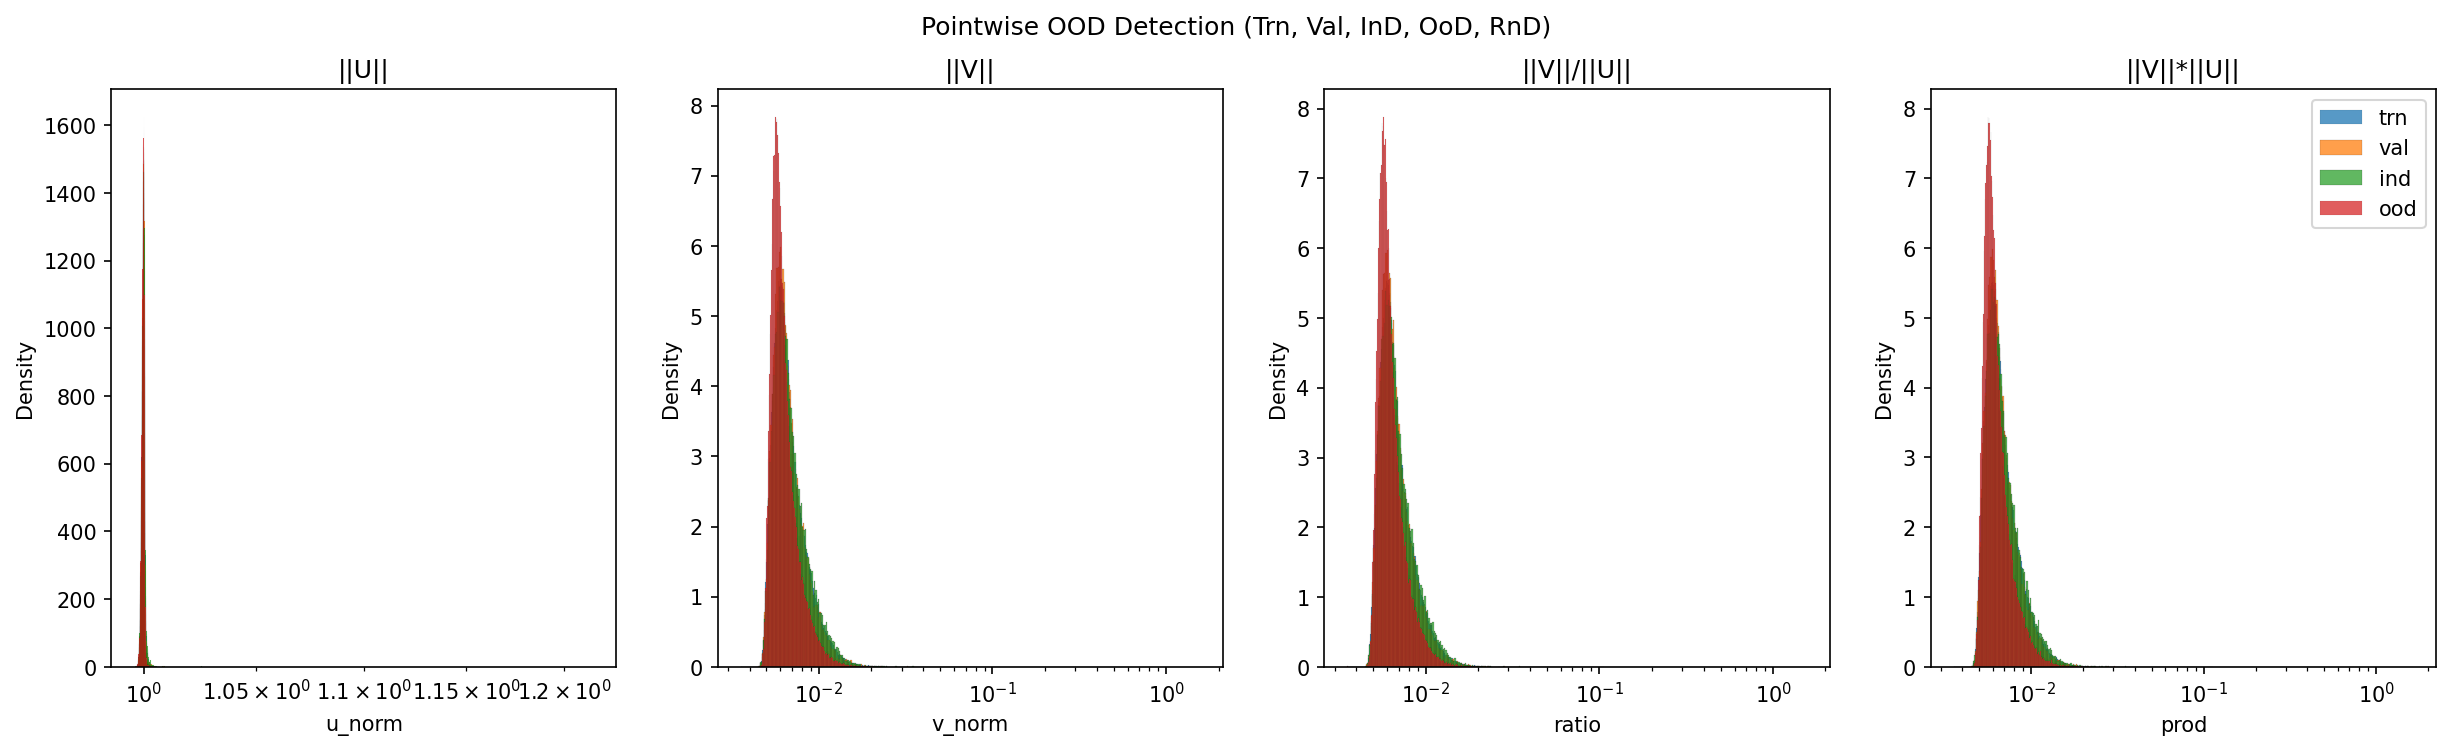

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_trn = pd.DataFrame(dict(u_norm=trn_u_norms, v_norm=trn_v_norms, ratio=trn_v_norms/trn_u_norms, prod=trn_v_norms*trn_u_norms, target=trn_targets))
data_val = pd.DataFrame(dict(u_norm=val_u_norms, v_norm=val_v_norms, ratio=val_v_norms/val_u_norms, prod=val_v_norms*val_u_norms, target=val_targets))
data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
if ood_str:
    data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (Trn, Val, InD, OoD, RnD)")

sns.histplot(data=data_trn, x="u_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax1)
sns.histplot(data=data_val, x="u_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax1)
sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
if ood_str:
    sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
# sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_trn, x="v_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax2)
sns.histplot(data=data_val, x="v_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax2)
sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
if ood_str:
    sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
# sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_trn, x="ratio", log_scale=True, fill=True, label='trn', stat='density', ax=ax3)
sns.histplot(data=data_val, x="ratio", log_scale=True, fill=True, label='val', stat='density', ax=ax3)
sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
if ood_str:
    sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
# sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_trn, x="prod", log_scale=True, fill=True, label='trn', stat='density', ax=ax4)
sns.histplot(data=data_val, x="prod", log_scale=True, fill=True, label='val', stat='density', ax=ax4)
sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
if ood_str:
    sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
# sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [13]:
from scipy import stats
print("Trn", trn_v_norms.min(), trn_v_norms.max(), trn_v_norms.ptp())
print("Val", val_v_norms.min(), val_v_norms.max(), val_v_norms.ptp())
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
if ood_str:
    print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

if ood_str:
    ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
    print(ks_ind_ood)

Trn 0.0035469942 1.5646187 1.5610718
Val 0.0035469942 0.1100043 0.10645731
Ind 0.0035469942 0.075588204 0.07204121
Ood 0.0035469942 0.37796882 0.37442183
Rnd 11.257547 13.706201 2.4486532
KstestResult(statistic=0.18799435952401516, pvalue=0.0, statistic_location=0.0064090407, statistic_sign=-1)


[0 1 3 2 4]


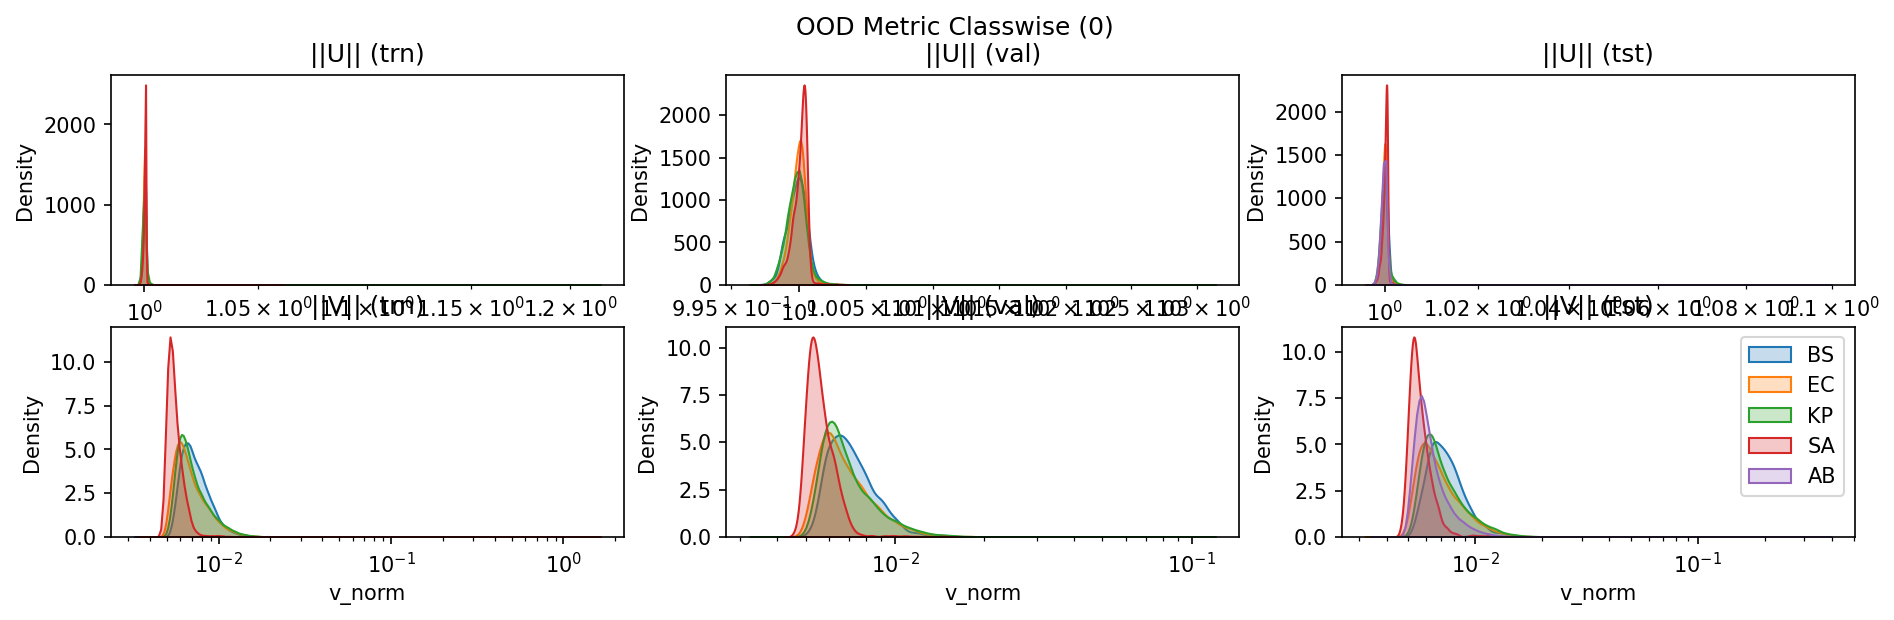

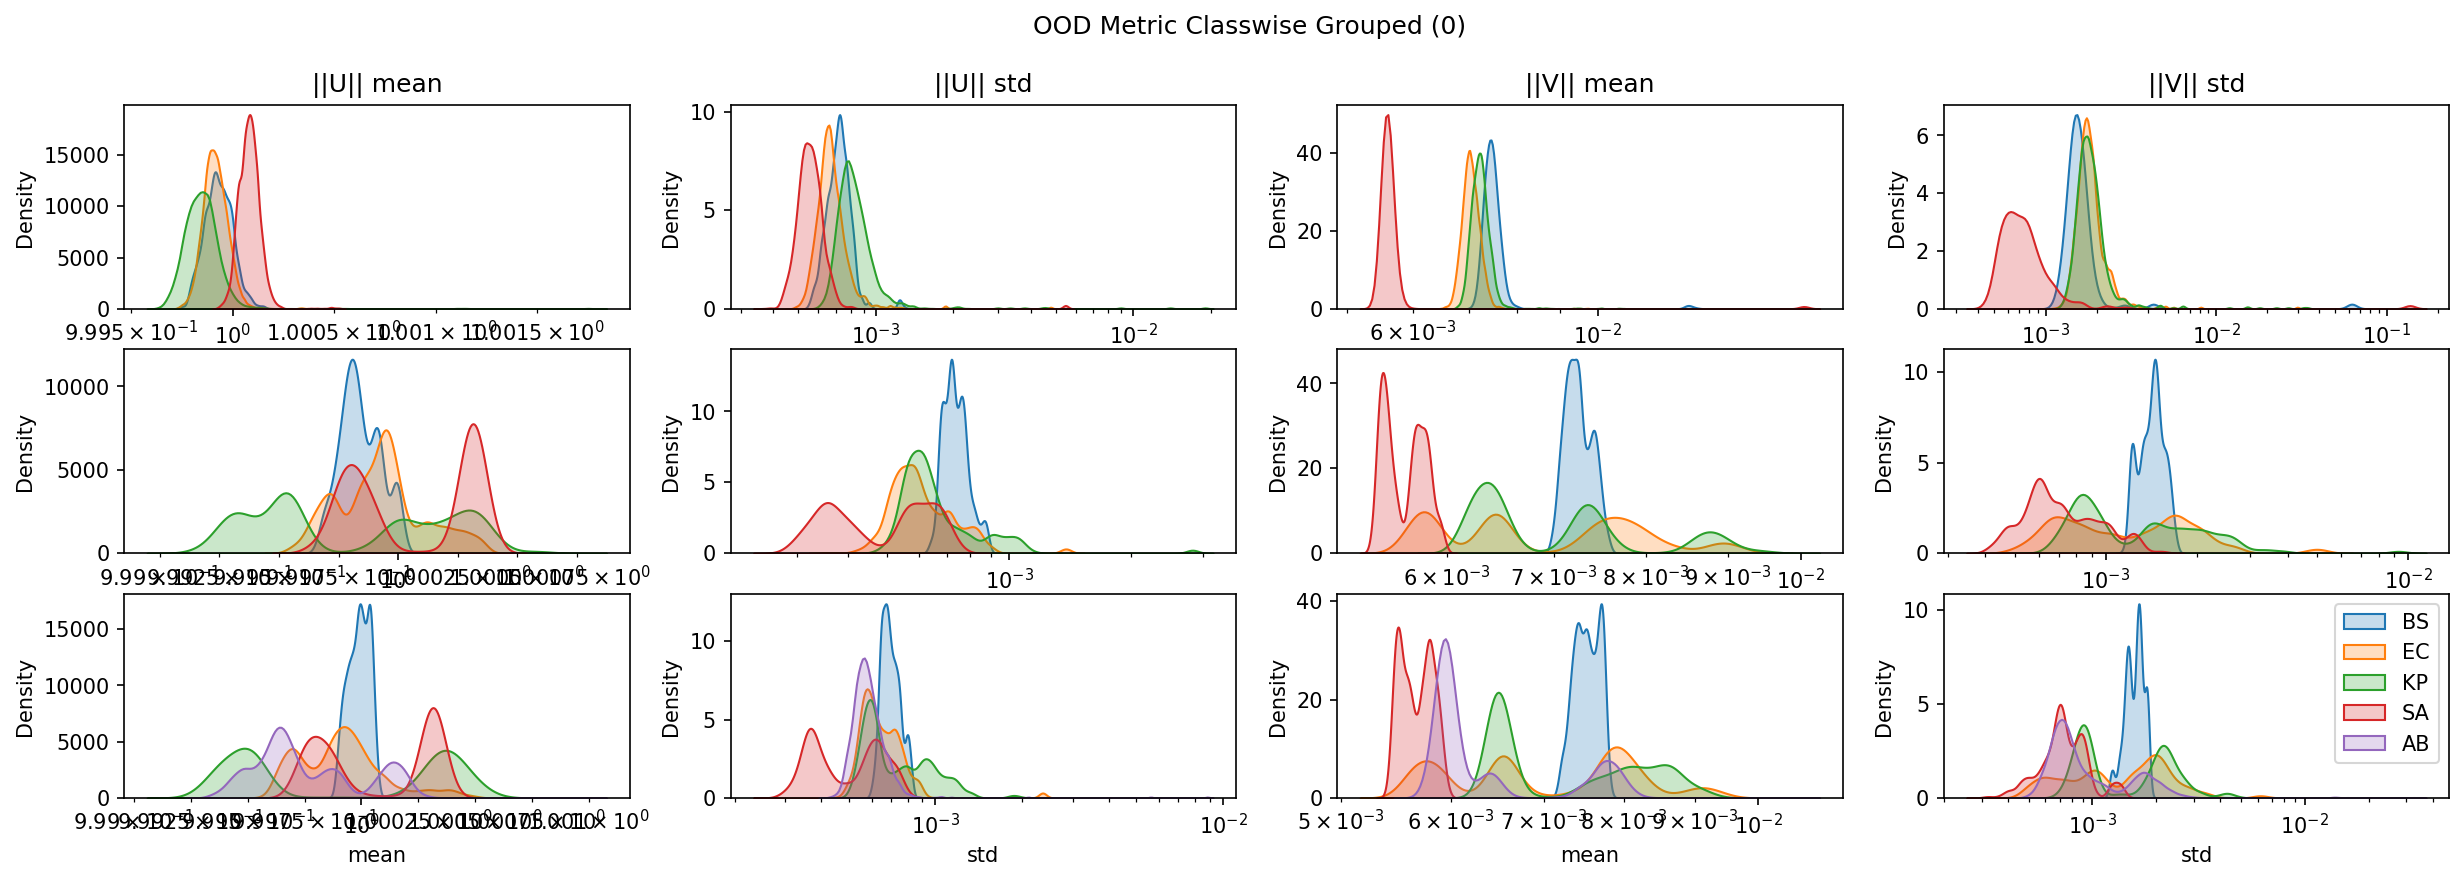

In [14]:
if ood_str:
    data_tst = pd.concat([data_ind, data_ood], axis=0)
else:
    data_tst = data_ind
print(data_tst['target'].unique())

N = 128

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(5):
    df_trn = data_trn[data_trn['target'] == i]
    df_val = data_val[data_val['target'] == i]
    df_tst = data_tst[data_tst['target'] == i]
    pointwise_trn[i] = df_trn.copy()
    pointwise_val[i] = df_val.copy()
    pointwise_tst[i] = df_tst.copy()
    groupwise_trn[i] = df_trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = df_val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = df_tst.rolling(N).agg(['mean', 'std']).dropna().copy()

# pointwise
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize = (15, 4))
fig.suptitle(f"OOD Metric Classwise ({ood_str})")

for i in range(5):
    df_trn = pointwise_trn[i]
    df_val = pointwise_val[i]
    df_tst = pointwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_val, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_tst, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax6)

ax1.title.set_text('||U|| (trn)')
ax2.title.set_text('||U|| (val)')
ax3.title.set_text('||U|| (tst)')
ax4.title.set_text('||V|| (trn)')
ax5.title.set_text('||V|| (val)')
ax6.title.set_text('||V|| (tst)')
plt.legend()
plt.show()
    
# groupwise
fig, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, axA, axB, axC]) = plt.subplots(3, 4, figsize = (20, 6))
fig.suptitle(f"OOD Metric Classwise Grouped ({ood_str})")

for i in range(5):
    df_trn = groupwise_trn[i]
    df_val = groupwise_val[i]
    df_tst = groupwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_trn.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_trn.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
        sns.kdeplot(data=df_val.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax6)
        sns.kdeplot(data=df_val.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax7)
        sns.kdeplot(data=df_val.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax8)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax9)
        sns.kdeplot(data=df_tst.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axA)
        sns.kdeplot(data=df_tst.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=axB)
        sns.kdeplot(data=df_tst.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axC)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()

In [15]:
# save vector norms for hypothesis testing

base_path = Path(f"assets/embeddings/{config.dataset_name}_{config.model_name}_M{config.emb_dims}_{ood_str}")
base_path.mkdir(exist_ok=True)

for i in range(5):
    df_trn = pointwise_trn.get(i, None)
    df_val = pointwise_val.get(i, None)
    df_tst = pointwise_tst.get(i, None)
    if df_trn is not None and len(df_trn) > 0:
        np.save(base_path / f"train_{i}.npy", df_trn.v_norm.values)
    if df_val is not None and len(df_val) > 0:
        np.save(base_path / f"val_{i}.npy", df_val.v_norm.values)
    if df_tst is not None and len(df_tst) > 0:
        np.save(base_path / f"test_{i}.npy", df_tst.v_norm.values)